In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from main import read_in_blicks, BOUNDARY, eval_auc
import scorers
import datasets
import informants
import learners
from tqdm import tqdm

from util import entropy, kl_bern

In [3]:
import pandas as pd

In [4]:
feature_type = 'english'
SEED=1

In [5]:
def load_informant_scorer(feature_type):
    lexicon_path = f'data/hw/{feature_type}_lexicon.txt'
    phoneme_feature_path = f'data/hw/{feature_type}_features.txt'
    ngram_feature_path = f'data/hw/{feature_type}_feature_weights.txt'

    print(f'Loading lexicon from:\t{lexicon_path}')
    dataset = datasets.load_lexicon(lexicon_path, min_length=2, max_length=5)

#     You'll probably want to change this line to create your own scorer
    mf_scorer = scorers.MeanFieldScorer(dataset, 
                                        feature_type=feature_type, 
                                        phoneme_feature_file=phoneme_feature_path,
                                       )
    hw_scorer = scorers.HWScorer(dataset, 
                                        feature_type=feature_type, 
                                        phoneme_feature_file=phoneme_feature_path,
                                )

    # Load oracle
    informant = informants.HWInformant(dataset, hw_scorer)
    
    return informant, mf_scorer

In [6]:
informant, mf_scorer = load_informant_scorer(feature_type)

Loading lexicon from:	data/hw/english_lexicon.txt
Loading lexicon with min_length=2, max_length=5...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872
feature type:  english
Reading phoneme features from: data/hw/english_features.txt
Loading ngram features from: data/hw/english_feature_weights.txt


In [7]:
# Read in eval dataset

def load_train_dataset(file_name, informant, mf_scorer):
    print("Loading train dataset...")

    # Change this path if you want to specify a different eval dataset
    # eval_dataset_path = f'{feature_type}_test_set.txt'

    # Hacky, but the atr_harmony test set is stored at test_set.csv; the eval dataset names need to be standardized
    df = pd.read_csv(file_name)
    
    items, scores, phonemes, encoded_items, featurized_items, labels, new_costs = [], [], [], [], [], [], []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        item = (row['word'].strip().split(' '))
        score = float(row['score'])
        phon = [BOUNDARY] + item + [BOUNDARY]
        encoded = informant.dataset.vocab.encode(phon)
        features = mf_scorer._featurize(encoded).nonzero()[0]
        label = informant.judge(encoded)
        new_cost = informant.cost(encoded)

        items.append(item)
        scores.append(score)
        phonemes.append(phon)
        encoded_items.append(encoded)
        featurized_items.append(features)
        labels.append(label)
        new_costs.append(new_cost)

    # Get dataframe of results
    train_dataset = pd.DataFrame({
        'item': items,
        'label': labels,
        'cost': new_costs,
        'old_cost': scores,
        'encoded': encoded_items,
        'featurized': featurized_items,
    })
    
    test_label_agreement(train_dataset, informant)
    print("Done.")

    return train_dataset

In [8]:
def test_label_agreement(train_dataset, informant):
    """ Sanity check that the labels agree with labels from current oracle """

    print("Testing label agreement...")
    num_judgments_disagree = 0
    num_costs_disagree = 0
    for _, row in tqdm(train_dataset.iterrows(), total=len(train_dataset)):
        encod = row['encoded']
        judgment = row['label']
        informant.set_dataset = {}
        cost = informant.scorer.cost(encod)
        new_judgment = (cost < 2.53)
        
        judgments_agree = (judgment == new_judgment)
        costs_agree = (row['old_cost'] == row['cost'])
        
        if not judgments_agree or not costs_agree:
            print("word:", row['item'])
            print("cost:",cost)
            print("encoded:",encod)
        
        if not judgments_agree:
            print("old judgment:", judgment)
            print("curr judgment:", new_judgment)
            num_judgments_disagree += 1
        if not costs_agree:
            num_costs_disagree += 1
            print("old cost:", row['old_cost'])
            print("new cost:", row['cost'])
    #         assert False

    print("NUM JUDGMENTS DISAGREE:", num_judgments_disagree)
    print("NUM COSTS DISAGREE:", num_costs_disagree)
    print("Done.")
    

In [9]:
data_dir = 'data/BabbleRandomStringsEnglish'
# train_random_strings = load_train_dataset(f'{data_dir}/RandomStringsSubsampledBalanced.csv')
# train_random_wellformed = load_train_dataset(f'{data_dir}/RandomWellFormedSyllablesSubsampledBalanced.csv')
# train_babbled = load_train_dataset(f'data/MakingOverTrainSet/EnglishOverTrainingData.csv', informant, mf_scorer)


## Set random seeds

In [10]:
import random
import numpy as np


def set_seeds(seed, dataset):
    random.seed(seed)
    np.random.seed(seed)
    dataset.random.seed(seed)

## Load eval dataset

In [11]:
# Read in eval dataset

def load_eval_dataset(informant, mf_scorer):

    # Change this path if you want to specify a different eval dataset
    # eval_dataset_path = f'{feature_type}_test_set.txt'

    # Hacky, but the atr_harmony test set is stored at test_set.csv; the eval dataset names need to be standardized
    df = pd.read_csv('WordsAndScoresFixed_newest.csv')
    
    items = [i.strip().split(' ') for i in df['Word'].values]
    sources = [int(s) for s in df['Source'].values]
    labels = df['Score'].values
    
    # Get phonemes
    phonemes = [[BOUNDARY] + item + [BOUNDARY] for item in tqdm(items)]
    # Encode items
    encoded_items = [informant.dataset.vocab.encode(phon) for phon in tqdm(phonemes)]
    # Featurize items
    featurized_items = [mf_scorer._featurize(encod).nonzero()[0] for encod in tqdm(encoded_items)]
    # Get labels with HW oracle
    # assert same
    labels = [informant.judge(encod) for encod in tqdm(encoded_items)]

    new_costs = [informant.cost(encod) for encod in tqdm(encoded_items)]
    
    # Get dataframe of results
    eval_dataset = pd.DataFrame({
        'item': items,
        'label': labels,
        'encoded': encoded_items,
        'featurized': featurized_items,
        'source': sources,
        'cost': new_costs,
    })

    # only 5 is auc, others are human eval sets
    return eval_dataset[eval_dataset['source']==5]

In [12]:
eval_dataset = load_eval_dataset(informant, mf_scorer)
display(eval_dataset)

100%|█████████████████████████████████████████████| 12390/12390 [00:27<00:00, 451.83it/s]


item  label  \
1054                            [AW]  False   
1055                            [IH]  False   
1056                            [UH]  False   
1057                            [DH]   True   
1058                             [R]   True   
...                              ...    ...   
12385   [S, T, IY, ER, V, IY, AA, Z]   True   
12386    [B, AO, R, EH, B, R, G, OW]   True   
12387  [ER, IH, Z, AH, N, ER, AA, P]   True   
12388   [DH, IH, TH, R, S, W, AE, D]   True   
12389   [L, AA, R, UW, EH, N, AE, G]   True   

                                     encoded  \
1054                              (0, 26, 0)   
1055                              (0, 14, 0)   
1056                              (0, 38, 0)   
1057                              (0, 39, 0)   
1058                              (0, 12, 0)   
...                                      ...   
12385  (0, 6, 10, 11, 20, 13, 11, 17, 25, 0)   
12386   (0, 3, 22, 12, 19, 3, 12, 28, 15, 0)   
12387   (0, 20, 14, 25, 2, 7, 20, 17, 29, 0)   
12388    (0, 39, 14, 37, 12, 6, 34, 4, 8, 0)   
12389   (0, 18, 17, 12, 30, 19, 7, 4, 28, 0)   

                                              featurized  source    cost  
1054          [52058, 52134, 52172, 52552, 53008, 53236]       5   3.233  
1055   [52058, 52134, 52172, 53008, 53122, 53198, 532...       5   6.983  
1056   [52058, 52134, 52172, 52552, 53008, 53084, 531...       5  11.848  
1057   [52020, 52134, 52210, 52248, 52400, 52628, 527...       5   0.000  
1058          [52058, 52096, 52172, 52628, 52742, 52818]       5   0.000  
...                                                  ...     ...     ...  
12385  [1, 3, 4, 26, 29, 30, 33, 34, 39, 40, 41, 42, ...       5   0.000  
12386  [38, 39, 40, 41, 42, 43, 45, 48, 54, 57, 59, 6...       5   0.000  
12387  [38, 39, 41, 42, 46, 54, 56, 59, 65, 66, 69, 7...       5   0.000  
12388  [38, 39, 41, 42, 43, 44, 49, 54, 56, 58, 59, 6...       5   0.000  
12389  [38, 39, 40, 41, 42, 43, 45, 48, 54, 57, 59, 6...       5   0.000  

[11336 rows x 6 columns]

## Initialize learner

## Main loop

In [12]:
def get_auc(scorer, eval_dataset):
    # Learner.cost() is used to get predictions for the test set
    costs = [scorer.cost(encod) for encod in eval_dataset['encoded'].values]
    auc = eval_auc(costs, eval_dataset['label'].values)
    return auc

In [13]:
TRAIN_CACHES = {}


In [14]:
import os
import wandb

def initialize_hyp(lla, prior, tol, max_updates, dataset, phoneme_feature_path):
    print("Initializing learner...")
    # You may also have to create a slightly modified learner class to wrap around your linear model scorer
    scorer = scorers.MeanFieldScorer(dataset, 
                                     log_log_alpha_ratio=lla,
                                     prior_prob=prior,
                                     feature_type=feature_type,
                                     tolerance=tol,
                                     phoneme_feature_file=phoneme_feature_path,
                                   )
    
    
    
    return scorer

def run(lla, prior, max_updates, tol, train_file, eval_dataset, phoneme_feature_path,
        out_dir='big_batch', 
        wandb_project='1114_big_batch', 
        num_samples=None,
       ):
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    config = {
        'log_log_alpha_ratio': lla,
        'prior_prob': prior,
        'max_updates': max_updates,
        'tolerance': tol,
        'train_file': train_file,
        'num_samples': num_samples,
    }
    
    wandb_run = wandb.init(config=config, project=wandb_project, reinit=True, entity='lm-informants')

    print(config)
    
    global TRAIN_CACHES
    print('train caches:', TRAIN_CACHES)

    if train_file in TRAIN_CACHES:
        train_dataset = TRAIN_CACHES[train_file]
    else:
        train_dataset = load_train_dataset(train_file, informant, mf_scorer)
        TRAIN_CACHES[train_file] = train_dataset
        
    print('train caches:', TRAIN_CACHES)
        
    sub_dir = os.path.join(out_dir, f'lla={lla}_prior={prior}_max-updates={max_updates}_tol={tol}_num-samples={num_samples}')
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)

    scorer = initialize_hyp(lla, prior, tol, max_updates, informant.dataset, phoneme_feature_path)
    
    print('avg prior:', scorer.probs.mean())
    
    ordered_feats = train_dataset['featurized'].values
    ordered_judgments = train_dataset['label'].values
    ordered_judgments = [1 if j else -1 for j in ordered_judgments]
    
    if num_samples is not None:
        # TODO: setting seed of informant.dataset; is that what we want? 
        # (I think it would only matter for learner.dataset, for getting a train candidate, which we're not using here)
        set_seeds(SEED, informant.dataset)
        ordered_feats, ordered_judgments = zip(*random.sample(list(zip(ordered_feats, ordered_judgments)), num_samples))

    print('# data:', len(ordered_feats))
        
    # TODO: setting seed of informant.dataset; is that what we want? 
    # (I think it would only matter for learner.dataset, for getting a train candidate, which we're not using here)
    set_seeds(SEED, informant.dataset)
    
    # Log distribution over train scores
    table_data = [[s] for s in train_dataset['cost'].values]
    table = wandb.Table(data=table_data, columns=["oracle_costs"])
    wandb.log({'train_oracle_costs': wandb.plot.histogram(table, "oracle_costs",
          title="Train: Distribution of oracle costs", num_bins=20)})
    
    # Log distribution over eval scores
    table_data = [[s] for s in eval_dataset['cost'].values]
    print(table_data)
    table = wandb.Table(data=table_data, columns=["oracle_costs"])
    wandb.log({'eval_oracle_costs': wandb.plot.histogram(table, "oracle_costs",
          title="Eval: Distribution of oracle costs", num_bins=20)})

    scorer.update(
        ordered_feats, ordered_judgments, 
        max_updates=max_updates,
        verbose=False)
    
    print("Getting auc...")
    auc = get_auc(scorer, eval_dataset)
    print("Done.")

    print("")
    print(f"auc: {auc}")
    
    print('avg posterior:', scorer.probs.mean())
    
    # Log distribution over learned thetas
    table = wandb.Table(data=[[s] for s in scorer.probs], columns=["prob"])
    wandb.log({'learned_probs': wandb.plot.histogram(table, "prob",
          title="Distribution of learned thetas", num_bins=20)})
    
    probs_file = os.path.join(sub_dir, f'probs.npy')
    # save to probs.py so that it shows up on wandb that way
    np.save('probs.npy', scorer.probs,)
    wandb.save('probs.npy')
    print(f"Writing probs to: {probs_file}")
    # move probs.py file to probs_file
    os.rename('probs.npy', probs_file)
    
    auc_file_name = os.path.join(sub_dir, 'auc.txt')
    print(f'Writing auc to {auc_file_name}')
    print(f'{auc}', file=open(auc_file_name, 'w'))
    
    wandb.log({'auc': auc})

    print("================================")
    
    wandb_run.finish()

In [81]:
def get_probs_file(config, base_dir='big_batch'):
    sub_dir = f'lla={config["log_log_alpha_ratio"]}_prior={config["prior_prob"]}_max-updates={config["max_updates"]}_tol={config["tolerance"]}_num-samples={config["num_samples"]}'
    f = os.path.join(base_dir, sub_dir, 'probs.npy')
    
    return f

def load_probs(run, project_dir='lm-informants/1114_big_batch'):
    f = get_probs_file(run.config)
    return np.load(wandb.restore(f, run_path=f'{project_dir}/{run.id}').name)

In [109]:
import wandb
import pandas as pd
from tqdm import tqdm

def get_wandb_runs():

    # Set your W&B API key (you can find it in your W&B account settings)
    wandb.login()


    # Get all runs from the project
    api = wandb.Api()
    runs = api.runs("lm-informants/1114_big_batch")

    # Initialize lists to store data
    data = []

    # Iterate over runs
    for run in tqdm(runs):
        run_id = run.id

        # Download run artifacts
    #     run.download()

        # Get run metrics
        metrics = run.history()

        # Get run config
        config = run.config

        # Append data to the list
        d = ({
            "run_id": run_id,
            "metrics": metrics,
        })
        d.update(config)
        d['config'] = config
        d.update(run.summary._json_dict)
        data.append(d)
        
        probs = load_probs(run)
        d.update({'probs': probs})

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    df = df.dropna(subset=['auc'], axis=0)
    df = df.fillna("None")


    # Save DataFrame to a CSV file
#     df.to_csv("wandb_runs.csv", index=False)

    return df

In [96]:
df = get_wandb_runs()

100%|███████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.48it/s]


In [111]:
df['train_file_short'] = df.apply(lambda row: file_map[row['train_file']], axis=1)

In [161]:
indices_to_feats = {feat_idx: mf_scorer.feature_vocab.decode(feat) for feat, feat_idx in mf_scorer.ngram_features.items()}
indices_to_feats_encoded = {feat_idx: feat for feat, feat_idx in mf_scorer.ngram_features.items()}


In [114]:
eval_row = df[df['run_id']=='kpqlkcdq'].iloc[0]
print(eval_row['config'])
print(eval_row['train_file_short'])

{'tolerance': 1.953125e-06, 'prior_prob': 0.00240504883318384, 'train_file': 'WordsAndScoresFixed_newest.csv', 'max_updates': None, 'num_samples': None, 'log_log_alpha_ratio': 5.41687946870128}
eval


In [162]:
for feat_idx, weight in enumerate(eval_row['probs']):
    print(feat_idx, round(weight, 4), indices_to_feats[feat_idx], indices_to_feats_encoded[feat_idx])
    

0 1.0 ('+consonantal', '+consonantal', '+consonantal') (0, 0, 0)
1 1.0 ('+consonantal', '+consonantal', '-consonantal') (0, 0, 1)
2 1.0 ('+consonantal', '+consonantal', '+approximant') (0, 0, 2)
3 1.0 ('+consonantal', '+consonantal', '-approximant') (0, 0, 3)
4 1.0 ('+consonantal', '+consonantal', '+sonorant') (0, 0, 4)
5 1.0 ('+consonantal', '+consonantal', '-sonorant') (0, 0, 5)
6 1.0 ('+consonantal', '+consonantal', '+continuant') (0, 0, 6)
7 1.0 ('+consonantal', '+consonantal', '-continuant') (0, 0, 7)
8 1.0 ('+consonantal', '+consonantal', '+nasal') (0, 0, 8)
9 0.0024 ('+consonantal', '+consonantal', '-nasal') (0, 0, 9)
10 1.0 ('+consonantal', '+consonantal', '+voice') (0, 0, 10)
11 1.0 ('+consonantal', '+consonantal', '-voice') (0, 0, 11)
12 1.0 ('+consonantal', '+consonantal', '+spread') (0, 0, 12)
13 0.0024 ('+consonantal', '+consonantal', '-spread') (0, 0, 13)
14 1.0 ('+consonantal', '+consonantal', '+labial') (0, 0, 14)
15 1.0 ('+consonantal', '+consonantal', '-labial') (0, 0

8278 1.0 ('-sonorant', '-high', '+low') (5, 27, 32)
8279 1.0 ('-sonorant', '-high', '-low') (5, 27, 33)
8280 1.0 ('-sonorant', '-high', '+front') (5, 27, 34)
8281 1.0 ('-sonorant', '-high', '-front') (5, 27, 35)
8282 0.0 ('-sonorant', '-high', '+word_boundary') (5, 27, 36)
8283 0.0024 ('-sonorant', '-high', '-word_boundary') (5, 27, 37)
8284 0.0 ('-sonorant', '+back', '+consonantal') (5, 28, 0)
8285 0.0 ('-sonorant', '+back', '-consonantal') (5, 28, 1)
8286 0.0 ('-sonorant', '+back', '+approximant') (5, 28, 2)
8287 0.0 ('-sonorant', '+back', '-approximant') (5, 28, 3)
8288 0.0 ('-sonorant', '+back', '+sonorant') (5, 28, 4)
8289 0.0 ('-sonorant', '+back', '-sonorant') (5, 28, 5)
8290 0.0 ('-sonorant', '+back', '+continuant') (5, 28, 6)
8291 0.0 ('-sonorant', '+back', '-continuant') (5, 28, 7)
8292 0.0 ('-sonorant', '+back', '+nasal') (5, 28, 8)
8293 0.0024 ('-sonorant', '+back', '-nasal') (5, 28, 9)
8294 0.0 ('-sonorant', '+back', '+voice') (5, 28, 10)
8295 0.0 ('-sonorant', '+back', '-

20937 0.0024 ('+labial', '+anterior', '-word_boundary') (14, 18, 37)
20938 0.0 ('+labial', '-anterior', '+consonantal') (14, 19, 0)
20939 0.0 ('+labial', '-anterior', '-consonantal') (14, 19, 1)
20940 1.0 ('+labial', '-anterior', '+approximant') (14, 19, 2)
20941 0.0 ('+labial', '-anterior', '-approximant') (14, 19, 3)
20942 0.0 ('+labial', '-anterior', '+sonorant') (14, 19, 4)
20943 0.0 ('+labial', '-anterior', '-sonorant') (14, 19, 5)
20944 0.0 ('+labial', '-anterior', '+continuant') (14, 19, 6)
20945 0.0 ('+labial', '-anterior', '-continuant') (14, 19, 7)
20946 1.0 ('+labial', '-anterior', '+nasal') (14, 19, 8)
20947 0.0024 ('+labial', '-anterior', '-nasal') (14, 19, 9)
20948 1.0 ('+labial', '-anterior', '+voice') (14, 19, 10)
20949 0.0 ('+labial', '-anterior', '-voice') (14, 19, 11)
20950 1.0 ('+labial', '-anterior', '+spread') (14, 19, 12)
20951 0.0024 ('+labial', '-anterior', '-spread') (14, 19, 13)
20952 0.0 ('+labial', '-anterior', '+labial') (14, 19, 14)
20953 0.0 ('+labial', 

33816 0.0024 ('-lateral', '-labial', '+front') (23, 15, 34)
33817 0.0024 ('-lateral', '-labial', '-front') (23, 15, 35)
33818 0.0024 ('-lateral', '-labial', '+word_boundary') (23, 15, 36)
33819 0.0024 ('-lateral', '-labial', '-word_boundary') (23, 15, 37)
33820 0.0024 ('-lateral', '+coronal', '+consonantal') (23, 16, 0)
33821 0.0024 ('-lateral', '+coronal', '-consonantal') (23, 16, 1)
33822 0.0024 ('-lateral', '+coronal', '+approximant') (23, 16, 2)
33823 0.0024 ('-lateral', '+coronal', '-approximant') (23, 16, 3)
33824 0.0024 ('-lateral', '+coronal', '+sonorant') (23, 16, 4)
33825 0.0024 ('-lateral', '+coronal', '-sonorant') (23, 16, 5)
33826 0.0024 ('-lateral', '+coronal', '+continuant') (23, 16, 6)
33827 0.0024 ('-lateral', '+coronal', '-continuant') (23, 16, 7)
33828 0.0024 ('-lateral', '+coronal', '+nasal') (23, 16, 8)
33829 0.0024 ('-lateral', '+coronal', '-nasal') (23, 16, 9)
33830 0.0024 ('-lateral', '+coronal', '+voice') (23, 16, 10)
33831 0.0024 ('-lateral', '+coronal', '-voi

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [163]:
for (feat_template, weight) in informant.scorer.ngram_features[3]:
    print(feat_template)
    print(weight)
    print(informant.scorer.pp_feature(feat_template))
    print()
    

((36,), (0,), (6,))
2.084
[+word_boundary] [+consonantal] [+continuant]

((36,), (0,), (10,))
2.858
[+word_boundary] [+consonantal] [+voice]

((36,), (3, 33), (29,))
1.792
[+word_boundary] [-approximant, -low] [-back]

((36,), (10,), (3, 0))
1.749
[+word_boundary] [+voice] [-approximant, +consonantal]

((36,), (16,), (10,))
0.659
[+word_boundary] [+coronal] [+voice]

((36,), (7,), (3, 0))
3.784
[+word_boundary] [-continuant] [-approximant, +consonantal]

((5,), (10,), (36,))
1.003
[-sonorant] [+voice] [+word_boundary]

((36,), (21,), (0,))
5.033
[+word_boundary] [-strident] [+consonantal]

((36,), (3, 26), (34,))
1.444
[+word_boundary] [-approximant, +high] [+front]

((36,), (3, 28), (31,))
1.67
[+word_boundary] [-approximant, +back] [-tense]

((36,), (14, 0), (3, 0))
3.467
[+word_boundary] [+labial, +consonantal] [-approximant, +consonantal]

((5,), (19,), (36,))
3.573
[-sonorant] [-anterior] [+word_boundary]

((7,), (14, 0), (36,))
1.062
[-continuant] [+labial, +consonantal] [+word_b

In [158]:
informant.scorer.pp_feature(((36,), (7,), (3, 0)))

'[+word_boundary] [-continuant] [-approximant, +consonantal]'

In [139]:
for k, v in informant.scorer.ngram_features.items():
    print(k)
    print(len(v))
    print(v)

2
180
[(((6,), (10,)), 1.967), (((3, 31), (3, 1)), 3.324), (((3, 31), (33,)), 1.802), (((11,), (10,)), 2.787), (((3, 28), (3, 14, 1)), 1.053), (((10, 16), (20,)), 2.824), (((6,), (6, 20)), 3.679), (((32,), (26, 28)), 0.449), (((7, 16), (7,)), 3.275), (((6, 10), (5, 16)), 0.054), (((6, 10), (11,)), 3.031), (((3, 19), (0,)), 4.383), (((36,), (3, 26, 28)), 2.826), (((3, 1), (3, 26, 28)), 1.693), (((32,), (3, 14, 26)), 0.81), (((3, 27, 29), (30, 33)), 0.972), (((3, 29, 31), (29,)), 1.081), (((27, 34), (14, 26)), 3.161), (((3, 1), (15,)), 2.642), (((34,), (26, 32)), 1.706), (((19,), (2, 26)), 1.326), (((5, 14), (7, 14)), 1.968), (((5, 24), (24,)), 3.956), (((10, 14), (24,)), 0.887), (((15,), (2, 26)), 1.414), (((14, 32), (2, 26)), 1.205), (((2, 26), (36,)), 4.897), (((2, 26), (0,)), 5.335), (((10,), (11, 19)), 2.083), (((26, 32), (6, 19)), 3.366), (((11, 21), (24,)), 1.679), (((6, 21), (5,)), 2.426), (((26, 31), (36,)), 2.154), (((31, 34), (36,)), 4.829), (((2, 26), (16,)), 2.29), (((11, 14

In [124]:
print(informant.scorer.ngram_features)

{2: [(((6,), (10,)), 1.967), (((3, 31), (3, 1)), 3.324), (((3, 31), (33,)), 1.802), (((11,), (10,)), 2.787), (((3, 28), (3, 14, 1)), 1.053), (((10, 16), (20,)), 2.824), (((6,), (6, 20)), 3.679), (((32,), (26, 28)), 0.449), (((7, 16), (7,)), 3.275), (((6, 10), (5, 16)), 0.054), (((6, 10), (11,)), 3.031), (((3, 19), (0,)), 4.383), (((36,), (3, 26, 28)), 2.826), (((3, 1), (3, 26, 28)), 1.693), (((32,), (3, 14, 26)), 0.81), (((3, 27, 29), (30, 33)), 0.972), (((3, 29, 31), (29,)), 1.081), (((27, 34), (14, 26)), 3.161), (((3, 1), (15,)), 2.642), (((34,), (26, 32)), 1.706), (((19,), (2, 26)), 1.326), (((5, 14), (7, 14)), 1.968), (((5, 24), (24,)), 3.956), (((10, 14), (24,)), 0.887), (((15,), (2, 26)), 1.414), (((14, 32), (2, 26)), 1.205), (((2, 26), (36,)), 4.897), (((2, 26), (0,)), 5.335), (((10,), (11, 19)), 2.083), (((26, 32), (6, 19)), 3.366), (((11, 21), (24,)), 1.679), (((6, 21), (5,)), 2.426), (((26, 31), (36,)), 2.154), (((31, 34), (36,)), 4.829), (((2, 26), (16,)), 2.29), (((11, 14),

In [ ]:
eval_row['probs']

In [88]:
for feat, feat_idx in mf_scorer.ngram_features.items():
    decoded = (mf_scorer.feature_vocab.decode(feat))
    print(feat_idx, decoded)

0 ('+consonantal', '+consonantal', '+consonantal')
1 ('+consonantal', '+consonantal', '-consonantal')
2 ('+consonantal', '+consonantal', '+approximant')
3 ('+consonantal', '+consonantal', '-approximant')
4 ('+consonantal', '+consonantal', '+sonorant')
5 ('+consonantal', '+consonantal', '-sonorant')
6 ('+consonantal', '+consonantal', '+continuant')
7 ('+consonantal', '+consonantal', '-continuant')
8 ('+consonantal', '+consonantal', '+nasal')
9 ('+consonantal', '+consonantal', '-nasal')
10 ('+consonantal', '+consonantal', '+voice')
11 ('+consonantal', '+consonantal', '-voice')
12 ('+consonantal', '+consonantal', '+spread')
13 ('+consonantal', '+consonantal', '-spread')
14 ('+consonantal', '+consonantal', '+labial')
15 ('+consonantal', '+consonantal', '-labial')
16 ('+consonantal', '+consonantal', '+coronal')
17 ('+consonantal', '+consonantal', '-coronal')
18 ('+consonantal', '+consonantal', '+anterior')
19 ('+consonantal', '+consonantal', '-anterior')
20 ('+consonantal', '+consonantal', 

27918 ('-anterior', '+spread', '+high')
27919 ('-anterior', '+spread', '-high')
27920 ('-anterior', '+spread', '+back')
27921 ('-anterior', '+spread', '-back')
27922 ('-anterior', '+spread', '+tense')
27923 ('-anterior', '+spread', '-tense')
27924 ('-anterior', '+spread', '+low')
27925 ('-anterior', '+spread', '-low')
27926 ('-anterior', '+spread', '+front')
27927 ('-anterior', '+spread', '-front')
27928 ('-anterior', '+spread', '+word_boundary')
27929 ('-anterior', '+spread', '-word_boundary')
27930 ('-anterior', '-spread', '+consonantal')
27931 ('-anterior', '-spread', '-consonantal')
27932 ('-anterior', '-spread', '+approximant')
27933 ('-anterior', '-spread', '-approximant')
27934 ('-anterior', '-spread', '+sonorant')
27935 ('-anterior', '-spread', '-sonorant')
27936 ('-anterior', '-spread', '+continuant')
27937 ('-anterior', '-spread', '-continuant')
27938 ('-anterior', '-spread', '+nasal')
27939 ('-anterior', '-spread', '-nasal')
27940 ('-anterior', '-spread', '+voice')
27941 ('-

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

file_map = {
    'WordsAndScoresFixed_newest.csv': 'eval',
    'data/BabbleRandomStringsEnglish/RandomStringsSubsampledBalanced.csv': 'random_strings',
    'data/MakingOverTrainSet/EnglishOverTrainingData.csv': 'hw_babble',
    'data/BabbleRandomStringsEnglish/RandomWellFormedSyllablesSubsampledBalanced.csv': 'random_wellformed',
}

inverse_file_map = {v:k for k,v in file_map.items()}

def plot_auc(df, max_updates=1):
    
    m = file_map

    temp = df[df['max_updates']!=max_updates]


    title = f'max_updates=None'

    temp['train_name'] = temp.apply(lambda row: m[row['train_file']], axis=1)

    # Choose the grouping key (either "num_samples" or "train_file")
    grouping_key = "num_samples"

    # Automatically create a color palette based on unique values in the other key
    palette = sns.color_palette("husl", n_colors=len(temp[grouping_key].unique()))

    # Create a bar plot
    ax = sns.barplot(
        x=grouping_key,
        y="auc",
        hue="train_name" if grouping_key == "num_samples" else "num_samples",
        data=temp,
        palette=palette,
        order=[10.0, 1000.0, 5000.0, 7000.0, "None"],  # Specify the order of x-axis values

    )
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower center', borderaxespad=0.)

    plt.title(title)
    # Show the plot
    plt.show()

In [58]:
df

run_id                                            metrics  tolerance  \
0   kpqlkcdq       _timestamp                               ...   0.000002   
1   esrhwmyt         _runtime    _timestamp  \
0    185.9188...   0.000002   
2   260x2m2l     _step      _runtime    _timestamp  \
0     ...   0.000002   
3   tku5l5t1         _runtime    _timestamp  \
0    184.0696...   0.000002   
4   4r66aqrk     _step      _runtime    _timestamp  \
0     ...   0.000002   
5   4oh9gzmw                               eval_oracle_costs...   0.000002   
8   roaovkp2          auc  _step     _runtime    _timestamp ...   0.000002   
9   kqjx5wf4          auc  _step    _runtime    _timestamp  ...   0.000002   
10  bo8wlszs       _timestamp                               ...   0.000002   
11  105c3niz          auc  _step    _runtime    _timestamp  ...   0.000002   
12  6o1udllz          auc  _step     _runtime    _timestamp ...   0.000002   
13  96szl94d          auc  _step     _runtime    _timestamp ...   0.000002   
14  kgrfmw72                               eval_oracle_costs...   0.000002   
15  zuoykhqy       _timestamp                               ...   0.000002   
16  qt9efjrn                               eval_oracle_costs...   0.000002   
17  i2tum3bq                               eval_oracle_costs...   0.000002   
18  xjxb4hge          auc  _step   _runtime    _timestamp  \...   0.000002   
19  1b4x99z3     _step   _runtime    _timestamp  \
0      0 ...   0.000002   
20  kgila552       _timestamp                               ...   0.000002   
21  00f0ix36                                   learned_probs...   0.000002   
22  3yq8l802       _timestamp                               ...   0.000002   
23  l0doatw4                              train_oracle_costs...   0.000002   
24  qgr4orud                               eval_oracle_costs...   0.000002   
25  1uzcs5wq        _runtime    _timestamp  \
0    10.752976...   0.000002   
26  9snoc542        _runtime    _timestamp  \
0    10.682446...   0.000002   
27  sg23c439     _step     _runtime    _timestamp  \
0      ...   0.000002   
28  qgiu4oxo                                   learned_probs...   0.000002   
29  ay7sop9d        _runtime    _timestamp  \
0     8.177746...   0.000002   
30  jejbzhaa                                   learned_probs...   0.000002   
31  9xx128x0     _step   _runtime    _timestamp  \
0      0 ...   0.000002   
32  kcduoa3z                                   learned_probs...   0.000002   

    prior_prob                                         train_file max_updates  \
0     0.002405                     WordsAndScoresFixed_newest.csv        None   
1     0.002405                     WordsAndScoresFixed_newest.csv         1.0   
2     0.001385                     WordsAndScoresFixed_newest.csv        None   
3     0.001385                     WordsAndScoresFixed_newest.csv         1.0   
4     0.001385                     WordsAndScoresFixed_newest.csv        None   
5     0.001385                     WordsAndScoresFixed_newest.csv         1.0   
8     0.001385  data/BabbleRandomStringsEnglish/RandomStringsS...         1.0   
9     0.001385  data/MakingOverTrainSet/EnglishOverTrainingDat...        None   
10    0.001385  data/BabbleRandomStringsEnglish/RandomWellForm...        None   
11    0.001385  data/BabbleRandomStringsEnglish/RandomStringsS...        None   
12    0.001385  data/MakingOverTrainSet/EnglishOverTrainingDat...        None   
13    0.001385  data/BabbleRandomStringsEnglish/RandomWellForm...        None   
14    0.001385  data/BabbleRandomStringsEnglish/RandomStringsS...        None   
15    0.001385  data/MakingOverTrainSet/EnglishOverTrainingDat...        None   
16    0.001385  data/BabbleRandomStringsEnglish/RandomWellForm...        None   
17    0.001385  data/BabbleRandomStringsEnglish/RandomStringsS...        None   
18    0.001385  data/MakingOverTrainSet/EnglishOverTrainingDat...        None   
19    0.001385  data/BabbleRandomStringsEnglish/Ran

/tmp/ipykernel_4098127/4289480524.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['train_name'] = temp.apply(lambda row: m[row['train_file']], axis=1)


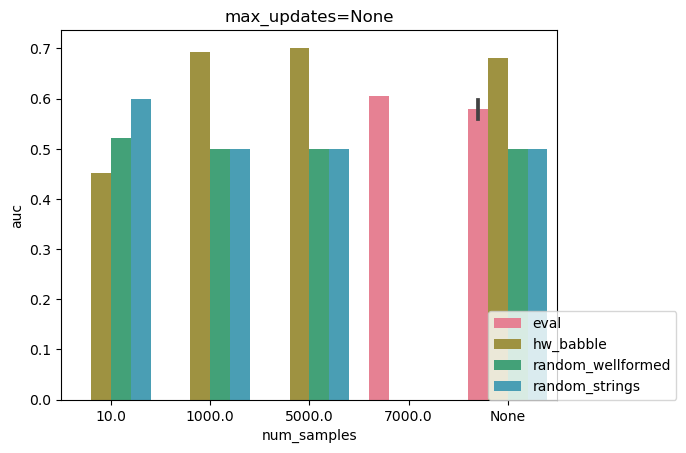

In [30]:
plot_auc(df)

In [67]:
# Get all runs from the project
api = wandb.Api()
runs = api.runs("lm-informants/1114_big_batch")
run = runs[0]

In [78]:
load_probs(run)

array([0.99999   , 0.99999   , 0.99999   , ..., 0.00240505, 0.00240505,
       0.00240505])

In [74]:
file_name = 'big_batch/lla=5.41687946870128_prior=0.00240504883318384_max-updates=None_tol=1.953125e-06_num-samples=None/probs.npy'
f = wandb.restore(file_name, run_path="lm-informants/1114_big_batch/kpqlkcdq")



In [71]:
file_name

'big_batch/lla=5.41687946870128_prior=0.00240504883318384_max-updates=None_tol=1.953125e-06_num-samples=None/probs.npy'

In [76]:
get_probs_file(run.config)

'big_batch/lla=5.41687946870128_prior=0.00240504883318384_max-updates=None_tol=1.953125e-06_num_samples=None/probs.npy'

In [47]:
f.name

'/raid/lingo/alexisro/lm-informants/big_batch/lla=5.41687946870128_prior=0.00240504883318384_max-updates=None_tol=1.953125e-06_num-samples=None/probs.npy'

In [48]:
np.load(f.name)

array([0.99999   , 0.99999   , 0.99999   , ..., 0.00240505, 0.00240505,
       0.00240505])

In [ ]:
train_dataset = load_train_dataset('data/MakingOverTrainSet/EnglishOverTrainingData.csv', informant, mf_scorer)
display(train_dataset)

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_histogram_scores(df, title=None):

    # Assuming your DataFrame is named df and has a column named 'score'
    # For example, df = pd.DataFrame({'score': [85, 90, 88, 92, 78, 95, 87, 88, 90]})

    bin_size = 0.5
    # Plotting a histogram
    
    min_cost = math.floor(min(df['cost']))
    max_cost = math.ceil(max(df['cost']))
    
    bins=np.arange(min_cost, max_cost + bin_size, bin_size)
    fig = plt.figure(figsize=(len(bins)/2, 2))
    
    plt.hist(df['cost'], bins=bins, color='blue', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Score')
    plt.xticks(bins)
    plt.ylabel('Frequency')
    if title is not None:
        plt.title(title)

    # Display the plot
    plt.show()
    
def plot_histogram_labels(df, title=None):

    # Assuming your DataFrame is named df and has a column named 'score'
    # For example, df = pd.DataFrame({'score': [85, 90, 88, 92, 78, 95, 87, 88, 90]})

    # Count the occurrences of each label
    label_counts = df['label'].value_counts()

    # Plotting a bar plot
    label_counts.plot(kind='bar', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Label')
    plt.ylabel('Count')
    if title is not None:
        plt.title(title)
    # Display the plot
    plt.show()

In [76]:
train_files = [
    'data/MakingOverTrainSet/EnglishOverTrainingData.csv',
    'data/BabbleRandomStringsEnglish/RandomStringsSubsampledBalanced.csv',
    'data/BabbleRandomStringsEnglish/RandomWellFormedSyllablesSubsampledBalanced.csv',    
]

train_datasets = [load_train_dataset(f, informant, mf_scorer) for f in train_files]


Loading train dataset...


100%|██████████████████████████████████████████████████████████████████████████| 7228/7228 [00:39<00:00, 181.26it/s]


Testing label agreement...


  1%|▉                                                                           | 93/7228 [00:00<00:07, 925.02it/s]

word: ['IY', 'Z']
cost: 0
encoded: (0, 11, 25, 0)
old cost: 2.703
new cost: 0.0
word: ['EY', 'DH']
cost: 0
encoded: (0, 1, 39, 0)
old cost: 2.703
new cost: 0.0
word: ['AY', 'HH']
cost: 1.613
encoded: (0, 23, 21, 0)
old cost: 4.822
new cost: 1.613
word: ['AE', 'DH']
cost: 0
encoded: (0, 4, 39, 0)
old cost: 2.703
new cost: 0.0
word: ['EY', 'OW']
cost: 4.0760000000000005
encoded: (0, 1, 15, 0)
old cost: 4.076
new cost: 4.0760000000000005
word: ['AE', 'Z']
cost: 0
encoded: (0, 4, 25, 0)
old cost: 2.703
new cost: 0.0
word: ['AH', 'HH']
cost: 0
encoded: (0, 2, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['IH', 'Z']
cost: 0
encoded: (0, 14, 25, 0)
old cost: 2.703
new cost: 0.0


  6%|████▎                                                                      | 417/7228 [00:00<00:09, 733.74it/s]

word: ['CH', 'OW', 'HH']
cost: 2.18
encoded: (0, 31, 15, 21, 0)
old cost: 5.389
new cost: 2.18
word: ['AY', 'Z', 'IY']
cost: 0
encoded: (0, 23, 25, 11, 0)
old cost: 2.703
new cost: 0.0
word: ['Y', 'EH', 'HH']
cost: 0
encoded: (0, 32, 19, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['F', 'Y', 'IY']
cost: 4.3740000000000006
encoded: (0, 33, 32, 11, 0)
old cost: 4.374
new cost: 4.3740000000000006
word: ['P', 'AA', 'HH']
cost: 0
encoded: (0, 29, 17, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['P', 'L', 'G']
cost: 4.436999999999999
encoded: (0, 29, 18, 28, 0)
old cost: 4.437
new cost: 4.436999999999999
word: ['EH', 'HH', 'OW']
cost: 0
encoded: (0, 19, 21, 15, 0)
old cost: 3.209
new cost: 0.0
word: ['G', 'OW', 'HH']
cost: 0
encoded: (0, 28, 15, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['N', 'IH', 'HH']
cost: 0
encoded: (0, 7, 14, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['AE', 'P', 'HH']
cost: 1.929
encoded: (0, 4, 29, 21, 0)
old cost: 5.138
new cost: 1.929
word: ['AY', 'Z', 'OW']
cost: 2

 14%|██████████▋                                                               | 1044/7228 [00:01<00:10, 574.65it/s]

word: ['S', 'EY', 'HH', 'AH']
cost: 0
encoded: (0, 6, 1, 21, 2, 0)
old cost: 3.209
new cost: 0.0
word: ['AO', 'S', 'HH', 'OW']
cost: 0
encoded: (0, 22, 6, 21, 15, 0)
old cost: 3.209
new cost: 0.0
word: ['D', 'ER', 'N', 'K']
cost: 3.4050000000000002
encoded: (0, 8, 20, 7, 5, 0)
old cost: 3.405
new cost: 3.4050000000000002
word: ['IH', 'Z', 'EY', 'D']
cost: 0
encoded: (0, 14, 25, 1, 8, 0)
old cost: 2.703
new cost: 0.0
word: ['OW', 'L', 'HH', 'OY']
cost: 0
encoded: (0, 15, 18, 21, 36, 0)
old cost: 3.209
new cost: 0.0
word: ['N', 'OW', 'R', 'S']
cost: 5.188000000000001
encoded: (0, 7, 15, 12, 6, 0)
old cost: 5.188
new cost: 5.188000000000001
word: ['M', 'IY', 'HH', 'AH']
cost: 0
encoded: (0, 16, 11, 21, 2, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'D', 'L', 'HH']
cost: 0
encoded: (0, 20, 8, 18, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'ZH', 'ER', 'M']
cost: 0
encoded: (0, 15, 27, 20, 16, 0)
old cost: 2.703
new cost: 0.0
word: ['G', 'L', 'AW', 'IY']
cost: 4.4559999999999995
enc

 16%|███████████▉                                                              | 1160/7228 [00:01<00:10, 572.55it/s]

word: ['IH', 'Z', 'IH', 'ZH']
cost: 0
encoded: (0, 14, 25, 14, 27, 0)
old cost: 2.703
new cost: 0.0
word: ['AY', 'Z', 'AA', 'F']
cost: 0
encoded: (0, 23, 25, 17, 33, 0)
old cost: 2.703
new cost: 0.0
word: ['ER', 'P', 'AY', 'UW']
cost: 5.2330000000000005
encoded: (0, 20, 29, 23, 30, 0)
old cost: 5.233
new cost: 5.2330000000000005
word: ['S', 'CH', 'AA', 'TH']
cost: 3.1109999999999998
encoded: (0, 6, 31, 17, 37, 0)
old cost: 3.111
new cost: 3.1109999999999998
word: ['S', 'IH', 'S', 'HH']
cost: 1.326
encoded: (0, 6, 14, 6, 21, 0)
old cost: 4.535
new cost: 1.326
word: ['IY', 'HH', 'UH', 'SH']
cost: 0
encoded: (0, 11, 21, 38, 9, 0)
old cost: 3.209
new cost: 0.0
word: ['AH', 'SH', 'IY', 'AA']
cost: 4.4559999999999995
encoded: (0, 2, 9, 11, 17, 0)
old cost: 4.456
new cost: 4.4559999999999995
word: ['ER', 'ER', 'AA', 'HH']
cost: 3.306
encoded: (0, 20, 20, 17, 21, 0)
old cost: 6.515
new cost: 3.306
word: ['G', 'R', 'EY', 'HH']
cost: 0
encoded: (0, 28, 12, 1, 21, 0)
old cost: 3.209
new cost: 0.0

 18%|█████████████                                                             | 1276/7228 [00:02<00:10, 563.35it/s]

word: ['R', 'IH', 'JH', 'OW']
cost: 5.034000000000001
encoded: (0, 12, 14, 24, 15, 0)
old cost: 5.034
new cost: 5.034000000000001
word: ['AE', 'M', 'TH', 'ER']
cost: 5.0600000000000005
encoded: (0, 4, 16, 37, 20, 0)
old cost: 5.06
new cost: 5.0600000000000005
word: ['D', 'ER', 'HH', 'OW']
cost: 0
encoded: (0, 8, 20, 21, 15, 0)
old cost: 3.209
new cost: 0.0
word: ['EY', 'OW', 'D', 'EY']
cost: 4.0760000000000005
encoded: (0, 1, 15, 8, 1, 0)
old cost: 4.076
new cost: 4.0760000000000005
word: ['IY', 'HH', 'UW', 'N']
cost: 0
encoded: (0, 11, 21, 30, 7, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'UW', 'M', 'EY']
cost: 5.5009999999999994
encoded: (0, 20, 30, 16, 1, 0)
old cost: 5.501
new cost: 5.5009999999999994
word: ['IH', 'Z', 'ER', 'V']
cost: 0
encoded: (0, 14, 25, 20, 13, 0)
old cost: 2.703
new cost: 0.0
word: ['S', 'P', 'EY', 'HH']
cost: 0
encoded: (0, 6, 29, 1, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'AE', 'R', 'HH']
cost: 0
encoded: (0, 20, 4, 12, 21, 0)
old cost: 3.209
n

 20%|██████████████▊                                                           | 1445/7228 [00:02<00:10, 552.02it/s]

word: ['AH', 'DH', 'R', 'OY']
cost: 0
encoded: (0, 2, 39, 12, 36, 0)
old cost: 2.703
new cost: 0.0
word: ['EH', 'Z', 'AY', 'V']
cost: 0
encoded: (0, 19, 25, 23, 13, 0)
old cost: 2.703
new cost: 0.0
word: ['SH', 'AE', 'S', 'HH']
cost: 1.326
encoded: (0, 9, 4, 6, 21, 0)
old cost: 4.535
new cost: 1.326
word: ['AH', 'DH', 'IY', 'T']
cost: 0
encoded: (0, 2, 39, 11, 10, 0)
old cost: 2.703
new cost: 0.0
word: ['OW', 'Z', 'EH', 'TH']
cost: 0
encoded: (0, 15, 25, 19, 37, 0)
old cost: 2.703
new cost: 0.0
word: ['Z', 'M', 'AW', 'R']
cost: 3.4530000000000003
encoded: (0, 25, 16, 26, 12, 0)
old cost: 3.453
new cost: 3.4530000000000003
word: ['EY', 'Z', 'IY', 'AH']
cost: 0
encoded: (0, 1, 25, 11, 2, 0)
old cost: 2.703
new cost: 0.0
word: ['EH', 'P', 'S', 'TH']
cost: 3.6630000000000003
encoded: (0, 19, 29, 6, 37, 0)
old cost: 3.663
new cost: 3.6630000000000003
word: ['EY', 'ZH', 'AH', 'M']
cost: 0
encoded: (0, 1, 27, 2, 16, 0)
old cost: 2.703
new cost: 0.0
word: ['OW', 'HH', 'AW', 'ER']
cost: 0
encod

 30%|█████████████████████▉                                                    | 2141/7228 [00:03<00:10, 475.21it/s]

word: ['AE', 'HH', 'EH', 'G', 'UW']
cost: 0
encoded: (0, 4, 21, 19, 28, 30, 0)
old cost: 3.209
new cost: 0.0
word: ['AH', 'Z', 'IY', 'DH', 'ER']
cost: 0
encoded: (0, 2, 25, 11, 39, 20, 0)
old cost: 2.703
new cost: 0.0
word: ['OW', 'Z', 'ER', 'B', 'OW']
cost: 0
encoded: (0, 15, 25, 20, 3, 15, 0)
old cost: 2.703
new cost: 0.0
word: ['ER', 'L', 'HH', 'EH', 'K']
cost: 0
encoded: (0, 20, 18, 21, 19, 5, 0)
old cost: 3.209
new cost: 0.0
word: ['IH', 'F', 'W', 'AA', 'G']
cost: 2.8560000000000003
encoded: (0, 14, 33, 34, 17, 28, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['F', 'W', 'AO', 'R', 'OW']
cost: 2.8560000000000003
encoded: (0, 33, 34, 22, 12, 15, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['Y', 'AE', 'V', 'EH', 'HH']
cost: 0
encoded: (0, 32, 4, 13, 19, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['N', 'Y', 'UH', 'S', 'UW']
cost: 5.0009999999999994
encoded: (0, 7, 32, 38, 6, 30, 0)
old cost: 5.001
new cost: 5.0009999999999994
word: ['AA', 'F', 'W', 'AA', 'N']
cost: 

 32%|███████████████████████▍                                                  | 2285/7228 [00:04<00:10, 475.66it/s]

word: ['OW', 'Z', 'EY', 'P', 'IY']
cost: 0
encoded: (0, 15, 25, 1, 29, 11, 0)
old cost: 2.703
new cost: 0.0
word: ['IY', 'Z', 'AO', 'N', 'UW']
cost: 0
encoded: (0, 11, 25, 22, 7, 30, 0)
old cost: 2.703
new cost: 0.0
word: ['R', 'ER', 'JH', 'OW', 'K']
cost: 7.034000000000001
encoded: (0, 12, 20, 24, 15, 5, 0)
old cost: 7.034
new cost: 7.034000000000001
word: ['AA', 'N', 'HH', 'IH', 'DH']
cost: 0
encoded: (0, 17, 7, 21, 14, 39, 0)
old cost: 3.209
new cost: 0.0
word: ['AE', 'DH', 'EH', 'L', 'AY']
cost: 0
encoded: (0, 4, 39, 19, 18, 23, 0)
old cost: 2.703
new cost: 0.0
word: ['AE', 'DH', 'AH', 'S', 'CH']
cost: 3.573
encoded: (0, 4, 39, 2, 6, 31, 0)
old cost: 6.276
new cost: 3.573
word: ['V', 'R', 'ER', 'IY', 'S']
cost: 6.093999999999999
encoded: (0, 13, 12, 20, 11, 6, 0)
old cost: 6.094
new cost: 6.093999999999999
word: ['N', 'R', 'AO', 'T', 'AE']
cost: 7.1579999999999995
encoded: (0, 7, 12, 22, 10, 4, 0)
old cost: 7.158
new cost: 7.1579999999999995
word: ['OW', 'L', 'K', 'S', 'TH']
cost: 

 33%|████████████████████████▍                                                 | 2381/7228 [00:04<00:10, 462.41it/s]

word: ['W', 'AE', 'ZH', 'R', 'CH']
cost: 3.3369999999999997
encoded: (0, 34, 4, 27, 12, 31, 0)
old cost: 3.337
new cost: 3.3369999999999997
word: ['L', 'OW', 'HH', 'EH', 'M']
cost: 0
encoded: (0, 18, 15, 21, 19, 16, 0)
old cost: 3.209
new cost: 0.0
word: ['HH', 'UW', 'S', 'N', 'F']
cost: 4.404999999999999
encoded: (0, 21, 30, 6, 7, 33, 0)
old cost: 4.405
new cost: 4.404999999999999
word: ['OW', 'M', 'HH', 'AE', 'S']
cost: 0
encoded: (0, 15, 16, 21, 4, 6, 0)
old cost: 3.209
new cost: 0.0
word: ['HH', 'ER', 'JH', 'OY', 'HH']
cost: 2.057
encoded: (0, 21, 20, 24, 36, 21, 0)
old cost: 5.266
new cost: 2.057
word: ['B', 'L', 'IY', 'HH', 'AY']
cost: 0
encoded: (0, 3, 18, 11, 21, 23, 0)
old cost: 3.209
new cost: 0.0
word: ['AE', 'NG', 'AY', 'M', 'ER']
cost: 6.545999999999999
encoded: (0, 4, 35, 23, 16, 20, 0)
old cost: 6.546
new cost: 6.545999999999999
word: ['P', 'AH', 'D', 'HH', 'AH']
cost: 0
encoded: (0, 29, 2, 8, 21, 2, 0)
old cost: 3.209
new cost: 0.0
word: ['AH', 'L', 'K', 'UH', 'Z']
cost

 35%|█████████████████████████▊                                                | 2520/7228 [00:04<00:10, 451.02it/s]

word: ['EH', 'S', 'F', 'HH', 'AY']
cost: 0
encoded: (0, 19, 6, 33, 21, 23, 0)
old cost: 3.209
new cost: 0.0
word: ['EY', 'Z', 'AO', 'N', 'CH']
cost: 0
encoded: (0, 1, 25, 22, 7, 31, 0)
old cost: 2.703
new cost: 0.0
word: ['AY', 'S', 'M', 'AO', 'JH']
cost: 3.8360000000000003
encoded: (0, 23, 6, 16, 22, 24, 0)
old cost: 3.836
new cost: 3.8360000000000003
word: ['F', 'IY', 'HH', 'IY', 'L']
cost: 0
encoded: (0, 33, 11, 21, 11, 18, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'IH', 'HH', 'UW', 'D']
cost: 0
encoded: (0, 20, 14, 21, 30, 8, 0)
old cost: 3.209
new cost: 0.0
word: ['K', 'AE', 'HH', 'UW', 'T']
cost: 0
encoded: (0, 5, 4, 21, 30, 10, 0)
old cost: 3.209
new cost: 0.0
word: ['R', 'EY', 'HH', 'OY', 'HH']
cost: 2.057
encoded: (0, 12, 1, 21, 36, 21, 0)
old cost: 8.475
new cost: 2.057
word: ['AE', 'M', 'IY', 'UW', 'F']
cost: 6.6690000000000005
encoded: (0, 4, 16, 11, 30, 33, 0)
old cost: 6.669
new cost: 6.6690000000000005
word: ['HH', 'AA', 'HH', 'EH', 'CH']
cost: 0
encoded: (0, 21, 17,

 36%|██████████████████████████▋                                               | 2612/7228 [00:04<00:10, 447.07it/s]

word: ['ER', 'UW', 'EY', 'AA', 'CH']
cost: 4.515000000000001
encoded: (0, 20, 30, 1, 17, 31, 0)
old cost: 4.515
new cost: 4.515000000000001
word: ['Y', 'ER', 'CH', 'OW', 'ER']
cost: 5.486000000000001
encoded: (0, 32, 20, 31, 15, 20, 0)
old cost: 5.486
new cost: 5.486000000000001
word: ['K', 'AW', 'IY', 'S', 'IY']
cost: 4.4559999999999995
encoded: (0, 5, 26, 11, 6, 11, 0)
old cost: 4.456
new cost: 4.4559999999999995
word: ['N', 'EY', 'S', 'L', 'HH']
cost: 0
encoded: (0, 7, 1, 6, 18, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['P', 'T', 'AY', 'N', 'UW']
cost: 7.2509999999999994
encoded: (0, 29, 10, 23, 7, 30, 0)
old cost: 7.251
new cost: 7.2509999999999994
word: ['K', 'EH', 'HH', 'IY', 'CH']
cost: 0
encoded: (0, 5, 19, 21, 11, 31, 0)
old cost: 3.209
new cost: 0.0
word: ['N', 'UH', 'Y', 'AE', 'D']
cost: 3.8360000000000003
encoded: (0, 7, 38, 32, 4, 8, 0)
old cost: 3.836
new cost: 3.8360000000000003
word: ['AH', 'T', 'ER', 'EH', 'HH']
cost: 0
encoded: (0, 2, 10, 20, 19, 21, 0)
old cost: 3.

 37%|███████████████████████████▋                                              | 2703/7228 [00:05<00:10, 449.03it/s]

word: ['T', 'EY', 'K', 'Y', 'R']
cost: 5.0920000000000005
encoded: (0, 10, 1, 5, 32, 12, 0)
old cost: 5.092
new cost: 5.0920000000000005
word: ['S', 'L', 'F', 'OW', 'R']
cost: 5.188000000000001
encoded: (0, 6, 18, 33, 15, 12, 0)
old cost: 5.188
new cost: 5.188000000000001
word: ['IH', 'F', 'W', 'ER', 'G']
cost: 2.8560000000000003
encoded: (0, 14, 33, 34, 20, 28, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['F', 'AO', 'N', 'UW', 'HH']
cost: 2.057
encoded: (0, 33, 22, 7, 30, 21, 0)
old cost: 5.266
new cost: 2.057
word: ['HH', 'AA', 'HH', 'AO', 'NG']
cost: 0
encoded: (0, 21, 17, 21, 22, 35, 0)
old cost: 3.209
new cost: 0.0
word: ['P', 'R', 'AA', 'W', 'IY']
cost: 5.1530000000000005
encoded: (0, 29, 12, 17, 34, 11, 0)
old cost: 5.153
new cost: 5.1530000000000005
word: ['G', 'OW', 'JH', 'UH', 'Z']
cost: 4.2379999999999995
encoded: (0, 28, 15, 24, 38, 25, 0)
old cost: 4.238
new cost: 4.2379999999999995
word: ['AE', 'N', 'HH', 'AA', 'NG']
cost: 0
encoded: (0, 4, 7, 21, 17, 35, 0)
old

 50%|████████████████████████████████████▋                                     | 3586/7228 [00:07<00:09, 377.54it/s]

word: ['AA', 'HH', 'AA', 'K', 'IH', 'D']
cost: 0
encoded: (0, 17, 21, 17, 5, 14, 8, 0)
old cost: 3.209
new cost: 0.0
word: ['F', 'R', 'B', 'HH', 'IY', 'S']
cost: 0
encoded: (0, 33, 12, 3, 21, 11, 6, 0)
old cost: 3.209
new cost: 0.0
word: ['AE', 'B', 'UW', 'HH', 'W', 'AY']
cost: 2.057
encoded: (0, 4, 3, 30, 21, 34, 23, 0)
old cost: 5.266
new cost: 2.057
word: ['Z', 'ER', 'T', 'F', 'IH', 'R']
cost: 5.720000000000001
encoded: (0, 25, 20, 10, 33, 14, 12, 0)
old cost: 5.72
new cost: 5.720000000000001
word: ['AH', 'K', 'EH', 'SH', 'OW', 'CH']
cost: 4.297000000000001
encoded: (0, 2, 5, 19, 9, 15, 31, 0)
old cost: 4.297
new cost: 4.297000000000001
word: ['F', 'ER', 'EY', 'CH', 'OW', 'B']
cost: 4.6899999999999995
encoded: (0, 33, 20, 1, 31, 15, 3, 0)
old cost: 4.69
new cost: 4.6899999999999995
word: ['AH', 'F', 'HH', 'AW', 'AH', 'L']
cost: 0
encoded: (0, 2, 33, 21, 26, 2, 18, 0)
old cost: 3.209
new cost: 0.0
word: ['TH', 'EH', 'S', 'HH', 'IY', 'P']
cost: 0
encoded: (0, 37, 19, 6, 21, 11, 29, 0)

 51%|█████████████████████████████████████▌                                    | 3664/7228 [00:07<00:09, 377.78it/s]

word: ['IH', 'V', 'AY', 'NG', 'AE', 'F']
cost: 6.885999999999999
encoded: (0, 14, 13, 23, 35, 4, 33, 0)
old cost: 6.886
new cost: 6.885999999999999
word: ['EH', 'HH', 'W', 'AY', 'T', 'IY']
cost: 0
encoded: (0, 19, 21, 34, 23, 10, 11, 0)
old cost: 3.209
new cost: 0.0
word: ['EH', 'R', 'ER', 'ZH', 'M', 'IY']
cost: 8.902000000000001
encoded: (0, 19, 12, 20, 27, 16, 11, 0)
old cost: 8.902
new cost: 8.902000000000001
word: ['CH', 'AA', 'B', 'HH', 'EY', 'Z']
cost: 0
encoded: (0, 31, 17, 3, 21, 1, 25, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'SH', 'EY', 'P', 'ER', 'SH']
cost: 7.024000000000001
encoded: (0, 15, 9, 1, 29, 20, 9, 0)
old cost: 7.024
new cost: 7.024000000000001
word: ['F', 'W', 'AO', 'L', 'S', 'AE']
cost: 2.8560000000000003
encoded: (0, 33, 34, 22, 18, 6, 4, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['ER', 'CH', 'OW', 'JH', 'IH', 'T']
cost: 4.297000000000001
encoded: (0, 20, 31, 15, 24, 14, 10, 0)
old cost: 4.297
new cost: 4.297000000000001
word: ['S', 'AE', 'S', 

 52%|██████████████████████████████████████▎                                   | 3742/7228 [00:07<00:09, 381.04it/s]

word: ['EH', 'DH', 'EH', 'V', 'AO', 'R']
cost: 0
encoded: (0, 19, 39, 19, 13, 22, 12, 0)
old cost: 2.703
new cost: 0.0
word: ['Z', 'AY', 'M', 'IY', 'AA', 'HH']
cost: 0
encoded: (0, 25, 23, 16, 11, 17, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['AH', 'P', 'L', 'AE', 'F', 'HH']
cost: 0
encoded: (0, 2, 29, 18, 4, 33, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['G', 'UW', 'IH', 'HH', 'IH', 'JH']
cost: 0
encoded: (0, 28, 30, 14, 21, 14, 24, 0)
old cost: 3.209
new cost: 0.0
word: ['D', 'IY', 'K', 'M', 'Y', 'IY']
cost: 4.3740000000000006
encoded: (0, 8, 11, 5, 16, 32, 11, 0)
old cost: 4.374
new cost: 4.3740000000000006
word: ['SH', 'ER', 'UW', 'EH', 'N', 'TH']
cost: 4.7010000000000005
encoded: (0, 9, 20, 30, 19, 7, 37, 0)
old cost: 4.701
new cost: 4.7010000000000005
word: ['AY', 'Z', 'EH', 'SH', 'IY', 'N']
cost: 0
encoded: (0, 23, 25, 19, 9, 11, 7, 0)
old cost: 2.703
new cost: 0.0
word: ['G', 'R', 'IY', 'S', 'N', 'HH']
cost: 0
encoded: (0, 28, 12, 11, 6, 7, 21, 0)
old cost: 3.209
new cost: 0

 53%|███████████████████████████████████████▍                                  | 3858/7228 [00:08<00:08, 376.24it/s]

word: ['CH', 'IY', 'HH', 'IY', 'AA', 'P']
cost: 0
encoded: (0, 31, 11, 21, 11, 17, 29, 0)
old cost: 3.209
new cost: 0.0
word: ['AA', 'P', 'UW', 'R', 'W', 'AH']
cost: 6.2379999999999995
encoded: (0, 17, 29, 30, 12, 34, 2, 0)
old cost: 6.238
new cost: 6.2379999999999995
word: ['EY', 'N', 'DH', 'M', 'IY', 'OW']
cost: 5.486000000000001
encoded: (0, 1, 7, 39, 16, 11, 15, 0)
old cost: 5.486
new cost: 5.486000000000001
word: ['CH', 'R', 'AY', 'L', 'B', 'ER']
cost: 5.481999999999999
encoded: (0, 31, 12, 23, 18, 3, 20, 0)
old cost: 5.482
new cost: 5.481999999999999
word: ['P', 'UW', 'ER', 'Z', 'UW', 'G']
cost: 4.077999999999999
encoded: (0, 29, 30, 20, 25, 30, 28, 0)
old cost: 4.078
new cost: 4.077999999999999
word: ['IH', 'NG', 'S', 'K', 'S', 'M']
cost: 7.449999999999999
encoded: (0, 14, 35, 6, 5, 6, 16, 0)
old cost: 7.45
new cost: 7.449999999999999
word: ['L', 'AA', 'D', 'HH', 'EH', 'K']
cost: 0
encoded: (0, 18, 17, 8, 21, 19, 5, 0)
old cost: 3.209
new cost: 0.0
word: ['AE', 'M', 'AE', 'M', '

 54%|████████████████████████████████████████▎                                 | 3936/7228 [00:08<00:08, 380.22it/s]

word: ['JH', 'UW', 'B', 'D', 'AA', 'HH']
cost: 0
encoded: (0, 24, 30, 3, 8, 17, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['B', 'EY', 'N', 'R', 'UH', 'Z']
cost: 4.861000000000001
encoded: (0, 3, 1, 7, 12, 38, 25, 0)
old cost: 4.861
new cost: 4.861000000000001
word: ['EY', 'K', 'N', 'K', 'AO', 'JH']
cost: 3.8360000000000003
encoded: (0, 1, 5, 7, 5, 22, 24, 0)
old cost: 3.836
new cost: 3.8360000000000003
word: ['OW', 'Z', 'IY', 'T', 'W', 'EY']
cost: 0
encoded: (0, 15, 25, 11, 10, 34, 1, 0)
old cost: 2.703
new cost: 0.0
word: ['AO', 'K', 'AA', 'F', 'OW', 'CH']
cost: 4.6850000000000005
encoded: (0, 22, 5, 17, 33, 15, 31, 0)
old cost: 4.685
new cost: 4.6850000000000005
word: ['G', 'L', 'P', 'R', 'L', 'Z']
cost: 4.651999999999999
encoded: (0, 28, 18, 29, 12, 18, 25, 0)
old cost: 4.652
new cost: 4.651999999999999
word: ['EH', 'HH', 'AW', 'N', 'TH', 'IY']
cost: 0
encoded: (0, 19, 21, 26, 7, 37, 11, 0)
old cost: 3.209
new cost: 0.0
word: ['IH', 'Z', 'ER', 'AE', 'ZH', 'AH']
cost: 0
encoded: (0,

 56%|█████████████████████████████████████████                                 | 4013/7228 [00:08<00:08, 374.90it/s]

word: ['IY', 'Z', 'IY', 'K', 'IH', 'SH']
cost: 0
encoded: (0, 11, 25, 11, 5, 14, 9, 0)
old cost: 2.703
new cost: 0.0
word: ['AO', 'L', 'L', 'OY', 'AA', 'DH']
cost: 5.284000000000001
encoded: (0, 22, 18, 18, 36, 17, 39, 0)
old cost: 5.284
new cost: 5.284000000000001
word: ['P', 'AY', 'HH', 'AA', 'T', 'AE']
cost: 1.613
encoded: (0, 29, 23, 21, 17, 10, 4, 0)
old cost: 4.822
new cost: 1.613
word: ['AH', 'DH', 'IY', 'DH', 'R', 'B']
cost: 0
encoded: (0, 2, 39, 11, 39, 12, 3, 0)
old cost: 2.703
new cost: 0.0
word: ['F', 'L', 'ER', 'T', 'M', 'Z']
cost: 5.665000000000001
encoded: (0, 33, 18, 20, 10, 16, 25, 0)
old cost: 5.665
new cost: 5.665000000000001
word: ['IH', 'Z', 'AH', 'L', 'M', 'AH']
cost: 0
encoded: (0, 14, 25, 2, 18, 16, 2, 0)
old cost: 2.703
new cost: 0.0
word: ['G', 'N', 'AY', 'T', 'AA', 'F']
cost: 5.5329999999999995
encoded: (0, 28, 7, 23, 10, 17, 33, 0)
old cost: 5.533
new cost: 5.5329999999999995
word: ['F', 'AY', 'R', 'T', 'EH', 'HH']
cost: 0
encoded: (0, 33, 23, 12, 10, 19, 21

 57%|██████████████████████████████████████████▎                               | 4130/7228 [00:08<00:08, 381.32it/s]

word: ['AE', 'Z', 'M', 'AA', 'K', 'UW']
cost: 0
encoded: (0, 4, 25, 16, 17, 5, 30, 0)
old cost: 2.703
new cost: 0.0
word: ['AE', 'ZH', 'AH', 'F', 'AE', 'G']
cost: 0
encoded: (0, 4, 27, 2, 33, 4, 28, 0)
old cost: 2.703
new cost: 0.0
word: ['ER', 'T', 'AA', 'HH', 'OW', 'T']
cost: 0
encoded: (0, 20, 10, 17, 21, 15, 10, 0)
old cost: 3.209
new cost: 0.0
word: ['G', 'AW', 'S', 'ER', 'UH', 'Z']
cost: 5.888999999999999
encoded: (0, 28, 26, 6, 20, 38, 25, 0)
old cost: 5.889
new cost: 5.888999999999999
word: ['OW', 'JH', 'OW', 'P', 'AE', 'B']
cost: 4.297000000000001
encoded: (0, 15, 24, 15, 29, 4, 3, 0)
old cost: 4.297
new cost: 4.297000000000001
word: ['IY', 'DH', 'R', 'D', 'AO', 'L']
cost: 0
encoded: (0, 11, 39, 12, 8, 22, 18, 0)
old cost: 2.703
new cost: 0.0
word: ['AY', 'Z', 'AA', 'T', 'AE', 'T']
cost: 0
encoded: (0, 23, 25, 17, 10, 4, 10, 0)
old cost: 2.703
new cost: 0.0
word: ['AA', 'HH', 'AE', 'K', 'AH', 'SH']
cost: 0
encoded: (0, 17, 21, 4, 5, 2, 9, 0)
old cost: 3.209
new cost: 0.0
word:

 58%|███████████████████████████████████████████                               | 4207/7228 [00:09<00:08, 373.65it/s]

word: ['D', 'OY', 'S', 'HH', 'UH', 'K']
cost: 0
encoded: (0, 8, 36, 6, 21, 38, 5, 0)
old cost: 3.209
new cost: 0.0
word: ['AA', 'R', 'OW', 'S', 'M', 'TH']
cost: 5.0600000000000005
encoded: (0, 17, 12, 15, 6, 16, 37, 0)
old cost: 5.06
new cost: 5.0600000000000005
word: ['B', 'AY', 'D', 'R', 'HH', 'OW']
cost: 0
encoded: (0, 3, 23, 8, 12, 21, 15, 0)
old cost: 3.209
new cost: 0.0
word: ['S', 'AY', 'ER', 'S', 'HH', 'ER']
cost: 0
encoded: (0, 6, 23, 20, 6, 21, 20, 0)
old cost: 3.209
new cost: 0.0
word: ['W', 'IY', 'HH', 'AY', 'L', 'OY']
cost: 0
encoded: (0, 34, 11, 21, 23, 18, 36, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'ZH', 'ER', 'N', 'F', 'AY']
cost: 2.126
encoded: (0, 20, 27, 20, 7, 33, 23, 0)
old cost: 4.829
new cost: 2.126
word: ['Z', 'EY', 'SH', 'OW', 'M', 'T']
cost: 6.944000000000001
encoded: (0, 25, 1, 9, 15, 16, 10, 0)
old cost: 6.944
new cost: 6.944000000000001
word: ['OW', 'HH', 'ER', 'T', 'IY', 'V']
cost: 0
encoded: (0, 15, 21, 20, 10, 11, 13, 0)
old cost: 3.209
new cost: 

 59%|███████████████████████████████████████████▊                              | 4285/7228 [00:09<00:07, 380.07it/s]

word: ['S', 'AY', 'UW', 'SH', 'IY', 'AH']
cost: 5.2330000000000005
encoded: (0, 6, 23, 30, 9, 11, 2, 0)
old cost: 5.233
new cost: 5.2330000000000005
word: ['AY', 'Z', 'L', 'AE', 'S', 'ER']
cost: 0
encoded: (0, 23, 25, 18, 4, 6, 20, 0)
old cost: 2.703
new cost: 0.0
word: ['AH', 'K', 'ER', 'HH', 'IH', 'ZH']
cost: 0
encoded: (0, 2, 5, 20, 21, 14, 27, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'D', 'V', 'AY', 'IY', 'N']
cost: 5.087999999999999
encoded: (0, 15, 8, 13, 23, 11, 7, 0)
old cost: 5.088
new cost: 5.087999999999999
word: ['B', 'ER', 'AA', 'S', 'W', 'R']
cost: 5.0920000000000005
encoded: (0, 3, 20, 17, 6, 34, 12, 0)
old cost: 5.092
new cost: 5.0920000000000005
word: ['M', 'ER', 'EY', 'L', 'IY', 'HH']
cost: 0
encoded: (0, 16, 20, 1, 18, 11, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['EY', 'JH', 'M', 'HH', 'EY', 'G']
cost: 6.492
encoded: (0, 1, 24, 16, 21, 1, 28, 0)
old cost: 9.701
new cost: 6.492
word: ['S', 'CH', 'IY', 'S', 'AA', 'P']
cost: 3.1109999999999998
encoded: (0, 6, 31

 70%|████████████████████████████████████████████████████                      | 5084/7228 [00:11<00:06, 334.63it/s]

word: ['EH', 'HH', 'W', 'AA', 'K', 'ER', 'K']
cost: 0
encoded: (0, 19, 21, 34, 17, 5, 20, 5, 0)
old cost: 3.209
new cost: 0.0
word: ['Y', 'EY', 'F', 'L', 'SH', 'AE', 'L']
cost: 5.1899999999999995
encoded: (0, 32, 1, 33, 18, 9, 4, 18, 0)
old cost: 5.19
new cost: 5.1899999999999995
word: ['P', 'R', 'UW', 'B', 'HH', 'AE', 'M']
cost: 0
encoded: (0, 29, 12, 30, 3, 21, 4, 16, 0)
old cost: 3.209
new cost: 0.0
word: ['D', 'ER', 'HH', 'OY', 'D', 'IH', 'V']
cost: 0
encoded: (0, 8, 20, 21, 36, 8, 14, 13, 0)
old cost: 3.209
new cost: 0.0
word: ['AH', 'Z', 'L', 'S', 'AE', 'N', 'CH']
cost: 0
encoded: (0, 2, 25, 18, 6, 4, 7, 31, 0)
old cost: 2.703
new cost: 0.0
word: ['ER', 'M', 'OY', 'ER', 'G', 'AH', 'HH']
cost: 2.436
encoded: (0, 20, 16, 36, 20, 28, 2, 21, 0)
old cost: 5.645
new cost: 2.436
word: ['M', 'AE', 'JH', 'AE', 'HH', 'IY', 'JH']
cost: 0
encoded: (0, 16, 4, 24, 4, 21, 11, 24, 0)
old cost: 3.209
new cost: 0.0
word: ['EY', 'DH', 'AH', 'L', 'G', 'N', 'TH']
cost: 0
encoded: (0, 1, 39, 2, 18, 28

 71%|████████████████████████████████████████████████████▊                     | 5154/7228 [00:11<00:06, 338.25it/s]

word: ['W', 'UW', 'DH', 'AH', 'T', 'IY', 'N']
cost: 4.888999999999999
encoded: (0, 34, 30, 39, 2, 10, 11, 7, 0)
old cost: 4.889
new cost: 4.888999999999999
word: ['K', 'R', 'M', 'F', 'AA', 'HH', 'OY']
cost: 0
encoded: (0, 5, 12, 16, 33, 17, 21, 36, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'P', 'N', 'EY', 'IH', 'K', 'UW']
cost: 4.718999999999999
encoded: (0, 15, 29, 7, 1, 14, 5, 30, 0)
old cost: 4.719
new cost: 4.718999999999999
word: ['AY', 'Z', 'IY', 'AE', 'N', 'ER', 'OY']
cost: 0
encoded: (0, 23, 25, 11, 4, 7, 20, 36, 0)
old cost: 2.703
new cost: 0.0
word: ['S', 'ER', 'IY', 'Z', 'AE', 'P', 'HH']
cost: 1.929
encoded: (0, 6, 20, 11, 25, 4, 29, 21, 0)
old cost: 5.138
new cost: 1.929
word: ['EH', 'R', 'D', 'R', 'F', 'W', 'AY']
cost: 2.8560000000000003
encoded: (0, 19, 12, 8, 12, 33, 34, 23, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['P', 'R', 'F', 'R', 'HH', 'AE', 'Z']
cost: 0
encoded: (0, 29, 12, 33, 12, 21, 4, 25, 0)
old cost: 3.209
new cost: 0.0
word: ['M', 'AH', 'TH'

 73%|█████████████████████████████████████████████████████▊                    | 5257/7228 [00:12<00:05, 332.63it/s]

word: ['AY', 'V', 'AO', 'JH', 'AE', 'P', 'AW']
cost: 4.172000000000001
encoded: (0, 23, 13, 22, 24, 4, 29, 26, 0)
old cost: 4.172
new cost: 4.172000000000001
word: ['AE', 'F', 'W', 'AY', 'T', 'IY', 'V']
cost: 2.8560000000000003
encoded: (0, 4, 33, 34, 23, 10, 11, 13, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['M', 'OW', 'L', 'AY', 'K', 'AO', 'JH']
cost: 3.8360000000000003
encoded: (0, 16, 15, 18, 23, 5, 22, 24, 0)
old cost: 3.836
new cost: 3.8360000000000003
word: ['EH', 'HH', 'AO', 'K', 'IY', 'G', 'IY']
cost: 0
encoded: (0, 19, 21, 22, 5, 11, 28, 11, 0)
old cost: 3.209
new cost: 0.0
word: ['AO', 'N', 'P', 'OY', 'T', 'EY', 'M']
cost: 4.827999999999999
encoded: (0, 22, 7, 29, 36, 10, 1, 16, 0)
old cost: 4.828
new cost: 4.827999999999999
word: ['AA', 'N', 'IY', 'HH', 'AA', 'N', 'T']
cost: 0
encoded: (0, 17, 7, 11, 21, 17, 7, 10, 0)
old cost: 3.209
new cost: 0.0
word: ['AA', 'N', 'ER', 'L', 'AW', 'EY', 'D']
cost: 4.4559999999999995
encoded: (0, 17, 7, 20, 18, 26, 1, 8, 0)
old 

 74%|██████████████████████████████████████████████████████▌                   | 5325/7228 [00:12<00:05, 333.84it/s]

word: ['S', 'CH', 'ER', 'G', 'IY', 'AH', 'SH']
cost: 3.1109999999999998
encoded: (0, 6, 31, 20, 28, 11, 2, 9, 0)
old cost: 3.111
new cost: 3.1109999999999998
word: ['AY', 'HH', 'W', 'AY', 'D', 'ER', 'IY']
cost: 1.613
encoded: (0, 23, 21, 34, 23, 8, 20, 11, 0)
old cost: 4.822
new cost: 1.613
word: ['W', 'Y', 'UW', 'AH', 'B', 'OY', 'L']
cost: 4.6129999999999995
encoded: (0, 34, 32, 30, 2, 3, 36, 18, 0)
old cost: 4.613
new cost: 4.6129999999999995
word: ['D', 'EY', 'B', 'JH', 'AE', 'HH', 'AW']
cost: 0
encoded: (0, 8, 1, 3, 24, 4, 21, 26, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'ZH', 'AH', 'Z', 'AH', 'G', 'OY']
cost: 0
encoded: (0, 15, 27, 2, 25, 2, 28, 36, 0)
old cost: 2.703
new cost: 0.0
word: ['AE', 'DH', 'AH', 'N', 'SH', 'ER', 'OY']
cost: 0
encoded: (0, 4, 39, 2, 7, 9, 20, 36, 0)
old cost: 2.703
new cost: 0.0
word: ['EH', 'HH', 'Y', 'AE', 'K', 'AA', 'Z']
cost: 0
encoded: (0, 19, 21, 32, 4, 5, 17, 25, 0)
old cost: 3.209
new cost: 0.0
word: ['AA', 'HH', 'IH', 'N', 'SH', 'EH', 'P']


 75%|███████████████████████████████████████████████████████▏                  | 5393/7228 [00:12<00:05, 323.36it/s]

word: ['R', 'AH', 'S', 'L', 'SH', 'EH', 'HH']
cost: 0
encoded: (0, 12, 2, 6, 18, 9, 19, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['EY', 'V', 'EH', 'P', 'IH', 'P', 'L']
cost: 5.920999999999999
encoded: (0, 1, 13, 19, 29, 14, 29, 18, 0)
old cost: 5.921
new cost: 5.920999999999999
word: ['P', 'R', 'N', 'AO', 'G', 'N', 'F']
cost: 4.404999999999999
encoded: (0, 29, 12, 7, 22, 28, 7, 33, 0)
old cost: 4.405
new cost: 4.404999999999999
word: ['AH', 'S', 'HH', 'AY', 'N', 'AE', 'M']
cost: 0
encoded: (0, 2, 6, 21, 23, 7, 4, 16, 0)
old cost: 3.209
new cost: 0.0
word: ['DH', 'IH', 'V', 'AH', 'M', 'F', 'HH']
cost: 0
encoded: (0, 39, 14, 13, 2, 16, 33, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['F', 'IH', 'HH', 'ER', 'AE', 'R', 'AW']
cost: 0
encoded: (0, 33, 14, 21, 20, 4, 12, 26, 0)
old cost: 3.209
new cost: 0.0
word: ['W', 'EY', 'L', 'G', 'AH', 'HH', 'UW']
cost: 0
encoded: (0, 34, 1, 18, 28, 2, 21, 30, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'K', 'EY', 'T', 'SH', 'AE', 'JH']
cost: 3.572999

 76%|████████████████████████████████████████████████████████▎                 | 5500/7228 [00:12<00:05, 341.63it/s]

word: ['V', 'ER', 'Z', 'EH', 'G', 'R', 'HH']
cost: 2.126
encoded: (0, 13, 20, 25, 19, 28, 12, 21, 0)
old cost: 5.335
new cost: 2.126
word: ['N', 'EY', 'L', 'HH', 'AA', 'NG', 'K']
cost: 0
encoded: (0, 7, 1, 18, 21, 17, 35, 5, 0)
old cost: 3.209
new cost: 0.0
word: ['AH', 'G', 'ER', 'IH', 'F', 'AH', 'HH']
cost: 0
encoded: (0, 2, 28, 20, 14, 33, 2, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['EH', 'DH', 'IY', 'B', 'EY', 'L', 'D']
cost: 0
encoded: (0, 19, 39, 11, 3, 1, 18, 8, 0)
old cost: 2.703
new cost: 0.0
word: ['ER', 'IY', 'B', 'EH', 'HH', 'EY', 'D']
cost: 0
encoded: (0, 20, 11, 3, 19, 21, 1, 8, 0)
old cost: 3.209
new cost: 0.0
word: ['EH', 'M', 'EY', 'SH', 'EH', 'L', 'G']
cost: 4.436999999999999
encoded: (0, 19, 16, 1, 9, 19, 18, 28, 0)
old cost: 4.437
new cost: 4.436999999999999
word: ['AE', 'K', 'N', 'AA', 'Z', 'UW', 'TH']
cost: 4.404999999999999
encoded: (0, 4, 5, 7, 17, 25, 30, 37, 0)
old cost: 4.405
new cost: 4.404999999999999
word: ['Y', 'ER', 'M', 'EY', 'CH', 'R', 'AO']
cost: 6

 77%|█████████████████████████████████████████████████████████                 | 5571/7228 [00:13<00:04, 340.91it/s]

word: ['T', 'AO', 'V', 'EH', 'V', 'R', 'CH']
cost: 4.6850000000000005
encoded: (0, 10, 22, 13, 19, 13, 12, 31, 0)
old cost: 4.685
new cost: 4.6850000000000005
word: ['IY', 'D', 'AY', 'D', 'OY', 'AA', 'R']
cost: 4.6530000000000005
encoded: (0, 11, 8, 23, 8, 36, 17, 12, 0)
old cost: 4.653
new cost: 4.6530000000000005
word: ['K', 'AW', 'ER', 'F', 'AH', 'HH', 'UW']
cost: 0
encoded: (0, 5, 26, 20, 33, 2, 21, 30, 0)
old cost: 3.209
new cost: 0.0
word: ['DH', 'IH', 'M', 'P', 'AY', 'ER', 'HH']
cost: 0
encoded: (0, 39, 14, 16, 29, 23, 20, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['JH', 'IH', 'L', 'S', 'HH', 'AY', 'F']
cost: 0
encoded: (0, 24, 14, 18, 6, 21, 23, 33, 0)
old cost: 3.209
new cost: 0.0
word: ['EY', 'K', 'IY', 'R', 'R', 'AY', 'K']
cost: 7.611999999999999
encoded: (0, 1, 5, 11, 12, 12, 23, 5, 0)
old cost: 7.612
new cost: 7.611999999999999
word: ['EY', 'N', 'G', 'OW', 'HH', 'IY', 'K']
cost: 0
encoded: (0, 1, 7, 28, 15, 21, 11, 5, 0)
old cost: 3.209
new cost: 0.0
word: ['W', 'EY', 'K'

 79%|██████████████████████████████████████████████████████████▏               | 5678/7228 [00:13<00:04, 345.10it/s]

word: ['HH', 'IY', 'EY', 'F', 'UW', 'B', 'AY']
cost: 4.8629999999999995
encoded: (0, 21, 11, 1, 33, 30, 3, 23, 0)
old cost: 4.863
new cost: 4.8629999999999995
word: ['S', 'CH', 'IH', 'JH', 'UW', 'EY', 'G']
cost: 3.1109999999999998
encoded: (0, 6, 31, 14, 24, 30, 1, 28, 0)
old cost: 3.111
new cost: 3.1109999999999998
word: ['R', 'M', 'F', 'AA', 'NG', 'K', 'SH']
cost: 11.251999999999999
encoded: (0, 12, 16, 33, 17, 35, 5, 9, 0)
old cost: 11.252
new cost: 11.251999999999999
word: ['EH', 'Z', 'EY', 'V', 'R', 'EY', 'L']
cost: 0
encoded: (0, 19, 25, 1, 13, 12, 1, 18, 0)
old cost: 2.703
new cost: 0.0
word: ['EH', 'T', 'ER', 'DH', 'IY', 'IH', 'JH']
cost: 4.279999999999999
encoded: (0, 19, 10, 20, 39, 11, 14, 24, 0)
old cost: 4.28
new cost: 4.279999999999999
word: ['AH', 'L', 'R', 'D', 'F', 'EY', 'JH']
cost: 6.188000000000001
encoded: (0, 2, 18, 12, 8, 33, 1, 24, 0)
old cost: 6.188
new cost: 6.188000000000001
word: ['HH', 'EH', 'P', 'TH', 'ER', 'L', 'P']
cost: 4.8629999999999995
encoded: (0, 21

 80%|██████████████████████████████████████████████████████████▊               | 5748/7228 [00:13<00:04, 338.03it/s]

word: ['AO', 'JH', 'EH', 'TH', 'L', 'AO', 'R']
cost: 6.749999999999999
encoded: (0, 22, 24, 19, 37, 18, 22, 12, 0)
old cost: 6.75
new cost: 6.749999999999999
word: ['IH', 'G', 'N', 'Y', 'R', 'UH', 'R']
cost: 5.0920000000000005
encoded: (0, 14, 28, 7, 32, 12, 38, 12, 0)
old cost: 5.092
new cost: 5.0920000000000005
word: ['R', 'IY', 'HH', 'UH', 'G', 'EY', 'Z']
cost: 0
encoded: (0, 12, 11, 21, 38, 28, 1, 25, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'V', 'AO', 'S', 'EH', 'CH', 'OW']
cost: 5.034000000000001
encoded: (0, 15, 13, 22, 6, 19, 31, 15, 0)
old cost: 5.034
new cost: 5.034000000000001


 90%|██████████████████████████████████████████████████████████████████▉       | 6541/7228 [00:16<00:02, 307.77it/s]

word: ['SH', 'AA', 'M', 'B', 'D', 'HH', 'UW', 'DH']
cost: 2.453
encoded: (0, 9, 17, 16, 3, 8, 21, 30, 39, 0)
old cost: 5.662
new cost: 2.453
word: ['EY', 'L', 'CH', 'AE', 'S', 'T', 'EH', 'HH']
cost: 0
encoded: (0, 1, 18, 31, 4, 6, 10, 19, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['AY', 'Z', 'L', 'IH', 'L', 'Y', 'AA', 'P']
cost: 0
encoded: (0, 23, 25, 18, 14, 18, 32, 17, 29, 0)
old cost: 2.703
new cost: 0.0
word: ['D', 'AY', 'Z', 'IY', 'CH', 'AY', 'Z', 'UW']
cost: 6.5409999999999995
encoded: (0, 8, 23, 25, 11, 31, 23, 25, 30, 0)
old cost: 6.541
new cost: 6.5409999999999995
word: ['AO', 'R', 'HH', 'ER', 'P', 'R', 'IH', 'G']
cost: 0
encoded: (0, 22, 12, 21, 20, 29, 12, 14, 28, 0)
old cost: 3.209
new cost: 0.0
word: ['AA', 'HH', 'EY', 'CH', 'UW', 'D', 'AH', 'T']
cost: 0
encoded: (0, 17, 21, 1, 31, 30, 8, 2, 10, 0)
old cost: 3.209
new cost: 0.0
word: ['JH', 'ER', 'L', 'IY', 'ZH', 'R', 'L', 'CH']
cost: 3.3369999999999997
encoded: (0, 24, 20, 18, 11, 27, 12, 18, 31, 0)
old cost: 3.337
new c

 91%|███████████████████████████████████████████████████████████████████▌      | 6603/7228 [00:16<00:02, 306.60it/s]

word: ['M', 'AE', 'CH', 'AA', 'N', 'L', 'Y', 'AE']
cost: 4.960000000000001
encoded: (0, 16, 4, 31, 17, 7, 18, 32, 4, 0)
old cost: 4.96
new cost: 4.960000000000001
word: ['ER', 'HH', 'IH', 'P', 'ER', 'D', 'AH', 'F']
cost: 0
encoded: (0, 20, 21, 14, 29, 20, 8, 2, 33, 0)
old cost: 3.209
new cost: 0.0
word: ['B', 'L', 'IH', 'TH', 'AA', 'S', 'L', 'HH']
cost: 0
encoded: (0, 3, 18, 14, 37, 17, 6, 18, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['EH', 'L', 'AE', 'R', 'CH', 'AE', 'HH', 'AE']
cost: 0
encoded: (0, 19, 18, 4, 12, 31, 4, 21, 4, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'IY', 'AA', 'M', 'T', 'S', 'IH', 'D']
cost: 4.9879999999999995
encoded: (0, 20, 11, 17, 16, 10, 6, 14, 8, 0)
old cost: 4.988
new cost: 4.9879999999999995
word: ['L', 'AO', 'R', 'F', 'W', 'AO', 'T', 'IY']
cost: 2.8560000000000003
encoded: (0, 18, 22, 12, 33, 34, 22, 10, 11, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['AH', 'L', 'AW', 'EY', 'L', 'UH', 'R', 'JH']
cost: 4.4559999999999995
encoded: (0, 2, 18

 93%|████████████████████████████████████████████████████████████████████▌     | 6696/7228 [00:16<00:01, 304.55it/s]

word: ['HH', 'AA', 'N', 'D', 'HH', 'UH', 'L', 'S']
cost: 0
encoded: (0, 21, 17, 7, 8, 21, 38, 18, 6, 0)
old cost: 3.209
new cost: 0.0
word: ['Z', 'AO', 'M', 'AY', 'V', 'ER', 'B', 'UW']
cost: 5.893000000000001
encoded: (0, 25, 22, 16, 23, 13, 20, 3, 30, 0)
old cost: 5.893
new cost: 5.893000000000001
word: ['TH', 'AH', 'N', 'ER', 'G', 'Y', 'EH', 'HH']
cost: 0
encoded: (0, 37, 2, 7, 20, 28, 32, 19, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['V', 'Y', 'ER', 'B', 'L', 'EH', 'N', 'F']
cost: 4.404999999999999
encoded: (0, 13, 32, 20, 3, 18, 19, 7, 33, 0)
old cost: 4.405
new cost: 4.404999999999999
word: ['EY', 'Z', 'AH', 'P', 'AE', 'P', 'R', 'M']
cost: 0
encoded: (0, 1, 25, 2, 29, 4, 29, 12, 16, 0)
old cost: 2.703
new cost: 0.0
word: ['G', 'AH', 'B', 'Z', 'M', 'T', 'IH', 'N']
cost: 3.5650000000000004
encoded: (0, 28, 2, 3, 25, 16, 10, 14, 7, 0)
old cost: 3.565
new cost: 3.5650000000000004
word: ['AY', 'Z', 'ER', 'F', 'ER', 'L', 'UH', 'F']
cost: 2.564
encoded: (0, 23, 25, 20, 33, 20, 18, 38, 

 93%|█████████████████████████████████████████████████████████████████████▏    | 6758/7228 [00:16<00:01, 306.65it/s]

word: ['CH', 'UW', 'IY', 'AA', 'L', 'F', 'ER', 'V']
cost: 5.372999999999999
encoded: (0, 31, 30, 11, 17, 18, 33, 20, 13, 0)
old cost: 5.373
new cost: 5.372999999999999
word: ['V', 'ER', 'N', 'T', 'IY', 'N', 'HH', 'OW']
cost: 0
encoded: (0, 13, 20, 7, 10, 11, 7, 21, 15, 0)
old cost: 3.209
new cost: 0.0
word: ['S', 'K', 'EY', 'P', 'IH', 'M', 'Z', 'IY']
cost: 3.5650000000000004
encoded: (0, 6, 5, 1, 29, 14, 16, 25, 11, 0)
old cost: 3.565
new cost: 3.5650000000000004
word: ['OW', 'TH', 'UW', 'L', 'OY', 'IH', 'R', 'UW']
cost: 4.7780000000000005
encoded: (0, 15, 37, 30, 18, 36, 14, 12, 30, 0)
old cost: 4.778
new cost: 4.7780000000000005
word: ['L', 'AA', 'JH', 'EY', 'V', 'EY', 'L', 'TH']
cost: 4.7780000000000005
encoded: (0, 18, 17, 24, 1, 13, 1, 18, 37, 0)
old cost: 4.778
new cost: 4.7780000000000005
word: ['OW', 'N', 'ZH', 'ER', 'G', 'AW', 'S', 'P']
cost: 3.2889999999999997
encoded: (0, 15, 7, 27, 20, 28, 26, 6, 29, 0)
old cost: 3.289
new cost: 3.2889999999999997
word: ['AA', 'N', 'V', 'AE

 94%|█████████████████████████████████████████████████████████████████████▊    | 6820/7228 [00:17<00:01, 301.77it/s]

word: ['V', 'OW', 'N', 'HH', 'AE', 'K', 'AW', 'R']
cost: 0
encoded: (0, 13, 15, 7, 21, 4, 5, 26, 12, 0)
old cost: 3.209
new cost: 0.0
word: ['W', 'AE', 'DH', 'AY', 'L', 'G', 'EH', 'HH']
cost: 3.118
encoded: (0, 34, 4, 39, 23, 18, 28, 19, 21, 0)
old cost: 6.327
new cost: 3.118
word: ['AY', 'B', 'AA', 'K', 'R', 'EY', 'HH', 'ER']
cost: 2.283
encoded: (0, 23, 3, 17, 5, 12, 1, 21, 20, 0)
old cost: 5.492
new cost: 2.283
word: ['EH', 'SH', 'AH', 'CH', 'AO', 'T', 'R', 'D']
cost: 4.6259999999999994
encoded: (0, 19, 9, 2, 31, 22, 10, 12, 8, 0)
old cost: 4.626
new cost: 4.6259999999999994
word: ['T', 'IH', 'V', 'R', 'F', 'AE', 'NG', 'HH']
cost: 0
encoded: (0, 10, 14, 13, 12, 33, 4, 35, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['Y', 'AA', 'T', 'OW', 'HH', 'ER', 'AE', 'CH']
cost: 0
encoded: (0, 32, 17, 10, 15, 21, 20, 4, 31, 0)
old cost: 3.209
new cost: 0.0
word: ['DH', 'IH', 'F', 'EY', 'DH', 'ER', 'AE', 'HH']
cost: 0
encoded: (0, 39, 14, 33, 1, 39, 20, 4, 21, 0)
old cost: 3.209
new cost: 0.0
wor

 96%|██████████████████████████████████████████████████████████████████████▊   | 6913/7228 [00:17<00:01, 302.35it/s]

word: ['B', 'EH', 'M', 'AO', 'TH', 'L', 'V', 'AW']
cost: 4.8870000000000005
encoded: (0, 3, 19, 16, 22, 37, 18, 13, 26, 0)
old cost: 4.887
new cost: 4.8870000000000005
word: ['L', 'EY', 'IH', 'S', 'OY', 'AH', 'NG', 'S']
cost: 4.6530000000000005
encoded: (0, 18, 1, 14, 6, 36, 2, 35, 6, 0)
old cost: 4.653
new cost: 4.6530000000000005
word: ['EH', 'P', 'R', 'OY', 'F', 'AE', 'CH', 'AE']
cost: 7.4750000000000005
encoded: (0, 19, 29, 12, 36, 33, 4, 31, 4, 0)
old cost: 7.475
new cost: 7.4750000000000005
word: ['W', 'AE', 'N', 'AE', 'HH', 'AA', 'R', 'S']
cost: 0
encoded: (0, 34, 4, 7, 4, 21, 17, 12, 6, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'TH', 'UW', 'S', 'L', 'T', 'EH', 'G']
cost: 4.7780000000000005
encoded: (0, 15, 37, 30, 6, 18, 10, 19, 28, 0)
old cost: 4.778
new cost: 4.7780000000000005
word: ['JH', 'UH', 'R', 'AE', 'JH', 'UW', 'EH', 'HH']
cost: 0
encoded: (0, 24, 38, 12, 4, 24, 30, 19, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['Z', 'M', 'AY', 'JH', 'EH', 'P', 'AH', 'B']
cost: 3

 96%|███████████████████████████████████████████████████████████████████████▍  | 6975/7228 [00:17<00:00, 304.69it/s]

word: ['T', 'AO', 'N', 'Z', 'IY', 'IH', 'JH', 'AY']
cost: 4.715999999999999
encoded: (0, 10, 22, 7, 25, 11, 14, 24, 23, 0)
old cost: 4.716
new cost: 4.715999999999999
word: ['HH', 'AE', 'T', 'AH', 'F', 'W', 'ER', 'V']
cost: 2.8560000000000003
encoded: (0, 21, 4, 10, 2, 33, 34, 20, 13, 0)
old cost: 2.856
new cost: 2.8560000000000003
word: ['HH', 'OW', 'DH', 'M', 'V', 'AE', 'P', 'IY']
cost: 4.7780000000000005
encoded: (0, 21, 15, 39, 16, 13, 4, 29, 11, 0)
old cost: 4.778
new cost: 4.7780000000000005
word: ['Y', 'OW', 'L', 'EY', 'P', 'ER', 'DH', 'ER']
cost: 4.8870000000000005
encoded: (0, 32, 15, 18, 1, 29, 20, 39, 20, 0)
old cost: 4.887
new cost: 4.8870000000000005
word: ['OW', 'Z', 'EH', 'K', 'EY', 'S', 'IH', 'N']
cost: 0
encoded: (0, 15, 25, 19, 5, 1, 6, 14, 7, 0)
old cost: 2.703
new cost: 0.0
word: ['AE', 'S', 'M', 'AH', 'B', 'IY', 'HH', 'IY']
cost: 0
encoded: (0, 4, 6, 16, 2, 3, 11, 21, 11, 0)
old cost: 3.209
new cost: 0.0
word: ['K', 'AE', 'K', 'IY', 'ZH', 'R', 'S', 'OW']
cost: 3.33

 97%|████████████████████████████████████████████████████████████████████████  | 7038/7228 [00:17<00:00, 305.58it/s]

word: ['AA', 'K', 'IH', 'B', 'IY', 'Z', 'UW', 'TH']
cost: 4.404999999999999
encoded: (0, 17, 5, 14, 3, 11, 25, 30, 37, 0)
old cost: 4.405
new cost: 4.404999999999999
word: ['EH', 'NG', 'G', 'Y', 'AA', 'B', 'AW', 'G']
cost: 5.4670000000000005
encoded: (0, 19, 35, 28, 32, 17, 3, 26, 28, 0)
old cost: 5.467
new cost: 5.4670000000000005
word: ['AE', 'L', 'IY', 'ER', 'F', 'T', 'AW', 'JH']
cost: 4.6690000000000005
encoded: (0, 4, 18, 11, 20, 33, 10, 26, 24, 0)
old cost: 4.669
new cost: 4.6690000000000005
word: ['ER', 'V', 'AE', 'S', 'IY', 'F', 'AH', 'HH']
cost: 0
encoded: (0, 20, 13, 4, 6, 11, 33, 2, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['Y', 'OW', 'N', 'Z', 'AO', 'SH', 'IY', 'AH']
cost: 4.765000000000001
encoded: (0, 32, 15, 7, 25, 22, 9, 11, 2, 0)
old cost: 4.765
new cost: 4.765000000000001
word: ['N', 'AH', 'S', 'OW', 'HH', 'Y', 'ER', 'G']
cost: 0
encoded: (0, 7, 2, 6, 15, 21, 32, 20, 28, 0)
old cost: 3.209
new cost: 0.0
word: ['AE', 'HH', 'OY', 'N', 'L', 'K', 'OW', 'M']
cost: 2.74
e

 99%|█████████████████████████████████████████████████████████████████████████ | 7133/7228 [00:18<00:00, 308.76it/s]

word: ['TH', 'IH', 'F', 'HH', 'OY', 'D', 'EH', 'S']
cost: 0
encoded: (0, 37, 14, 33, 21, 36, 8, 19, 6, 0)
old cost: 3.209
new cost: 0.0
word: ['B', 'UH', 'V', 'AY', 'T', 'UW', 'ER', 'T']
cost: 4.6850000000000005
encoded: (0, 3, 38, 13, 23, 10, 30, 20, 10, 0)
old cost: 4.685
new cost: 4.6850000000000005
word: ['T', 'AE', 'S', 'L', 'V', 'AA', 'W', 'AY']
cost: 5.1530000000000005
encoded: (0, 10, 4, 6, 18, 13, 17, 34, 23, 0)
old cost: 5.153
new cost: 5.1530000000000005
word: ['IY', 'K', 'AA', 'R', 'L', 'M', 'IY', 'AA']
cost: 4.4559999999999995
encoded: (0, 11, 5, 17, 12, 18, 16, 11, 17, 0)
old cost: 4.456
new cost: 4.4559999999999995
word: ['AE', 'ZH', 'AH', 'N', 'TH', 'AH', 'S', 'AE']
cost: 0
encoded: (0, 4, 27, 2, 7, 37, 2, 6, 4, 0)
old cost: 2.703
new cost: 0.0
word: ['K', 'W', 'AY', 'T', 'EY', 'DH', 'IH', 'HH']
cost: 0
encoded: (0, 5, 34, 23, 10, 1, 39, 14, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['F', 'AE', 'R', 'P', 'OW', 'M', 'Z', 'AH']
cost: 3.5650000000000004
encoded: (0, 33, 4

100%|██████████████████████████████████████████████████████████████████████████| 7228/7228 [00:18<00:00, 391.21it/s]


word: ['V', 'ER', 'F', 'IY', 'W', 'EY', 'AH', 'G']
cost: 4.393000000000001
encoded: (0, 13, 20, 33, 11, 34, 1, 2, 28, 0)
old cost: 4.393
new cost: 4.393000000000001
word: ['IY', 'Z', 'M', 'AY', 'M', 'V', 'AY', 'L']
cost: 0
encoded: (0, 11, 25, 16, 23, 16, 13, 23, 18, 0)
old cost: 2.703
new cost: 0.0
word: ['AH', 'HH', 'EH', 'N', 'EH', 'D', 'AH', 'TH']
cost: 0
encoded: (0, 2, 21, 19, 7, 19, 8, 2, 37, 0)
old cost: 3.209
new cost: 0.0
word: ['AA', 'S', 'N', 'IY', 'G', 'R', 'IY', 'HH']
cost: 0
encoded: (0, 17, 6, 7, 11, 28, 12, 11, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['ER', 'EH', 'N', 'AA', 'S', 'HH', 'ER', 'S']
cost: 0
encoded: (0, 20, 19, 7, 17, 6, 21, 20, 6, 0)
old cost: 3.209
new cost: 0.0
word: ['T', 'OW', 'K', 'L', 'T', 'CH', 'ER', 'JH']
cost: 6.847999999999999
encoded: (0, 10, 15, 5, 18, 10, 31, 20, 24, 0)
old cost: 6.848
new cost: 6.847999999999999
word: ['AE', 'HH', 'UW', 'S', 'AE', 'P', 'OW', 'L']
cost: 0
encoded: (0, 4, 21, 30, 6, 4, 29, 15, 18, 0)
old cost: 3.209
new cos

100%|██████████████████████████████████████████████████████████████████████████| 8945/8945 [00:52<00:00, 169.60it/s]


Testing label agreement...


  1%|▊                                                                           | 93/8945 [00:00<00:09, 925.25it/s]

word: ['AY', 'CH']
cost: 7.0009999999999994
encoded: (0, 23, 31, 0)
old cost: 7.001
new cost: 7.0009999999999994
word: ['AH', 'Z']
cost: 3.387
encoded: (0, 2, 25, 0)
old cost: 6.09
new cost: 3.387
word: ['V', 'TH']
cost: 22.826999999999998
encoded: (0, 13, 37, 0)
old cost: 22.827
new cost: 22.826999999999998
word: ['V', 'HH']
cost: 15.035
encoded: (0, 13, 21, 0)
old cost: 18.244
new cost: 15.035
word: ['L', 'L']
cost: 15.450000000000001
encoded: (0, 18, 18, 0)
old cost: 15.45
new cost: 15.450000000000001
word: ['JH', 'D']
cost: 26.195999999999998
encoded: (0, 24, 8, 0)
old cost: 26.196
new cost: 26.195999999999998
word: ['S', 'D']
cost: 9.274000000000001
encoded: (0, 6, 8, 0)
old cost: 9.274
new cost: 9.274000000000001
word: ['ER', 'UH']
cost: 9.556999999999999
encoded: (0, 20, 38, 0)
old cost: 9.557
new cost: 9.556999999999999
word: ['Z', 'Z']
cost: 28.950000000000003
encoded: (0, 25, 25, 0)
old cost: 31.653
new cost: 28.950000000000003
word: ['W', 'SH']
cost: 12.168000000000001
encod

  3%|██▍                                                                        | 286/8945 [00:00<00:09, 949.05it/s]

word: ['AW', 'EY']
cost: 12.210999999999999
encoded: (0, 26, 1, 0)
old cost: 12.211
new cost: 12.210999999999999
word: ['D', 'N']
cost: 22.345000000000006
encoded: (0, 8, 7, 0)
old cost: 22.345
new cost: 22.345000000000006
word: ['Y', 'IH']
cost: 11.357000000000001
encoded: (0, 32, 14, 0)
old cost: 11.357
new cost: 11.357000000000001
word: ['IH', 'AA']
cost: 13.877999999999998
encoded: (0, 14, 17, 0)
old cost: 13.878
new cost: 13.877999999999998
word: ['AE', 'UW']
cost: 14.014000000000001
encoded: (0, 4, 30, 0)
old cost: 14.014
new cost: 14.014000000000001
word: ['R', 'DH']
cost: 9.727
encoded: (0, 12, 39, 0)
old cost: 12.43
new cost: 9.727
word: ['UW', 'DH']
cost: 8.512
encoded: (0, 30, 39, 0)
old cost: 11.215
new cost: 8.512
word: ['IY', 'IY']
cost: 13.350999999999999
encoded: (0, 11, 11, 0)
old cost: 13.351
new cost: 13.350999999999999
word: ['V', 'B']
cost: 23.087000000000007
encoded: (0, 13, 3, 0)
old cost: 23.087
new cost: 23.087000000000007
word: ['AW', 'HH']
cost: 4.846
encoded

  4%|███▏                                                                       | 381/8945 [00:00<00:09, 945.70it/s]

word: ['V', 'NG']
cost: 22.864000000000004
encoded: (0, 13, 35, 0)
old cost: 22.864
new cost: 22.864000000000004
word: ['T', 'JH']
cost: 29.023000000000003
encoded: (0, 10, 24, 0)
old cost: 29.023
new cost: 29.023000000000003
word: ['N', 'F']
cost: 11.522000000000002
encoded: (0, 7, 33, 0)
old cost: 11.522
new cost: 11.522000000000002
word: ['N', 'ZH']
cost: 18.13
encoded: (0, 7, 27, 0)
old cost: 20.833
new cost: 18.13
word: ['R', 'ER']
cost: 4.853999999999999
encoded: (0, 12, 20, 0)
old cost: 4.854
new cost: 4.853999999999999
word: ['ZH', 'NG']
cost: 16.151000000000003
encoded: (0, 27, 35, 0)
old cost: 16.151
new cost: 16.151000000000003
word: ['D', 'B']
cost: 30.743000000000006
encoded: (0, 8, 3, 0)
old cost: 30.743
new cost: 30.743000000000006
word: ['R', 'SH']
cost: 7.523000000000001
encoded: (0, 12, 9, 0)
old cost: 7.523
new cost: 7.523000000000001
word: ['T', 'K']
cost: 17.176000000000002
encoded: (0, 10, 5, 0)
old cost: 17.176
new cost: 17.176000000000002
word: ['AA', 'DH']
cost

  5%|███▉                                                                       | 477/8945 [00:00<00:08, 948.47it/s]

word: ['W', 'DH']
cost: 12.203999999999999
encoded: (0, 34, 39, 0)
old cost: 14.907
new cost: 12.203999999999999
word: ['K', 'JH']
cost: 19.349999999999998
encoded: (0, 5, 24, 0)
old cost: 19.35
new cost: 19.349999999999998
word: ['N', 'G']
cost: 14.650000000000002
encoded: (0, 7, 28, 0)
old cost: 14.65
new cost: 14.650000000000002
word: ['D', 'G']
cost: 28.428000000000004
encoded: (0, 8, 28, 0)
old cost: 28.428
new cost: 28.428000000000004
word: ['AA', 'ER']
cost: 8.312999999999999
encoded: (0, 17, 20, 0)
old cost: 8.313
new cost: 8.312999999999999
word: ['Y', 'ZH']
cost: 14.293999999999999
encoded: (0, 32, 27, 0)
old cost: 16.997
new cost: 14.293999999999999
word: ['IY', 'ZH']
cost: 5.138999999999999
encoded: (0, 11, 27, 0)
old cost: 7.842
new cost: 5.138999999999999
word: ['AO', 'DH']
cost: 6.746
encoded: (0, 22, 39, 0)
old cost: 9.449
new cost: 6.746
word: ['W', 'JH']
cost: 11.795000000000002
encoded: (0, 34, 24, 0)
old cost: 11.795
new cost: 11.795000000000002
word: ['NG', 'L']
co

  6%|████▊                                                                      | 572/8945 [00:00<00:08, 948.44it/s]

word: ['NG', 'EY']
cost: 7.164999999999999
encoded: (0, 35, 1, 0)
old cost: 7.165
new cost: 7.164999999999999
word: ['Y', 'DH']
cost: 9.751
encoded: (0, 32, 39, 0)
old cost: 12.454
new cost: 9.751
word: ['TH', 'T']
cost: 9.963000000000001
encoded: (0, 37, 10, 0)
old cost: 9.963
new cost: 9.963000000000001
word: ['DH', 'IH']
cost: 9.559999999999999
encoded: (0, 39, 14, 0)
old cost: 9.56
new cost: 9.559999999999999
word: ['AH', 'ZH']
cost: 5.203
encoded: (0, 2, 27, 0)
old cost: 7.906
new cost: 5.203
word: ['HH', 'JH']
cost: 20.529999999999998
encoded: (0, 21, 24, 0)
old cost: 20.53
new cost: 20.529999999999998
word: ['EY', 'Z']
cost: 0
encoded: (0, 1, 25, 0)
old cost: 2.703
new cost: 0.0
word: ['UH', 'UW']
cost: 35.272999999999996
encoded: (0, 38, 30, 0)
old cost: 35.273
new cost: 35.272999999999996
word: ['L', 'JH']
cost: 11.886000000000001
encoded: (0, 18, 24, 0)
old cost: 11.886
new cost: 11.886000000000001
word: ['IY', 'Z']
cost: 0
encoded: (0, 11, 25, 0)
old cost: 2.703
new cost: 0.

  7%|█████▌                                                                     | 667/8945 [00:00<00:09, 906.58it/s]

word: ['S', 'M']
cost: 4.888999999999999
encoded: (0, 6, 16, 0)
old cost: 4.889
new cost: 4.888999999999999
word: ['T', 'ZH']
cost: 31.992000000000004
encoded: (0, 10, 27, 0)
old cost: 34.695
new cost: 31.992000000000004


  8%|██████▎                                                                    | 758/8945 [00:00<00:09, 834.28it/s]

word: ['DH', 'L', 'EY']
cost: 13.107000000000001
encoded: (0, 39, 18, 1, 0)
old cost: 13.107
new cost: 13.107000000000001
word: ['AE', 'DH', 'G']
cost: 13.759
encoded: (0, 4, 39, 28, 0)
old cost: 16.462
new cost: 13.759


  9%|███████                                                                    | 843/8945 [00:00<00:10, 782.97it/s]

word: ['S', 'Z', 'S']
cost: 30.29
encoded: (0, 6, 25, 6, 0)
old cost: 32.993
new cost: 30.29
word: ['ER', 'DH', 'M']
cost: 11.603
encoded: (0, 20, 39, 16, 0)
old cost: 14.306
new cost: 11.603
word: ['UW', 'NG', 'EY']
cost: 24.511000000000003
encoded: (0, 30, 35, 1, 0)
old cost: 24.511
new cost: 24.511000000000003
word: ['EH', 'HH', 'G']
cost: 9.562999999999999
encoded: (0, 19, 21, 28, 0)
old cost: 12.772
new cost: 9.562999999999999
word: ['Y', 'W', 'TH']
cost: 14.690999999999999
encoded: (0, 32, 34, 37, 0)
old cost: 14.691
new cost: 14.690999999999999
word: ['F', 'V', 'AA']
cost: 23.593999999999994
encoded: (0, 33, 13, 17, 0)
old cost: 23.594
new cost: 23.593999999999994
word: ['Z', 'DH', 'W']
cost: 34.836
encoded: (0, 25, 39, 34, 0)
old cost: 37.539
new cost: 34.836
word: ['OW', 'G', 'D']
cost: 11.472000000000001
encoded: (0, 15, 28, 8, 0)
old cost: 11.472
new cost: 11.472000000000001
word: ['ER', 'AW', 'IH']
cost: 14.783000000000001
encoded: (0, 20, 26, 14, 0)
old cost: 14.783
new co

 10%|███████▋                                                                   | 923/8945 [00:01<00:10, 749.52it/s]

word: ['R', 'ZH', 'AE']
cost: 17.535000000000004
encoded: (0, 12, 27, 4, 0)
old cost: 20.238
new cost: 17.535000000000004
word: ['AW', 'M', 'HH']
cost: 7.6
encoded: (0, 26, 16, 21, 0)
old cost: 10.809
new cost: 7.6
word: ['CH', 'ZH', 'AO']
cost: 32.92999999999999
encoded: (0, 31, 27, 22, 0)
old cost: 35.633
new cost: 32.92999999999999
word: ['UH', 'S', 'R']
cost: 19.962000000000003
encoded: (0, 38, 6, 12, 0)
old cost: 19.962
new cost: 19.962000000000003
word: ['IY', 'ZH', 'N']
cost: 18.663000000000004
encoded: (0, 11, 27, 7, 0)
old cost: 21.366
new cost: 18.663000000000004
word: ['TH', 'W', 'B']
cost: 8.524000000000001
encoded: (0, 37, 34, 3, 0)
old cost: 8.524
new cost: 8.524000000000001
word: ['S', 'NG', 'NG']
cost: 13.077000000000002
encoded: (0, 6, 35, 35, 0)
old cost: 13.077
new cost: 13.077000000000002
word: ['DH', 'TH', 'AY']
cost: 35.75099999999999
encoded: (0, 39, 37, 23, 0)
old cost: 35.751
new cost: 35.75099999999999
word: ['S', 'TH', 'NG']
cost: 15.557000000000002
encoded: 

 12%|████████▊                                                                 | 1072/8945 [00:01<00:11, 711.44it/s]

word: ['NG', 'ZH', 'OY']
cost: 19.099
encoded: (0, 35, 27, 36, 0)
old cost: 21.802
new cost: 19.099
word: ['AY', 'AE', 'Y']
cost: 15.597999999999999
encoded: (0, 23, 4, 32, 0)
old cost: 15.598
new cost: 15.597999999999999
word: ['IH', 'HH', 'V']
cost: 13.742999999999999
encoded: (0, 14, 21, 13, 0)
old cost: 16.952
new cost: 13.742999999999999
word: ['M', 'ZH', 'L']
cost: 34.53
encoded: (0, 16, 27, 18, 0)
old cost: 37.233
new cost: 34.53
word: ['ZH', 'Z', 'Z']
cost: 48.42199999999999
encoded: (0, 27, 25, 25, 0)
old cost: 51.125
new cost: 48.42199999999999
word: ['F', 'AW', 'DH']
cost: 4.8870000000000005
encoded: (0, 33, 26, 39, 0)
old cost: 4.887
new cost: 4.8870000000000005
word: ['AH', 'W', 'R']
cost: 7.515000000000001
encoded: (0, 2, 34, 12, 0)
old cost: 7.515
new cost: 7.515000000000001
word: ['JH', 'M', 'AY']
cost: 14.603000000000002
encoded: (0, 24, 16, 23, 0)
old cost: 14.603
new cost: 14.603000000000002
word: ['OY', 'UH', 'P']
cost: 22.914000000000005
encoded: (0, 36, 38, 29, 0)

 14%|██████████                                                                | 1215/8945 [00:01<00:11, 694.73it/s]

word: ['CH', 'N', 'NG']
cost: 20.580000000000002
encoded: (0, 31, 7, 35, 0)
old cost: 20.58
new cost: 20.580000000000002
word: ['OY', 'OY', 'D']
cost: 13.742999999999999
encoded: (0, 36, 36, 8, 0)
old cost: 13.743
new cost: 13.742999999999999
word: ['AA', 'ZH', 'F']
cost: 23.68
encoded: (0, 17, 27, 33, 0)
old cost: 26.383
new cost: 23.68
word: ['V', 'UH', 'EY']
cost: 20.426000000000002
encoded: (0, 13, 38, 1, 0)
old cost: 20.426
new cost: 20.426000000000002
word: ['V', 'ZH', 'M']
cost: 42.55099999999999
encoded: (0, 13, 27, 16, 0)
old cost: 45.254
new cost: 42.55099999999999
word: ['EY', 'HH', 'P']
cost: 3.806
encoded: (0, 1, 21, 29, 0)
old cost: 7.015
new cost: 3.806
word: ['IY', 'Y', 'SH']
cost: 21.168999999999997
encoded: (0, 11, 32, 9, 0)
old cost: 21.169
new cost: 21.168999999999997
word: ['N', 'AO', 'EY']
cost: 15.286000000000001
encoded: (0, 7, 22, 1, 0)
old cost: 15.286
new cost: 15.286000000000001
word: ['DH', 'DH', 'F']
cost: 54.293
encoded: (0, 39, 39, 33, 0)
old cost: 56.99

 14%|██████████▋                                                               | 1285/8945 [00:01<00:11, 689.29it/s]

word: ['SH', 'HH', 'DH']
cost: 24.685
encoded: (0, 9, 21, 39, 0)
old cost: 27.894
new cost: 24.685
word: ['CH', 'DH', 'ER']
cost: 28.016999999999996
encoded: (0, 31, 39, 20, 0)
old cost: 30.72
new cost: 28.016999999999996
word: ['N', 'DH', 'CH']
cost: 36.375
encoded: (0, 7, 39, 31, 0)
old cost: 39.078
new cost: 36.375
word: ['OY', 'IH', 'AO']
cost: 28.130000000000003
encoded: (0, 36, 14, 22, 0)
old cost: 28.13
new cost: 28.130000000000003
word: ['K', 'CH', 'L']
cost: 22.717000000000002
encoded: (0, 5, 31, 18, 0)
old cost: 22.717
new cost: 22.717000000000002
word: ['Z', 'Z', 'AH']
cost: 24.358
encoded: (0, 25, 25, 2, 0)
old cost: 27.061
new cost: 24.358
word: ['OW', 'AA', 'OW']
cost: 17.907000000000004
encoded: (0, 15, 17, 15, 0)
old cost: 17.907
new cost: 17.907000000000004
word: ['Y', 'ZH', 'OW']
cost: 19.762
encoded: (0, 32, 27, 15, 0)
old cost: 22.465
new cost: 19.762
word: ['UH', 'UH', 'CH']
cost: 36.361000000000004
encoded: (0, 38, 38, 31, 0)
old cost: 36.361
new cost: 36.36100000

 15%|███████████▏                                                              | 1354/8945 [00:01<00:11, 671.45it/s]

word: ['IH', 'UH', 'AW']
cost: 41.07299999999999
encoded: (0, 14, 38, 26, 0)
old cost: 41.073
new cost: 41.07299999999999
word: ['L', 'HH', 'AH']
cost: 7.117000000000001
encoded: (0, 18, 21, 2, 0)
old cost: 10.326
new cost: 7.117000000000001
word: ['EY', 'DH', 'AH']
cost: 2.577
encoded: (0, 1, 39, 2, 0)
old cost: 5.28
new cost: 2.577
word: ['B', 'EH', 'AY']
cost: 20.628999999999998
encoded: (0, 3, 19, 23, 0)
old cost: 20.629
new cost: 20.628999999999998
word: ['AO', 'G', 'D']
cost: 11.472000000000001
encoded: (0, 22, 28, 8, 0)
old cost: 11.472
new cost: 11.472000000000001
word: ['TH', 'AW', 'S']
cost: 4.877000000000001
encoded: (0, 37, 26, 6, 0)
old cost: 4.877
new cost: 4.877000000000001
word: ['IY', 'IH', 'UH']
cost: 28.371999999999996
encoded: (0, 11, 14, 38, 0)
old cost: 28.372
new cost: 28.371999999999996
word: ['SH', 'ZH', 'B']
cost: 39.11599999999999
encoded: (0, 9, 27, 3, 0)
old cost: 41.819
new cost: 39.11599999999999
word: ['DH', 'P', 'K']
cost: 25.679000000000002
encoded: (0

 16%|███████████▊                                                              | 1422/8945 [00:01<00:11, 673.88it/s]

word: ['V', 'NG', 'W']
cost: 31.275999999999996
encoded: (0, 13, 35, 34, 0)
old cost: 31.276
new cost: 31.275999999999996
word: ['JH', 'G', 'HH']
cost: 23.958
encoded: (0, 24, 28, 21, 0)
old cost: 27.167
new cost: 23.958
word: ['R', 'DH', 'AA']
cost: 15.929000000000002
encoded: (0, 12, 39, 17, 0)
old cost: 18.632
new cost: 15.929000000000002
word: ['AO', 'DH', 'B']
cost: 24.083000000000002
encoded: (0, 22, 39, 3, 0)
old cost: 26.786
new cost: 24.083000000000002
word: ['AO', 'HH', 'AE']
cost: 2.057
encoded: (0, 22, 21, 4, 0)
old cost: 5.266
new cost: 2.057
word: ['CH', 'HH', 'M']
cost: 19.1
encoded: (0, 31, 21, 16, 0)
old cost: 22.309
new cost: 19.1
word: ['OY', 'OW', 'HH']
cost: 16.909000000000002
encoded: (0, 36, 15, 21, 0)
old cost: 20.118
new cost: 16.909000000000002
word: ['S', 'Y', 'T']
cost: 11.009999999999998
encoded: (0, 6, 32, 10, 0)
old cost: 11.01
new cost: 11.009999999999998
word: ['W', 'AY', 'HH']
cost: 1.613
encoded: (0, 34, 23, 21, 0)
old cost: 4.822
new cost: 1.613
word

 17%|████████████▉                                                             | 1561/8945 [00:02<00:10, 682.77it/s]

word: ['B', 'OY', 'UW']
cost: 14.144000000000002
encoded: (0, 3, 36, 30, 0)
old cost: 14.144
new cost: 14.144000000000002
word: ['B', 'DH', 'AE']
cost: 26.203
encoded: (0, 3, 39, 4, 0)
old cost: 28.906
new cost: 26.203
word: ['AO', 'DH', 'OY']
cost: 17.538
encoded: (0, 22, 39, 36, 0)
old cost: 20.241
new cost: 17.538
word: ['K', 'Z', 'SH']
cost: 37.353
encoded: (0, 5, 25, 9, 0)
old cost: 40.056
new cost: 37.353
word: ['SH', 'F', 'V']
cost: 22.153000000000002
encoded: (0, 9, 33, 13, 0)
old cost: 22.153
new cost: 22.153000000000002
word: ['S', 'Y', 'V']
cost: 8.719999999999999
encoded: (0, 6, 32, 13, 0)
old cost: 8.72
new cost: 8.719999999999999
word: ['Y', 'F', 'TH']
cost: 7.672000000000001
encoded: (0, 32, 33, 37, 0)
old cost: 7.672
new cost: 7.672000000000001
word: ['AA', 'Z', 'ER']
cost: 2.172
encoded: (0, 17, 25, 20, 0)
old cost: 4.875
new cost: 2.172
word: ['CH', 'HH', 'IH']
cost: 19.163
encoded: (0, 31, 21, 14, 0)
old cost: 22.372
new cost: 19.163
word: ['EY', 'ZH', 'T']
cost: 14.

 19%|██████████████                                                            | 1701/8945 [00:02<00:10, 685.85it/s]

word: ['B', 'ZH', 'AY']
cost: 23.970000000000002
encoded: (0, 3, 27, 23, 0)
old cost: 26.673
new cost: 23.970000000000002
word: ['B', 'W', 'IH']
cost: 10.678999999999998
encoded: (0, 3, 34, 14, 0)
old cost: 10.679
new cost: 10.678999999999998
word: ['K', 'CH', 'IH']
cost: 12.145999999999999
encoded: (0, 5, 31, 14, 0)
old cost: 12.146
new cost: 12.145999999999999
word: ['V', 'JH', 'CH']
cost: 44.428999999999995
encoded: (0, 13, 24, 31, 0)
old cost: 44.429
new cost: 44.428999999999995
word: ['DH', 'HH', 'T']
cost: 22.990000000000002
encoded: (0, 39, 21, 10, 0)
old cost: 26.199
new cost: 22.990000000000002
word: ['OW', 'OW', 'HH']
cost: 7.7490000000000006
encoded: (0, 15, 15, 21, 0)
old cost: 10.958
new cost: 7.7490000000000006
word: ['R', 'Z', 'Z']
cost: 24.543
encoded: (0, 12, 25, 25, 0)
old cost: 27.246
new cost: 24.543
word: ['G', 'DH', 'AE']
cost: 25.160999999999998
encoded: (0, 28, 39, 4, 0)
old cost: 27.864
new cost: 25.160999999999998
word: ['UW', 'TH', 'Z']
cost: 24.0810000000000

 20%|██████████████▋                                                           | 1770/8945 [00:02<00:10, 687.00it/s]

word: ['T', 'P', 'UH']
cost: 22.798000000000002
encoded: (0, 10, 29, 38, 0)
old cost: 22.798
new cost: 22.798000000000002
word: ['AO', 'AA', 'W']
cost: 23.745000000000005
encoded: (0, 22, 17, 34, 0)
old cost: 23.745
new cost: 23.745000000000005
word: ['AW', 'ZH', 'AY']
cost: 13.928
encoded: (0, 26, 27, 23, 0)
old cost: 16.631
new cost: 13.928
word: ['W', 'G', 'ZH']
cost: 23.769000000000002
encoded: (0, 34, 28, 27, 0)
old cost: 23.769
new cost: 23.769000000000002
word: ['EY', 'P', 'F']
cost: 11.669999999999998
encoded: (0, 1, 29, 33, 0)
old cost: 11.67
new cost: 11.669999999999998
word: ['OY', 'HH', 'EY']
cost: 4.883
encoded: (0, 36, 21, 1, 0)
old cost: 8.092
new cost: 4.883
word: ['OY', 'G', 'AW']
cost: 7.797000000000001
encoded: (0, 36, 28, 26, 0)
old cost: 7.797
new cost: 7.797000000000001
word: ['TH', 'NG', 'L']
cost: 24.959000000000003
encoded: (0, 37, 35, 18, 0)
old cost: 24.959
new cost: 24.959000000000003
word: ['HH', 'D', 'HH']
cost: 16.838
encoded: (0, 21, 8, 21, 0)
old cost: 

 21%|███████████████▏                                                          | 1839/8945 [00:02<00:10, 687.47it/s]

word: ['W', 'Z', 'HH']
cost: 16.371
encoded: (0, 34, 25, 21, 0)
old cost: 22.283
new cost: 16.371
word: ['TH', 'N', 'NG']
cost: 16.994000000000003
encoded: (0, 37, 7, 35, 0)
old cost: 16.994
new cost: 16.994000000000003
word: ['OY', 'EH', 'AO']
cost: 33.934000000000005
encoded: (0, 36, 19, 22, 0)
old cost: 33.934
new cost: 33.934000000000005
word: ['K', 'JH', 'AY']
cost: 15.081000000000001
encoded: (0, 5, 24, 23, 0)
old cost: 15.081
new cost: 15.081000000000001
word: ['CH', 'TH', 'L']
cost: 23.648000000000003
encoded: (0, 31, 37, 18, 0)
old cost: 23.648
new cost: 23.648000000000003
word: ['G', 'UH', 'UW']
cost: 27.180000000000003
encoded: (0, 28, 38, 30, 0)
old cost: 27.18
new cost: 27.180000000000003
word: ['AE', 'IH', 'B']
cost: 7.5329999999999995
encoded: (0, 4, 14, 3, 0)
old cost: 7.533
new cost: 7.5329999999999995
word: ['DH', 'NG', 'IY']
cost: 15.511000000000003
encoded: (0, 39, 35, 11, 0)
old cost: 15.511
new cost: 15.511000000000003
word: ['D', 'HH', 'P']
cost: 18.1600000000000

 21%|███████████████▊                                                          | 1909/8945 [00:02<00:10, 690.10it/s]

word: ['EH', 'EY', 'NG']
cost: 21.868000000000002
encoded: (0, 19, 1, 35, 0)
old cost: 21.868
new cost: 21.868000000000002
word: ['OY', 'N', 'M']
cost: 12.517000000000001
encoded: (0, 36, 7, 16, 0)
old cost: 12.517
new cost: 12.517000000000001
word: ['ZH', 'S', 'Z']
cost: 40.00599999999999
encoded: (0, 27, 6, 25, 0)
old cost: 40.006
new cost: 40.00599999999999
word: ['D', 'Z', 'D']
cost: 30.623000000000005
encoded: (0, 8, 25, 8, 0)
old cost: 33.326
new cost: 30.623000000000005
word: ['AE', 'L', 'G']
cost: 4.436999999999999
encoded: (0, 4, 18, 28, 0)
old cost: 4.437
new cost: 4.436999999999999
word: ['OY', 'N', 'EH']
cost: 13.053999999999998
encoded: (0, 36, 7, 19, 0)
old cost: 13.054
new cost: 13.053999999999998
word: ['TH', 'AH', 'IY']
cost: 13.504999999999999
encoded: (0, 37, 2, 11, 0)
old cost: 13.505
new cost: 13.504999999999999
word: ['L', 'L', 'N']
cost: 14.931000000000003
encoded: (0, 18, 18, 7, 0)
old cost: 14.931
new cost: 14.931000000000003
word: ['S', 'DH', 'G']
cost: 29.612

 22%|████████████████▎                                                         | 1979/8945 [00:02<00:10, 691.22it/s]

word: ['AW', 'M', 'CH']
cost: 13.259999999999998
encoded: (0, 26, 16, 31, 0)
old cost: 13.26
new cost: 13.259999999999998
word: ['UH', 'UW', 'SH']
cost: 38.358999999999995
encoded: (0, 38, 30, 9, 0)
old cost: 38.359
new cost: 38.358999999999995
word: ['AH', 'AE', 'V']
cost: 14.552999999999999
encoded: (0, 2, 4, 13, 0)
old cost: 14.553
new cost: 14.552999999999999
word: ['AO', 'W', 'T']
cost: 15.469999999999999
encoded: (0, 22, 34, 10, 0)
old cost: 15.47
new cost: 15.469999999999999
word: ['G', 'CH', 'W']
cost: 20.782000000000004
encoded: (0, 28, 31, 34, 0)
old cost: 20.782
new cost: 20.782000000000004
word: ['JH', 'CH', 'JH']
cost: 45.596999999999994
encoded: (0, 24, 31, 24, 0)
old cost: 45.597
new cost: 45.596999999999994
word: ['OY', 'HH', 'DH']
cost: 23.101
encoded: (0, 36, 21, 39, 0)
old cost: 26.31
new cost: 23.101
word: ['IY', 'S', 'AA']
cost: 6.0169999999999995
encoded: (0, 11, 6, 17, 0)
old cost: 6.017
new cost: 6.0169999999999995
word: ['HH', 'ZH', 'B']
cost: 36.172
encoded: (

 24%|██████████████████                                                        | 2178/8945 [00:02<00:11, 598.58it/s]

word: ['AY', 'Z', 'W', 'UH']
cost: 12.538
encoded: (0, 23, 25, 34, 38, 0)
old cost: 15.241
new cost: 12.538
word: ['EY', 'AY', 'HH', 'S']
cost: 27.052
encoded: (0, 1, 23, 21, 6, 0)
old cost: 30.261
new cost: 27.052
word: ['AA', 'W', 'R', 'K']
cost: 10.245000000000001
encoded: (0, 17, 34, 12, 5, 0)
old cost: 10.245
new cost: 10.245000000000001
word: ['R', 'AW', 'F', 'AO']
cost: 8.001999999999999
encoded: (0, 12, 26, 33, 22, 0)
old cost: 8.002
new cost: 8.001999999999999
word: ['TH', 'CH', 'B', 'UW']
cost: 24.055000000000003
encoded: (0, 37, 31, 3, 30, 0)
old cost: 24.055
new cost: 24.055000000000003
word: ['T', 'M', 'K', 'ER']
cost: 13.798000000000002
encoded: (0, 10, 16, 5, 20, 0)
old cost: 13.798
new cost: 13.798000000000002
word: ['P', 'Y', 'ZH', 'HH']
cost: 20.753999999999998
encoded: (0, 29, 32, 27, 21, 0)
old cost: 23.963
new cost: 20.753999999999998
word: ['S', 'F', 'DH', 'UH']
cost: 29.414999999999996
encoded: (0, 6, 33, 39, 38, 0)
old cost: 29.415
new cost: 29.414999999999996
w

 26%|███████████████████                                                       | 2298/8945 [00:03<00:11, 569.05it/s]

word: ['CH', 'HH', 'NG', 'IH']
cost: 29.994
encoded: (0, 31, 21, 35, 14, 0)
old cost: 33.203
new cost: 29.994
word: ['AO', 'AY', 'AY', 'AY']
cost: 28.609999999999996
encoded: (0, 22, 23, 23, 23, 0)
old cost: 28.61
new cost: 28.609999999999996
word: ['N', 'ER', 'SH', 'UW']
cost: 4.654999999999999
encoded: (0, 7, 20, 9, 30, 0)
old cost: 4.655
new cost: 4.654999999999999
word: ['G', 'IH', 'UW', 'OY']
cost: 25.076999999999998
encoded: (0, 28, 14, 30, 36, 0)
old cost: 25.077
new cost: 25.076999999999998
word: ['D', 'TH', 'P', 'SH']
cost: 34.089999999999996
encoded: (0, 8, 37, 29, 9, 0)
old cost: 34.09
new cost: 34.089999999999996
word: ['OY', 'M', 'DH', 'IH']
cost: 28.507000000000005
encoded: (0, 36, 16, 39, 14, 0)
old cost: 28.507
new cost: 28.507000000000005
word: ['F', 'AO', 'AE', 'DH']
cost: 9.274000000000001
encoded: (0, 33, 22, 4, 39, 0)
old cost: 9.274
new cost: 9.274000000000001
word: ['T', 'N', 'OY', 'L']
cost: 11.321000000000002
encoded: (0, 10, 7, 36, 18, 0)
old cost: 11.321
new 

 27%|███████████████████▉                                                      | 2413/8945 [00:03<00:11, 548.19it/s]

word: ['F', 'UH', 'AW', 'NG']
cost: 28.103999999999996
encoded: (0, 33, 38, 26, 35, 0)
old cost: 28.104
new cost: 28.103999999999996
word: ['M', 'TH', 'JH', 'JH']
cost: 44.696999999999996
encoded: (0, 16, 37, 24, 24, 0)
old cost: 44.697
new cost: 44.696999999999996
word: ['HH', 'R', 'Z', 'V']
cost: 19.706000000000003
encoded: (0, 21, 12, 25, 13, 0)
old cost: 19.706
new cost: 19.706000000000003
word: ['T', 'S', 'Z', 'NG']
cost: 31.409000000000006
encoded: (0, 10, 6, 25, 35, 0)
old cost: 31.409
new cost: 31.409000000000006
word: ['NG', 'OY', 'D', 'N']
cost: 14.161999999999999
encoded: (0, 35, 36, 8, 7, 0)
old cost: 14.162
new cost: 14.161999999999999
word: ['JH', 'P', 'JH', 'TH']
cost: 31.672999999999995
encoded: (0, 24, 29, 24, 37, 0)
old cost: 31.673
new cost: 31.672999999999995
word: ['UH', 'OY', 'ZH', 'DH']
cost: 54.778000000000006
encoded: (0, 38, 36, 27, 39, 0)
old cost: 54.778
new cost: 54.778000000000006
word: ['EH', 'Z', 'K', 'OW']
cost: 3.031
encoded: (0, 19, 25, 5, 15, 0)
old 

 28%|████████████████████▊                                                     | 2523/8945 [00:03<00:11, 545.38it/s]

word: ['SH', 'IY', 'JH', 'HH']
cost: 6.646
encoded: (0, 9, 11, 24, 21, 0)
old cost: 9.855
new cost: 6.646
word: ['M', 'AH', 'DH', 'T']
cost: 15.109999999999998
encoded: (0, 16, 2, 39, 10, 0)
old cost: 15.11
new cost: 15.109999999999998
word: ['JH', 'HH', 'EH', 'OY']
cost: 30.957
encoded: (0, 24, 21, 19, 36, 0)
old cost: 34.166
new cost: 30.957
word: ['EY', 'DH', 'EY', 'DH']
cost: 2.898
encoded: (0, 1, 39, 1, 39, 0)
old cost: 5.601
new cost: 2.898
word: ['V', 'IY', 'TH', 'NG']
cost: 13.479000000000003
encoded: (0, 13, 11, 37, 35, 0)
old cost: 13.479
new cost: 13.479000000000003
word: ['UH', 'Z', 'OY', 'AA']
cost: 21.106
encoded: (0, 38, 25, 36, 17, 0)
old cost: 23.809
new cost: 21.106
word: ['IH', 'V', 'V', 'EH']
cost: 10.957999999999998
encoded: (0, 14, 13, 13, 19, 0)
old cost: 10.958
new cost: 10.957999999999998
word: ['AA', 'Z', 'Z', 'DH']
cost: 26.67
encoded: (0, 17, 25, 25, 39, 0)
old cost: 29.373
new cost: 26.67
word: ['UH', 'DH', 'R', 'N']
cost: 14.919
encoded: (0, 38, 39, 12, 7,

 29%|█████████████████████▊                                                    | 2634/8945 [00:03<00:11, 542.42it/s]

word: ['Z', 'DH', 'UW', 'AE']
cost: 36.312
encoded: (0, 25, 39, 30, 4, 0)
old cost: 39.015
new cost: 36.312
word: ['L', 'F', 'DH', 'AH']
cost: 20.903999999999996
encoded: (0, 18, 33, 39, 2, 0)
old cost: 20.904
new cost: 20.903999999999996
word: ['W', 'TH', 'IY', 'UH']
cost: 20.657999999999998
encoded: (0, 34, 37, 11, 38, 0)
old cost: 20.658
new cost: 20.657999999999998
word: ['IH', 'NG', 'ZH', 'L']
cost: 23.492000000000004
encoded: (0, 14, 35, 27, 18, 0)
old cost: 23.492
new cost: 23.492000000000004
word: ['Z', 'Y', 'AH', 'Z']
cost: 9.133000000000001
encoded: (0, 25, 32, 2, 25, 0)
old cost: 9.133
new cost: 9.133000000000001
word: ['P', 'Z', 'OW', 'IH']
cost: 31.644
encoded: (0, 29, 25, 15, 14, 0)
old cost: 34.347
new cost: 31.644
word: ['V', 'S', 'SH', 'CH']
cost: 40.43999999999999
encoded: (0, 13, 6, 9, 31, 0)
old cost: 40.44
new cost: 40.43999999999999
word: ['S', 'AW', 'ZH', 'ZH']
cost: 38.99699999999999
encoded: (0, 6, 26, 27, 27, 0)
old cost: 38.997
new cost: 38.99699999999999
wor

 31%|██████████████████████▋                                                   | 2745/8945 [00:04<00:11, 537.97it/s]

word: ['AY', 'AO', 'AA', 'K']
cost: 12.341000000000001
encoded: (0, 23, 22, 17, 5, 0)
old cost: 12.341
new cost: 12.341000000000001
word: ['AO', 'B', 'AH', 'R']
cost: 6.1419999999999995
encoded: (0, 22, 3, 2, 12, 0)
old cost: 6.142
new cost: 6.1419999999999995
word: ['P', 'EY', 'F', 'HH']
cost: 2.429
encoded: (0, 29, 1, 33, 21, 0)
old cost: 5.638
new cost: 2.429
word: ['ER', 'AO', 'OW', 'AW']
cost: 29.635999999999996
encoded: (0, 20, 22, 15, 26, 0)
old cost: 29.636
new cost: 29.635999999999996
word: ['AH', 'D', 'HH', 'SH']
cost: 16.861
encoded: (0, 2, 8, 21, 9, 0)
old cost: 20.07
new cost: 16.861
word: ['EH', 'M', 'HH', 'R']
cost: 9.537
encoded: (0, 19, 16, 21, 12, 0)
old cost: 12.746
new cost: 9.537
word: ['IY', 'G', 'K', 'UW']
cost: 9.347999999999999
encoded: (0, 11, 28, 5, 30, 0)
old cost: 9.348
new cost: 9.347999999999999
word: ['IY', 'T', 'UW', 'EY']
cost: 8.620000000000001
encoded: (0, 11, 10, 30, 1, 0)
old cost: 8.62
new cost: 8.620000000000001
word: ['OW', 'M', 'UW', 'AA']
cost

 32%|███████████████████████▌                                                  | 2855/8945 [00:04<00:11, 538.63it/s]

word: ['EY', 'DH', 'L', 'W']
cost: 10.458
encoded: (0, 1, 39, 18, 34, 0)
old cost: 13.161
new cost: 10.458
word: ['L', 'UW', 'D', 'W']
cost: 7.258000000000001
encoded: (0, 18, 30, 8, 34, 0)
old cost: 7.258
new cost: 7.258000000000001
word: ['ZH', 'G', 'V', 'P']
cost: 31.226999999999997
encoded: (0, 27, 28, 13, 29, 0)
old cost: 31.227
new cost: 31.226999999999997
word: ['G', 'M', 'JH', 'HH']
cost: 18.366
encoded: (0, 28, 16, 24, 21, 0)
old cost: 21.575
new cost: 18.366
word: ['R', 'CH', 'G', 'F']
cost: 29.369000000000003
encoded: (0, 12, 31, 28, 33, 0)
old cost: 29.369
new cost: 29.369000000000003
word: ['R', 'DH', 'R', 'DH']
cost: 13.762
encoded: (0, 12, 39, 12, 39, 0)
old cost: 16.465
new cost: 13.762
word: ['EY', 'EY', 'DH', 'Y']
cost: 20.279000000000003
encoded: (0, 1, 1, 39, 32, 0)
old cost: 20.279
new cost: 20.279000000000003
word: ['P', 'P', 'UH', 'TH']
cost: 20.251999999999995
encoded: (0, 29, 29, 38, 37, 0)
old cost: 20.252
new cost: 20.251999999999995
word: ['TH', 'EY', 'R', '

 34%|████████████████████████▉                                                 | 3021/8945 [00:04<00:11, 537.86it/s]

word: ['Z', 'K', 'F', 'AW']
cost: 14.373000000000003
encoded: (0, 25, 5, 33, 26, 0)
old cost: 14.373
new cost: 14.373000000000003
word: ['IY', 'G', 'EH', 'UH']
cost: 26.836000000000002
encoded: (0, 11, 28, 19, 38, 0)
old cost: 26.836
new cost: 26.836000000000002
word: ['Y', 'AH', 'Y', 'DH']
cost: 17.083000000000002
encoded: (0, 32, 2, 32, 39, 0)
old cost: 17.083
new cost: 17.083000000000002
word: ['IH', 'L', 'AY', 'UW']
cost: 5.2330000000000005
encoded: (0, 14, 18, 23, 30, 0)
old cost: 5.233
new cost: 5.2330000000000005
word: ['R', 'F', 'HH', 'AH']
cost: 5.033
encoded: (0, 12, 33, 21, 2, 0)
old cost: 8.242
new cost: 5.033
word: ['IH', 'IH', 'UW', 'P']
cost: 32.202999999999996
encoded: (0, 14, 14, 30, 29, 0)
old cost: 32.203
new cost: 32.202999999999996
word: ['M', 'NG', 'M', 'Z']
cost: 28.099999999999998
encoded: (0, 16, 35, 16, 25, 0)
old cost: 28.1
new cost: 28.099999999999998
word: ['F', 'W', 'T', 'ER']
cost: 10.481000000000002
encoded: (0, 33, 34, 10, 20, 0)
old cost: 10.481
new co

 35%|█████████████████████████▉                                                | 3131/8945 [00:04<00:10, 540.60it/s]

word: ['T', 'G', 'AW', 'S']
cost: 20.075000000000003
encoded: (0, 10, 28, 26, 6, 0)
old cost: 20.075
new cost: 20.075000000000003
word: ['K', 'S', 'R', 'K']
cost: 10.046999999999999
encoded: (0, 5, 6, 12, 5, 0)
old cost: 10.047
new cost: 10.046999999999999
word: ['L', 'OY', 'M', 'ZH']
cost: 15.382000000000001
encoded: (0, 18, 36, 16, 27, 0)
old cost: 15.382
new cost: 15.382000000000001
word: ['EH', 'Y', 'JH', 'JH']
cost: 40.37499999999999
encoded: (0, 19, 32, 24, 24, 0)
old cost: 40.375
new cost: 40.37499999999999
word: ['IH', 'AW', 'G', 'IH']
cost: 25.816000000000003
encoded: (0, 14, 26, 28, 14, 0)
old cost: 25.816
new cost: 25.816000000000003
word: ['N', 'S', 'B', 'CH']
cost: 25.892000000000003
encoded: (0, 7, 6, 3, 31, 0)
old cost: 25.892
new cost: 25.892000000000003
word: ['N', 'CH', 'L', 'AH']
cost: 17.819000000000003
encoded: (0, 7, 31, 18, 2, 0)
old cost: 17.819
new cost: 17.819000000000003
word: ['TH', 'IY', 'HH', 'P']
cost: 3.806
encoded: (0, 37, 11, 21, 29, 0)
old cost: 7.015

 36%|██████████████████████████▊                                               | 3241/8945 [00:04<00:10, 541.86it/s]

word: ['TH', 'SH', 'OW', 'K']
cost: 19.162000000000003
encoded: (0, 37, 9, 15, 5, 0)
old cost: 19.162
new cost: 19.162000000000003
word: ['P', 'UH', 'W', 'UH']
cost: 20.182000000000002
encoded: (0, 29, 38, 34, 38, 0)
old cost: 20.182
new cost: 20.182000000000002
word: ['L', 'EH', 'HH', 'OW']
cost: 0
encoded: (0, 18, 19, 21, 15, 0)
old cost: 3.209
new cost: 0.0
word: ['AW', 'DH', 'ER', 'AY']
cost: 10.456
encoded: (0, 26, 39, 20, 23, 0)
old cost: 13.159
new cost: 10.456
word: ['AA', 'ZH', 'P', 'UH']
cost: 21.475
encoded: (0, 17, 27, 29, 38, 0)
old cost: 24.178
new cost: 21.475
word: ['JH', 'V', 'OW', 'N']
cost: 19.130000000000003
encoded: (0, 24, 13, 15, 7, 0)
old cost: 19.13
new cost: 19.130000000000003
word: ['AE', 'AH', 'CH', 'M']
cost: 16.122999999999998
encoded: (0, 4, 2, 31, 16, 0)
old cost: 16.123
new cost: 16.122999999999998
word: ['Z', 'ZH', 'Y', 'IY']
cost: 45.483999999999995
encoded: (0, 25, 27, 32, 11, 0)
old cost: 48.187
new cost: 45.483999999999995
word: ['AH', 'DH', 'JH', 

 38%|████████████████████████████▏                                             | 3405/8945 [00:05<00:10, 521.98it/s]

word: ['L', 'HH', 'EH', 'M']
cost: 7.117000000000001
encoded: (0, 18, 21, 19, 16, 0)
old cost: 10.326
new cost: 7.117000000000001
word: ['TH', 'SH', 'L', 'K']
cost: 26.063000000000002
encoded: (0, 37, 9, 18, 5, 0)
old cost: 26.063
new cost: 26.063000000000002
word: ['EH', 'N', 'CH', 'V']
cost: 19.490000000000002
encoded: (0, 19, 7, 31, 13, 0)
old cost: 19.49
new cost: 19.490000000000002
word: ['UH', 'CH', 'G', 'Z']
cost: 28.890000000000004
encoded: (0, 38, 31, 28, 25, 0)
old cost: 28.89
new cost: 28.890000000000004
word: ['UW', 'UH', 'HH', 'UH']
cost: 27.32
encoded: (0, 30, 38, 21, 38, 0)
old cost: 30.529
new cost: 27.32
word: ['NG', 'AY', 'UW', 'HH']
cost: 13.836
encoded: (0, 35, 23, 30, 21, 0)
old cost: 17.045
new cost: 13.836
word: ['L', 'TH', 'AO', 'ER']
cost: 20.668000000000003
encoded: (0, 18, 37, 22, 20, 0)
old cost: 20.668
new cost: 20.668000000000003
word: ['IY', 'L', 'EY', 'HH']
cost: 2.139
encoded: (0, 11, 18, 1, 21, 0)
old cost: 5.348
new cost: 2.139
word: ['N', 'NG', 'SH',

 39%|█████████████████████████████                                             | 3514/8945 [00:05<00:10, 531.22it/s]

word: ['M', 'JH', 'DH', 'JH']
cost: 50.634999999999984
encoded: (0, 16, 24, 39, 24, 0)
old cost: 50.635
new cost: 50.634999999999984
word: ['M', 'OW', 'UW', 'S']
cost: 10.814000000000002
encoded: (0, 16, 15, 30, 6, 0)
old cost: 10.814
new cost: 10.814000000000002
word: ['DH', 'K', 'AH', 'AW']
cost: 29.224000000000004
encoded: (0, 39, 5, 2, 26, 0)
old cost: 29.224
new cost: 29.224000000000004
word: ['P', 'Z', 'M', 'Z']
cost: 22.982000000000003
encoded: (0, 29, 25, 16, 25, 0)
old cost: 25.685
new cost: 22.982000000000003
word: ['OY', 'SH', 'UH', 'SH']
cost: 11.237000000000002
encoded: (0, 36, 9, 38, 9, 0)
old cost: 11.237
new cost: 11.237000000000002
word: ['N', 'SH', 'HH', 'K']
cost: 18.642000000000003
encoded: (0, 7, 9, 21, 5, 0)
old cost: 21.851
new cost: 18.642000000000003
word: ['TH', 'G', 'B', 'OY']
cost: 20.473000000000003
encoded: (0, 37, 28, 3, 36, 0)
old cost: 20.473
new cost: 20.473000000000003
word: ['UW', 'DH', 'R', 'P']
cost: 10.925
encoded: (0, 30, 39, 12, 29, 0)
old cost:

 41%|█████████████████████████████▉                                            | 3623/8945 [00:05<00:10, 523.27it/s]

word: ['AY', 'L', 'P', 'SH']
cost: 12.001999999999999
encoded: (0, 23, 18, 29, 9, 0)
old cost: 12.002
new cost: 12.001999999999999
word: ['M', 'UH', 'JH', 'K']
cost: 14.473999999999998
encoded: (0, 16, 38, 24, 5, 0)
old cost: 14.474
new cost: 14.473999999999998
word: ['AH', 'UW', 'TH', 'P']
cost: 30.770999999999994
encoded: (0, 2, 30, 37, 29, 0)
old cost: 30.771
new cost: 30.770999999999994
word: ['K', 'R', 'EY', 'HH']
cost: 0
encoded: (0, 5, 12, 1, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['S', 'TH', 'R', 'W']
cost: 13.036999999999999
encoded: (0, 6, 37, 12, 34, 0)
old cost: 13.037
new cost: 13.036999999999999
word: ['W', 'AW', 'NG', 'AO']
cost: 18.880000000000003
encoded: (0, 34, 26, 35, 22, 0)
old cost: 18.88
new cost: 18.880000000000003
word: ['OW', 'W', 'P', 'L']
cost: 18.049000000000003
encoded: (0, 15, 34, 29, 18, 0)
old cost: 18.049
new cost: 18.049000000000003
word: ['UW', 'AW', 'B', 'OY']
cost: 22.706000000000003
encoded: (0, 30, 26, 3, 36, 0)
old cost: 22.706
new cost: 22.

 42%|██████████████████████████████▉                                           | 3733/8945 [00:05<00:09, 534.15it/s]

word: ['S', 'JH', 'AY', 'M']
cost: 13.943999999999999
encoded: (0, 6, 24, 23, 16, 0)
old cost: 13.944
new cost: 13.943999999999999
word: ['IY', 'DH', 'NG', 'S']
cost: 5.4990000000000006
encoded: (0, 11, 39, 35, 6, 0)
old cost: 8.202
new cost: 5.4990000000000006
word: ['ER', 'OW', 'OW', 'OY']
cost: 19.483999999999998
encoded: (0, 20, 15, 15, 36, 0)
old cost: 19.484
new cost: 19.483999999999998
word: ['CH', 'DH', 'K', 'OY']
cost: 33.474
encoded: (0, 31, 39, 5, 36, 0)
old cost: 36.177
new cost: 33.474
word: ['V', 'DH', 'AH', 'R']
cost: 30.055
encoded: (0, 13, 39, 2, 12, 0)
old cost: 32.758
new cost: 30.055
word: ['JH', 'R', 'HH', 'Y']
cost: 7.853
encoded: (0, 24, 12, 21, 32, 0)
old cost: 11.062
new cost: 7.853
word: ['JH', 'HH', 'G', 'G']
cost: 31.740999999999996
encoded: (0, 24, 21, 28, 28, 0)
old cost: 34.95
new cost: 31.740999999999996
word: ['W', 'AH', 'UW', 'M']
cost: 17.281999999999996
encoded: (0, 34, 2, 30, 16, 0)
old cost: 17.282
new cost: 17.281999999999996
word: ['AH', 'EH', 'N

 43%|████████████████████████████████▏                                         | 3890/8945 [00:06<00:10, 478.58it/s]

word: ['CH', 'OY', 'OY', 'N', 'IY']
cost: 10.036000000000001
encoded: (0, 31, 36, 36, 7, 11, 0)
old cost: 10.036
new cost: 10.036000000000001
word: ['Z', 'D', 'Y', 'UW', 'AO']
cost: 31.528000000000006
encoded: (0, 25, 8, 32, 30, 22, 0)
old cost: 31.528
new cost: 31.528000000000006
word: ['G', 'G', 'SH', 'K', 'ER']
cost: 22.996999999999996
encoded: (0, 28, 28, 9, 5, 20, 0)
old cost: 22.997
new cost: 22.996999999999996
word: ['K', 'UW', 'ZH', 'G', 'G']
cost: 15.826999999999998
encoded: (0, 5, 30, 27, 28, 28, 0)
old cost: 15.827
new cost: 15.826999999999998
word: ['EH', 'NG', 'EH', 'EH', 'V']
cost: 17.599999999999998
encoded: (0, 19, 35, 19, 19, 13, 0)
old cost: 17.6
new cost: 17.599999999999998
word: ['S', 'L', 'DH', 'W', 'HH']
cost: 20.750000000000004
encoded: (0, 6, 18, 39, 34, 21, 0)
old cost: 23.959
new cost: 20.750000000000004
word: ['AH', 'IY', 'B', 'AH', 'HH']
cost: 17.281
encoded: (0, 2, 11, 3, 2, 21, 0)
old cost: 20.49
new cost: 17.281
word: ['SH', 'S', 'IY', 'N', 'HH']
cost: 14

 45%|████████████████████████████████▉                                         | 3986/8945 [00:06<00:11, 449.35it/s]

word: ['SH', 'DH', 'M', 'W', 'CH']
cost: 42.91799999999999
encoded: (0, 9, 39, 16, 34, 31, 0)
old cost: 45.621
new cost: 42.91799999999999
word: ['OW', 'IH', 'IY', 'W', 'CH']
cost: 31.284999999999997
encoded: (0, 15, 14, 11, 34, 31, 0)
old cost: 31.285
new cost: 31.284999999999997
word: ['IH', 'Z', 'ER', 'F', 'L']
cost: 5.920999999999999
encoded: (0, 14, 25, 20, 33, 18, 0)
old cost: 8.624
new cost: 5.920999999999999
word: ['DH', 'M', 'S', 'M', 'Z']
cost: 19.083000000000002
encoded: (0, 39, 16, 6, 16, 25, 0)
old cost: 19.083
new cost: 19.083000000000002
word: ['AO', 'M', 'B', 'L', 'TH']
cost: 7.491999999999999
encoded: (0, 22, 16, 3, 18, 37, 0)
old cost: 7.492
new cost: 7.491999999999999
word: ['T', 'CH', 'F', 'V', 'L']
cost: 42.84599999999999
encoded: (0, 10, 31, 33, 13, 18, 0)
old cost: 42.846
new cost: 42.84599999999999
word: ['T', 'R', 'OY', 'NG', 'UW']
cost: 8.809999999999999
encoded: (0, 10, 12, 36, 35, 30, 0)
old cost: 8.81
new cost: 8.809999999999999
word: ['AY', 'NG', 'M', 'ZH'

 46%|█████████████████████████████████▋                                        | 4078/8945 [00:06<00:10, 449.35it/s]

word: ['R', 'EY', 'P', 'Y', 'P']
cost: 7.747999999999999
encoded: (0, 12, 1, 29, 32, 29, 0)
old cost: 7.748
new cost: 7.747999999999999
word: ['ER', 'NG', 'JH', 'HH', 'TH']
cost: 21.535
encoded: (0, 20, 35, 24, 21, 37, 0)
old cost: 24.744
new cost: 21.535
word: ['EY', 'M', 'TH', 'AW', 'K']
cost: 13.657000000000002
encoded: (0, 1, 16, 37, 26, 5, 0)
old cost: 13.657
new cost: 13.657000000000002
word: ['W', 'G', 'N', 'S', 'G']
cost: 16.354999999999997
encoded: (0, 34, 28, 7, 6, 28, 0)
old cost: 16.355
new cost: 16.354999999999997
word: ['G', 'M', 'AY', 'T', 'V']
cost: 18.730999999999998
encoded: (0, 28, 16, 23, 10, 13, 0)
old cost: 18.731
new cost: 18.730999999999998
word: ['UH', 'S', 'JH', 'CH', 'EH']
cost: 37.748999999999995
encoded: (0, 38, 6, 24, 31, 19, 0)
old cost: 37.749
new cost: 37.748999999999995
word: ['S', 'UW', 'IY', 'S', 'L']
cost: 10.802999999999999
encoded: (0, 6, 30, 11, 6, 18, 0)
old cost: 10.803
new cost: 10.802999999999999
word: ['N', 'S', 'HH', 'Z', 'AA']
cost: 29.484

 47%|██████████████████████████████████▍                                       | 4169/8945 [00:06<00:10, 445.13it/s]

word: ['S', 'S', 'P', 'T', 'Z']
cost: 14.411999999999999
encoded: (0, 6, 6, 29, 10, 25, 0)
old cost: 14.412
new cost: 14.411999999999999
word: ['AA', 'Z', 'AE', 'V', 'Y']
cost: 7.069000000000001
encoded: (0, 17, 25, 4, 13, 32, 0)
old cost: 9.772
new cost: 7.069000000000001
word: ['L', 'EY', 'N', 'AY', 'IH']
cost: 9.867999999999999
encoded: (0, 18, 1, 7, 23, 14, 0)
old cost: 9.868
new cost: 9.867999999999999
word: ['OW', 'AA', 'HH', 'G', 'DH']
cost: 29.047
encoded: (0, 15, 17, 21, 28, 39, 0)
old cost: 32.256
new cost: 29.047
word: ['D', 'M', 'HH', 'AY', 'AY']
cost: 19.787000000000003
encoded: (0, 8, 16, 21, 23, 23, 0)
old cost: 22.996
new cost: 19.787000000000003
word: ['M', 'M', 'ZH', 'S', 'V']
cost: 42.69199999999999
encoded: (0, 16, 16, 27, 6, 13, 0)
old cost: 42.692
new cost: 42.69199999999999
word: ['OY', 'TH', 'UW', 'AW', 'TH']
cost: 18.887999999999998
encoded: (0, 36, 37, 30, 26, 37, 0)
old cost: 18.888
new cost: 18.887999999999998
word: ['AO', 'AA', 'DH', 'IH', 'HH']
cost: 13.69

 48%|███████████████████████████████████▏                                      | 4259/8945 [00:07<00:10, 435.32it/s]

word: ['OY', 'AW', 'SH', 'V', 'Y']
cost: 36.73199999999999
encoded: (0, 36, 26, 9, 13, 32, 0)
old cost: 36.732
new cost: 36.73199999999999
word: ['EH', 'OY', 'HH', 'M', 'M']
cost: 31.753000000000004
encoded: (0, 19, 36, 21, 16, 16, 0)
old cost: 34.962
new cost: 31.753000000000004
word: ['D', 'ZH', 'P', 'ER', 'ER']
cost: 39.08899999999999
encoded: (0, 8, 27, 29, 20, 20, 0)
old cost: 41.792
new cost: 39.08899999999999
word: ['F', 'Y', 'K', 'NG', 'AH']
cost: 16.316000000000003
encoded: (0, 33, 32, 5, 35, 2, 0)
old cost: 16.316
new cost: 16.316000000000003
word: ['OW', 'AO', 'EH', 'V', 'TH']
cost: 27.674999999999997
encoded: (0, 15, 22, 19, 13, 37, 0)
old cost: 27.675
new cost: 27.674999999999997
word: ['AW', 'CH', 'W', 'IY', 'ER']
cost: 11.010000000000002
encoded: (0, 26, 31, 34, 11, 20, 0)
old cost: 11.01
new cost: 11.010000000000002
word: ['N', 'M', 'IH', 'ZH', 'Y']
cost: 24.635000000000005
encoded: (0, 7, 16, 14, 27, 32, 0)
old cost: 24.635
new cost: 24.635000000000005
word: ['AH', 'IY

 49%|███████████████████████████████████▉                                      | 4349/8945 [00:07<00:10, 440.95it/s]

word: ['V', 'IH', 'IH', 'ZH', 'Y']
cost: 27.016999999999996
encoded: (0, 13, 14, 14, 27, 32, 0)
old cost: 27.017
new cost: 27.016999999999996
word: ['S', 'OW', 'HH', 'NG', 'M']
cost: 18.339
encoded: (0, 6, 15, 21, 35, 16, 0)
old cost: 21.548
new cost: 18.339
word: ['AE', 'S', 'OW', 'M', 'DH']
cost: 11.278999999999998
encoded: (0, 4, 6, 15, 16, 39, 0)
old cost: 11.279
new cost: 11.278999999999998
word: ['K', 'HH', 'UH', 'DH', 'W']
cost: 24.77
encoded: (0, 5, 21, 38, 39, 34, 0)
old cost: 27.979
new cost: 24.77
word: ['SH', 'AA', 'UH', 'D', 'IY']
cost: 17.272000000000002
encoded: (0, 9, 17, 38, 8, 11, 0)
old cost: 17.272
new cost: 17.272000000000002
word: ['OW', 'HH', 'ZH', 'B', 'AO']
cost: 26.894999999999996
encoded: (0, 15, 21, 27, 3, 22, 0)
old cost: 30.104
new cost: 26.894999999999996
word: ['AY', 'OY', 'ER', 'F', 'DH']
cost: 21.418000000000003
encoded: (0, 23, 36, 20, 33, 39, 0)
old cost: 21.418
new cost: 21.418000000000003
word: ['CH', 'K', 'D', 'G', 'N']
cost: 25.767000000000003
en

 50%|█████████████████████████████████████                                     | 4484/8945 [00:07<00:10, 442.84it/s]

word: ['ZH', 'TH', 'AY', 'W', 'CH']
cost: 43.467000000000006
encoded: (0, 27, 37, 23, 34, 31, 0)
old cost: 43.467
new cost: 43.467000000000006
word: ['AA', 'G', 'AH', 'HH', 'N']
cost: 11.808
encoded: (0, 17, 28, 2, 21, 7, 0)
old cost: 15.017
new cost: 11.808
word: ['P', 'ZH', 'AO', 'ER', 'TH']
cost: 28.165
encoded: (0, 29, 27, 22, 20, 37, 0)
old cost: 30.868
new cost: 28.165
word: ['L', 'IY', 'UH', 'HH', 'Z']
cost: 22.426
encoded: (0, 18, 11, 38, 21, 25, 0)
old cost: 25.635
new cost: 22.426
word: ['UH', 'AE', 'P', 'SH', 'AO']
cost: 31.615999999999996
encoded: (0, 38, 4, 29, 9, 22, 0)
old cost: 31.616
new cost: 31.615999999999996
word: ['CH', 'ZH', 'HH', 'AY', 'V']
cost: 34.017999999999994
encoded: (0, 31, 27, 21, 23, 13, 0)
old cost: 39.93
new cost: 34.017999999999994
word: ['D', 'SH', 'AA', 'IH', 'AH']
cost: 43.92399999999999
encoded: (0, 8, 9, 17, 14, 2, 0)
old cost: 43.924
new cost: 43.92399999999999
word: ['AY', 'IH', 'OY', 'AH', 'HH']
cost: 21.811
encoded: (0, 23, 14, 36, 2, 21, 0

 51%|█████████████████████████████████████▊                                    | 4574/8945 [00:07<00:09, 444.94it/s]

word: ['ZH', 'K', 'HH', 'Y', 'NG']
cost: 21.711000000000002
encoded: (0, 27, 5, 21, 32, 35, 0)
old cost: 24.92
new cost: 21.711000000000002
word: ['K', 'UH', 'T', 'N', 'M']
cost: 14.665999999999999
encoded: (0, 5, 38, 10, 7, 16, 0)
old cost: 14.666
new cost: 14.665999999999999
word: ['Y', 'D', 'EH', 'JH', 'W']
cost: 20.517000000000003
encoded: (0, 32, 8, 19, 24, 34, 0)
old cost: 20.517
new cost: 20.517000000000003
word: ['OW', 'W', 'ZH', 'HH', 'EH']
cost: 28.787
encoded: (0, 15, 34, 27, 21, 19, 0)
old cost: 31.996
new cost: 28.787
word: ['AW', 'ER', 'B', 'IY', 'UW']
cost: 9.902000000000001
encoded: (0, 26, 20, 3, 11, 30, 0)
old cost: 9.902
new cost: 9.902000000000001
word: ['V', 'T', 'AO', 'R', 'HH']
cost: 17.973000000000003
encoded: (0, 13, 10, 22, 12, 21, 0)
old cost: 21.182
new cost: 17.973000000000003
word: ['UW', 'N', 'IY', 'W', 'ER']
cost: 12.800999999999998
encoded: (0, 30, 7, 11, 34, 20, 0)
old cost: 12.801
new cost: 12.800999999999998
word: ['OW', 'UW', 'ER', 'AA', 'S']
cost: 

 53%|██████████████████████████████████████▉                                   | 4709/8945 [00:08<00:09, 443.52it/s]

word: ['IY', 'T', 'SH', 'AW', 'B']
cost: 14.768999999999998
encoded: (0, 11, 10, 9, 26, 3, 0)
old cost: 14.769
new cost: 14.768999999999998
word: ['N', 'R', 'P', 'EH', 'HH']
cost: 7.1579999999999995
encoded: (0, 7, 12, 29, 19, 21, 0)
old cost: 10.367
new cost: 7.1579999999999995
word: ['EH', 'AH', 'B', 'JH', 'B']
cost: 28.921000000000003
encoded: (0, 19, 2, 3, 24, 3, 0)
old cost: 28.921
new cost: 28.921000000000003
word: ['IY', 'IH', 'TH', 'OW', 'ER']
cost: 16.961000000000002
encoded: (0, 11, 14, 37, 15, 20, 0)
old cost: 16.961
new cost: 16.961000000000002
word: ['HH', 'HH', 'UW', 'P', 'P']
cost: 14.959999999999999
encoded: (0, 21, 21, 30, 29, 29, 0)
old cost: 18.169
new cost: 14.959999999999999
word: ['UW', 'Y', 'D', 'T', 'M']
cost: 32.309000000000005
encoded: (0, 30, 32, 8, 10, 16, 0)
old cost: 32.309
new cost: 32.309000000000005
word: ['Z', 'AA', 'AH', 'G', 'F']
cost: 25.973000000000003
encoded: (0, 25, 17, 2, 28, 33, 0)
old cost: 25.973
new cost: 25.973000000000003
word: ['IH', 'M'

 54%|███████████████████████████████████████▋                                  | 4799/8945 [00:08<00:09, 429.97it/s]

word: ['M', 'AO', 'UW', 'W', 'AE']
cost: 27.522000000000002
encoded: (0, 16, 22, 30, 34, 4, 0)
old cost: 27.522
new cost: 27.522000000000002
word: ['AA', 'ER', 'D', 'OW', 'AH']
cost: 11.053999999999998
encoded: (0, 17, 20, 8, 15, 2, 0)
old cost: 11.054
new cost: 11.053999999999998
word: ['HH', 'B', 'AA', 'K', 'TH']
cost: 13.754999999999999
encoded: (0, 21, 3, 17, 5, 37, 0)
old cost: 13.755
new cost: 13.754999999999999
word: ['S', 'EH', 'AE', 'Z', 'Z']
cost: 25.592999999999996
encoded: (0, 6, 19, 4, 25, 25, 0)
old cost: 25.593
new cost: 25.592999999999996
word: ['AH', 'AW', 'S', 'CH', 'D']
cost: 27.218000000000004
encoded: (0, 2, 26, 6, 31, 8, 0)
old cost: 27.218
new cost: 27.218000000000004
word: ['B', 'DH', 'V', 'OY', 'UH']
cost: 45.322
encoded: (0, 3, 39, 13, 36, 38, 0)
old cost: 48.025
new cost: 45.322
word: ['EY', 'Y', 'OY', 'AW', 'AO']
cost: 34.876999999999995
encoded: (0, 1, 32, 36, 26, 22, 0)
old cost: 34.877
new cost: 34.876999999999995
word: ['SH', 'NG', 'NG', 'ZH', 'UW']
cost

 55%|████████████████████████████████████████▍                                 | 4889/8945 [00:08<00:09, 438.56it/s]

word: ['ZH', 'R', 'D', 'W', 'EH']
cost: 14.228000000000002
encoded: (0, 27, 12, 8, 34, 19, 0)
old cost: 14.228
new cost: 14.228000000000002
word: ['TH', 'R', 'D', 'HH', 'AY']
cost: 0
encoded: (0, 37, 12, 8, 21, 23, 0)
old cost: 3.209
new cost: 0.0
word: ['OW', 'V', 'M', 'HH', 'V']
cost: 17.905
encoded: (0, 15, 13, 16, 21, 13, 0)
old cost: 21.114
new cost: 17.905
word: ['OW', 'UW', 'G', 'JH', 'N']
cost: 27.435000000000002
encoded: (0, 15, 30, 28, 24, 7, 0)
old cost: 27.435
new cost: 27.435000000000002
word: ['DH', 'AY', 'DH', 'AH', 'HH']
cost: 6.4079999999999995
encoded: (0, 39, 23, 39, 2, 21, 0)
old cost: 9.617
new cost: 6.4079999999999995
word: ['F', 'W', 'AA', 'AY', 'AE']
cost: 15.883999999999999
encoded: (0, 33, 34, 17, 23, 4, 0)
old cost: 15.884
new cost: 15.883999999999999
word: ['W', 'F', 'T', 'S', 'UH']
cost: 16.250999999999998
encoded: (0, 34, 33, 10, 6, 38, 0)
old cost: 16.251
new cost: 16.250999999999998
word: ['AO', 'AY', 'SH', 'CH', 'IY']
cost: 29.730999999999995
encoded: (

 56%|█████████████████████████████████████████▌                                | 5025/8945 [00:08<00:08, 445.22it/s]

word: ['AO', 'T', 'IY', 'AY', 'AO']
cost: 16.400000000000002
encoded: (0, 22, 10, 11, 23, 22, 0)
old cost: 16.4
new cost: 16.400000000000002
word: ['ER', 'NG', 'SH', 'AE', 'UH']
cost: 26.080000000000002
encoded: (0, 20, 35, 9, 4, 38, 0)
old cost: 26.08
new cost: 26.080000000000002
word: ['G', 'Y', 'OW', 'IH', 'Z']
cost: 7.7379999999999995
encoded: (0, 28, 32, 15, 14, 25, 0)
old cost: 7.738
new cost: 7.7379999999999995
word: ['HH', 'OW', 'UW', 'F', 'K']
cost: 14.251000000000001
encoded: (0, 21, 15, 30, 33, 5, 0)
old cost: 14.251
new cost: 14.251000000000001
word: ['JH', 'AW', 'ER', 'UW', 'R']
cost: 9.684000000000001
encoded: (0, 24, 26, 20, 30, 12, 0)
old cost: 9.684
new cost: 9.684000000000001
word: ['CH', 'NG', 'AO', 'AA', 'TH']
cost: 24.843999999999998
encoded: (0, 31, 35, 22, 17, 37, 0)
old cost: 24.844
new cost: 24.843999999999998
word: ['K', 'T', 'R', 'CH', 'Y']
cost: 15.673000000000002
encoded: (0, 5, 10, 12, 31, 32, 0)
old cost: 15.673
new cost: 15.673000000000002
word: ['P', 'Z

 57%|██████████████████████████████████████████▎                               | 5114/8945 [00:09<00:08, 429.18it/s]

word: ['R', 'M', 'K', 'B', 'R']
cost: 25.572000000000003
encoded: (0, 12, 16, 5, 3, 12, 0)
old cost: 25.572
new cost: 25.572000000000003
word: ['EY', 'AY', 'NG', 'HH', 'IY']
cost: 17.595999999999997
encoded: (0, 1, 23, 35, 21, 11, 0)
old cost: 20.805
new cost: 17.595999999999997
word: ['OY', 'Y', 'HH', 'L', 'L']
cost: 31.290000000000003
encoded: (0, 36, 32, 21, 18, 18, 0)
old cost: 34.499
new cost: 31.290000000000003
word: ['TH', 'G', 'S', 'HH', 'S']
cost: 31.334
encoded: (0, 37, 28, 6, 21, 6, 0)
old cost: 34.543
new cost: 31.334
word: ['B', 'G', 'EH', 'AO', 'AO']
cost: 51.30799999999999
encoded: (0, 3, 28, 19, 22, 22, 0)
old cost: 51.308
new cost: 51.30799999999999
word: ['IY', 'DH', 'SH', 'CH', 'ZH']
cost: 49.768
encoded: (0, 11, 39, 9, 31, 27, 0)
old cost: 52.471
new cost: 49.768
word: ['P', 'P', 'IY', 'ER', 'V']
cost: 15.258999999999999
encoded: (0, 29, 29, 11, 20, 13, 0)
old cost: 15.259
new cost: 15.258999999999999
word: ['OY', 'V', 'M', 'AY', 'T']
cost: 13.664000000000001
encode

 58%|███████████████████████████████████████████                               | 5203/8945 [00:09<00:08, 435.09it/s]

word: ['Z', 'D', 'ER', 'AW', 'F']
cost: 21.645000000000003
encoded: (0, 25, 8, 20, 26, 33, 0)
old cost: 21.645
new cost: 21.645000000000003
word: ['IH', 'OY', 'Y', 'DH', 'HH']
cost: 40.714999999999996
encoded: (0, 14, 36, 32, 39, 21, 0)
old cost: 43.924
new cost: 40.714999999999996
word: ['AE', 'P', 'HH', 'AW', 'R']
cost: 1.929
encoded: (0, 4, 29, 21, 26, 12, 0)
old cost: 5.138
new cost: 1.929
word: ['EY', 'W', 'NG', 'AY', 'D']
cost: 22.490000000000002
encoded: (0, 1, 34, 35, 23, 8, 0)
old cost: 22.49
new cost: 22.490000000000002
word: ['K', 'L', 'D', 'T', 'F']
cost: 14.099999999999998
encoded: (0, 5, 18, 8, 10, 33, 0)
old cost: 14.1
new cost: 14.099999999999998
word: ['ZH', 'ZH', 'EY', 'M', 'SH']
cost: 47.614
encoded: (0, 27, 27, 1, 16, 9, 0)
old cost: 50.317
new cost: 47.614
word: ['HH', 'ER', 'AO', 'NG', 'IH']
cost: 13.492999999999999
encoded: (0, 21, 20, 22, 35, 14, 0)
old cost: 13.493
new cost: 13.492999999999999
word: ['IY', 'DH', 'DH', 'NG', 'Y']
cost: 29.202999999999996
encoded

 60%|████████████████████████████████████████████▏                             | 5339/8945 [00:09<00:08, 437.14it/s]

word: ['ER', 'OY', 'UH', 'EY', 'AE']
cost: 32.09199999999999
encoded: (0, 20, 36, 38, 1, 4, 0)
old cost: 32.092
new cost: 32.09199999999999
word: ['DH', 'EY', 'R', 'T', 'AY']
cost: 11.161999999999999
encoded: (0, 39, 1, 12, 10, 23, 0)
old cost: 11.162
new cost: 11.161999999999999
word: ['JH', 'IY', 'M', 'AW', 'AA']
cost: 11.097999999999999
encoded: (0, 24, 11, 16, 26, 17, 0)
old cost: 11.098
new cost: 11.097999999999999
word: ['V', 'SH', 'R', 'AH', 'G']
cost: 31.788999999999998
encoded: (0, 13, 9, 12, 2, 28, 0)
old cost: 31.789
new cost: 31.788999999999998
word: ['K', 'M', 'UH', 'EH', 'UH']
cost: 40.45399999999999
encoded: (0, 5, 16, 38, 19, 38, 0)
old cost: 40.454
new cost: 40.45399999999999
word: ['SH', 'Z', 'UW', 'AY', 'ER']
cost: 33.47
encoded: (0, 9, 25, 30, 23, 20, 0)
old cost: 36.173
new cost: 33.47
word: ['ZH', 'Z', 'AO', 'EY', 'OY']
cost: 54.486000000000004
encoded: (0, 27, 25, 22, 1, 36, 0)
old cost: 57.189
new cost: 54.486000000000004
word: ['EY', 'R', 'OY', 'TH', 'ER']
cost

 61%|████████████████████████████████████████████▉                             | 5429/8945 [00:09<00:07, 442.53it/s]

word: ['IH', 'CH', 'V', 'HH', 'V']
cost: 32.738
encoded: (0, 14, 31, 13, 21, 13, 0)
old cost: 35.947
new cost: 32.738
word: ['K', 'NG', 'OW', 'JH', 'IY']
cost: 18.794999999999998
encoded: (0, 5, 35, 15, 24, 11, 0)
old cost: 18.795
new cost: 18.794999999999998
word: ['V', 'ER', 'EH', 'HH', 'JH']
cost: 16.293
encoded: (0, 13, 20, 19, 21, 24, 0)
old cost: 19.502
new cost: 16.293
word: ['M', 'EH', 'K', 'EY', 'EY']
cost: 13.100000000000001
encoded: (0, 16, 19, 5, 1, 1, 0)
old cost: 13.1
new cost: 13.100000000000001
word: ['AO', 'SH', 'EH', 'UH', 'ZH']
cost: 28.471999999999998
encoded: (0, 22, 9, 19, 38, 27, 0)
old cost: 28.472
new cost: 28.471999999999998
word: ['AH', 'M', 'Z', 'OW', 'Y']
cost: 15.340000000000002
encoded: (0, 2, 16, 25, 15, 32, 0)
old cost: 15.34
new cost: 15.340000000000002
word: ['TH', 'B', 'G', 'UW', 'HH']
cost: 28.464
encoded: (0, 37, 3, 28, 30, 21, 0)
old cost: 31.673
new cost: 28.464
word: ['L', 'DH', 'V', 'AE', 'AA']
cost: 37.467
encoded: (0, 18, 39, 13, 4, 17, 0)
ol

 62%|█████████████████████████████████████████████▋                            | 5519/8945 [00:09<00:07, 444.31it/s]

word: ['B', 'V', 'Y', 'D', 'K']
cost: 32.230999999999995
encoded: (0, 3, 13, 32, 8, 5, 0)
old cost: 32.231
new cost: 32.230999999999995
word: ['JH', 'M', 'S', 'S', 'HH']
cost: 19.232000000000003
encoded: (0, 24, 16, 6, 6, 21, 0)
old cost: 22.441
new cost: 19.232000000000003
word: ['L', 'UH', 'OW', 'DH', 'AH']
cost: 21.374000000000002
encoded: (0, 18, 38, 15, 39, 2, 0)
old cost: 21.374
new cost: 21.374000000000002
word: ['NG', 'DH', 'S', 'DH', 'Y']
cost: 51.91799999999999
encoded: (0, 35, 39, 6, 39, 32, 0)
old cost: 54.621
new cost: 51.91799999999999
word: ['Z', 'IY', 'UW', 'DH', 'T']
cost: 26.389000000000003
encoded: (0, 25, 11, 30, 39, 10, 0)
old cost: 26.389
new cost: 26.389000000000003
word: ['AE', 'Y', 'R', 'N', 'EY']
cost: 13.943999999999999
encoded: (0, 4, 32, 12, 7, 1, 0)
old cost: 13.944
new cost: 13.943999999999999
word: ['CH', 'ZH', 'EY', 'IH', 'V']
cost: 33.718999999999994
encoded: (0, 31, 27, 1, 14, 13, 0)
old cost: 36.422
new cost: 33.718999999999994
word: ['CH', 'ER', 'EY

 63%|██████████████████████████████████████████████▍                           | 5606/8945 [00:10<00:08, 405.23it/s]

new cost: 14.238999999999999
word: ['AE', 'ZH', 'EH', 'K', 'K', 'EH']
cost: 11.655999999999999
encoded: (0, 4, 27, 19, 5, 5, 19, 0)
old cost: 14.359
new cost: 11.655999999999999
word: ['EY', 'F', 'ER', 'W', 'HH', 'Z']
cost: 26.586000000000002
encoded: (0, 1, 33, 20, 34, 21, 25, 0)
old cost: 29.795
new cost: 26.586000000000002
word: ['AA', 'UH', 'Z', 'M', 'DH', 'ER']
cost: 30.241999999999997
encoded: (0, 17, 38, 25, 16, 39, 20, 0)
old cost: 30.242
new cost: 30.241999999999997
word: ['ZH', 'UW', 'ER', 'F', 'Z', 'SH']
cost: 42.18499999999999
encoded: (0, 27, 30, 20, 33, 25, 9, 0)
old cost: 42.185
new cost: 42.18499999999999
word: ['OW', 'IH', 'SH', 'EY', 'D', 'R']
cost: 17.362000000000002
encoded: (0, 15, 14, 9, 1, 8, 12, 0)
old cost: 17.362
new cost: 17.362000000000002
word: ['JH', 'L', 'Z', 'IH', 'UH', 'N']
cost: 27.345000000000002
encoded: (0, 24, 18, 25, 14, 38, 7, 0)
old cost: 27.345
new cost: 27.345000000000002
word: ['OY', 'UW', 'Y', 'EH', 'D', 'SH']
cost: 39.05799999999999
encoded

 64%|███████████████████████████████████████████████                           | 5687/8945 [00:10<00:08, 392.96it/s]

word: ['L', 'CH', 'W', 'EH', 'DH', 'JH']
cost: 30.455000000000005
encoded: (0, 18, 31, 34, 19, 39, 24, 0)
old cost: 30.455
new cost: 30.455000000000005
word: ['IY', 'DH', 'AH', 'R', 'Z', 'HH']
cost: 14.233
encoded: (0, 11, 39, 2, 12, 25, 21, 0)
old cost: 20.145
new cost: 14.233
word: ['B', 'EH', 'HH', 'UH', 'UW', 'UH']
cost: 41.48899999999999
encoded: (0, 3, 19, 21, 38, 30, 38, 0)
old cost: 44.698
new cost: 41.48899999999999
word: ['TH', 'IY', 'G', 'S', 'SH', 'AO']
cost: 12.665999999999999
encoded: (0, 37, 11, 28, 6, 9, 22, 0)
old cost: 12.666
new cost: 12.665999999999999
word: ['AA', 'Y', 'N', 'CH', 'IY', 'OW']
cost: 12.466000000000001
encoded: (0, 17, 32, 7, 31, 11, 15, 0)
old cost: 12.466
new cost: 12.466000000000001
word: ['V', 'JH', 'M', 'M', 'B', 'N']
cost: 38.263999999999996
encoded: (0, 13, 24, 16, 16, 3, 7, 0)
old cost: 38.264
new cost: 38.263999999999996
word: ['K', 'AO', 'OW', 'EH', 'EH', 'ER']
cost: 38.245999999999995
encoded: (0, 5, 22, 15, 19, 19, 20, 0)
old cost: 38.246


 64%|███████████████████████████████████████████████▋                          | 5766/8945 [00:10<00:08, 386.68it/s]

word: ['IY', 'G', 'HH', 'ZH', 'T', 'L']
cost: 45.10399999999999
encoded: (0, 11, 28, 21, 27, 10, 18, 0)
old cost: 48.313
new cost: 45.10399999999999
word: ['AH', 'Y', 'HH', 'AA', 'B', 'OY']
cost: 14.459
encoded: (0, 2, 32, 21, 17, 3, 36, 0)
old cost: 17.668
new cost: 14.459
word: ['EH', 'UW', 'TH', 'AH', 'UH', 'ER']
cost: 46.041999999999994
encoded: (0, 19, 30, 37, 2, 38, 20, 0)
old cost: 46.042
new cost: 46.041999999999994
word: ['ZH', 'AA', 'AW', 'T', 'V', 'R']
cost: 31.931000000000004
encoded: (0, 27, 17, 26, 10, 13, 12, 0)
old cost: 31.931
new cost: 31.931000000000004
word: ['P', 'N', 'DH', 'DH', 'SH', 'HH']
cost: 55.396
encoded: (0, 29, 7, 39, 39, 9, 21, 0)
old cost: 58.605
new cost: 55.396
word: ['TH', 'Z', 'TH', 'IY', 'IY', 'TH']
cost: 40.03399999999999
encoded: (0, 37, 25, 37, 11, 11, 37, 0)
old cost: 42.737
new cost: 40.03399999999999
word: ['UW', 'EY', 'CH', 'K', 'IH', 'N']
cost: 23.541999999999998
encoded: (0, 30, 1, 31, 5, 14, 7, 0)
old cost: 23.542
new cost: 23.54199999999

 65%|████████████████████████████████████████████████▎                         | 5844/8945 [00:10<00:08, 380.39it/s]

word: ['SH', 'DH', 'TH', 'Z', 'OY', 'NG']
cost: 60.089000000000006
encoded: (0, 9, 39, 37, 25, 36, 35, 0)
old cost: 62.792
new cost: 60.089000000000006
word: ['AW', 'CH', 'Y', 'Z', 'CH', 'OY']
cost: 37.642999999999994
encoded: (0, 26, 31, 32, 25, 31, 36, 0)
old cost: 37.643
new cost: 37.642999999999994
word: ['L', 'Z', 'AW', 'AH', 'L', 'M']
cost: 18.463000000000005
encoded: (0, 18, 25, 26, 2, 18, 16, 0)
old cost: 21.166
new cost: 18.463000000000005
word: ['Z', 'R', 'R', 'Y', 'K', 'AW']
cost: 22.863000000000003
encoded: (0, 25, 12, 12, 32, 5, 26, 0)
old cost: 22.863
new cost: 22.863000000000003
word: ['W', 'AY', 'CH', 'N', 'HH', 'N']
cost: 21.614
encoded: (0, 34, 23, 31, 7, 21, 7, 0)
old cost: 24.823
new cost: 21.614
word: ['L', 'DH', 'B', 'Y', 'TH', 'IH']
cost: 48.434999999999995
encoded: (0, 18, 39, 3, 32, 37, 14, 0)
old cost: 51.138
new cost: 48.434999999999995
word: ['OW', 'TH', 'TH', 'D', 'AA', 'AO']
cost: 37.483999999999995
encoded: (0, 15, 37, 37, 8, 17, 22, 0)
old cost: 37.484
n

 67%|█████████████████████████████████████████████████▎                        | 5960/8945 [00:11<00:08, 368.54it/s]

word: ['EH', 'K', 'NG', 'HH', 'Z', 'T']
cost: 29.800999999999995
encoded: (0, 19, 5, 35, 21, 25, 10, 0)
old cost: 33.01
new cost: 29.800999999999995
word: ['G', 'N', 'P', 'JH', 'S', 'UW']
cost: 21.008999999999997
encoded: (0, 28, 7, 29, 24, 6, 30, 0)
old cost: 21.009
new cost: 21.008999999999997
word: ['AE', 'Z', 'D', 'G', 'CH', 'R']
cost: 24.344
encoded: (0, 4, 25, 8, 28, 31, 12, 0)
old cost: 27.047
new cost: 24.344
word: ['SH', 'DH', 'R', 'CH', 'NG', 'ER']
cost: 36.50899999999999
encoded: (0, 9, 39, 12, 31, 35, 20, 0)
old cost: 39.212
new cost: 36.50899999999999
word: ['OW', 'B', 'UW', 'D', 'Y', 'Z']
cost: 15.496999999999998
encoded: (0, 15, 3, 30, 8, 32, 25, 0)
old cost: 15.497
new cost: 15.496999999999998
word: ['ER', 'Y', 'Y', 'IY', 'UW', 'Z']
cost: 20.820999999999998
encoded: (0, 20, 32, 32, 11, 30, 25, 0)
old cost: 20.821
new cost: 20.820999999999998
word: ['OW', 'T', 'NG', 'UH', 'S', 'B']
cost: 27.179999999999996
encoded: (0, 15, 10, 35, 38, 6, 3, 0)
old cost: 27.18
new cost: 2

 67%|█████████████████████████████████████████████████▉                        | 6037/8945 [00:11<00:07, 373.86it/s]

word: ['M', 'T', 'L', 'HH', 'AO', 'F']
cost: 12.706000000000001
encoded: (0, 16, 10, 18, 21, 22, 33, 0)
old cost: 15.915
new cost: 12.706000000000001
word: ['R', 'AE', 'F', 'DH', 'ZH', 'AH']
cost: 28.943999999999996
encoded: (0, 12, 4, 33, 39, 27, 2, 0)
old cost: 28.944
new cost: 28.943999999999996
word: ['DH', 'AH', 'AH', 'AO', 'R', 'AW']
cost: 25.081000000000003
encoded: (0, 39, 2, 2, 22, 12, 26, 0)
old cost: 25.081
new cost: 25.081000000000003
word: ['SH', 'IY', 'JH', 'AH', 'HH', 'M']
cost: 6.92
encoded: (0, 9, 11, 24, 2, 21, 16, 0)
old cost: 10.129
new cost: 6.92
word: ['AA', 'IY', 'Z', 'EY', 'M', 'NG']
cost: 22.671000000000003
encoded: (0, 17, 11, 25, 1, 16, 35, 0)
old cost: 22.671
new cost: 22.671000000000003
word: ['S', 'HH', 'TH', 'F', 'AH', 'HH']
cost: 16.135
encoded: (0, 6, 21, 37, 33, 2, 21, 0)
old cost: 22.553
new cost: 16.135
word: ['K', 'K', 'AW', 'HH', 'S', 'UW']
cost: 19.994999999999997
encoded: (0, 5, 5, 26, 21, 6, 30, 0)
old cost: 23.204
new cost: 19.994999999999997
w

 68%|██████████████████████████████████████████████████▌                       | 6114/8945 [00:11<00:07, 376.61it/s]

word: ['S', 'JH', 'T', 'AH', 'DH', 'Z']
cost: 42.36999999999999
encoded: (0, 6, 24, 10, 2, 39, 25, 0)
old cost: 42.37
new cost: 42.36999999999999
word: ['JH', 'D', 'HH', 'W', 'AY', 'AA']
cost: 29.929999999999996
encoded: (0, 24, 8, 21, 34, 23, 17, 0)
old cost: 33.139
new cost: 29.929999999999996
word: ['Y', 'D', 'CH', 'D', 'Z', 'R']
cost: 47.16599999999999
encoded: (0, 32, 8, 31, 8, 25, 12, 0)
old cost: 47.166
new cost: 47.16599999999999
word: ['EH', 'OY', 'R', 'AW', 'L', 'HH']
cost: 24.186
encoded: (0, 19, 36, 12, 26, 18, 21, 0)
old cost: 27.395
new cost: 24.186
word: ['AW', 'B', 'HH', 'M', 'W', 'S']
cost: 27.064
encoded: (0, 26, 3, 21, 16, 34, 6, 0)
old cost: 30.273
new cost: 27.064
word: ['AE', 'UH', 'G', 'AA', 'ZH', 'NG']
cost: 28.901000000000003
encoded: (0, 4, 38, 28, 17, 27, 35, 0)
old cost: 28.901
new cost: 28.901000000000003
word: ['ER', 'HH', 'B', 'EY', 'K', 'TH']
cost: 10.896999999999998
encoded: (0, 20, 21, 3, 1, 5, 37, 0)
old cost: 14.106
new cost: 10.896999999999998
word:

 69%|███████████████████████████████████████████████████▏                      | 6191/8945 [00:11<00:07, 373.41it/s]

word: ['UH', 'IH', 'UH', 'M', 'UW', 'AE']
cost: 54.790000000000006
encoded: (0, 38, 14, 38, 16, 30, 4, 0)
old cost: 54.79
new cost: 54.790000000000006
word: ['S', 'K', 'N', 'R', 'OY', 'F']
cost: 7.361000000000001
encoded: (0, 6, 5, 7, 12, 36, 33, 0)
old cost: 7.361
new cost: 7.361000000000001
word: ['ER', 'B', 'AA', 'B', 'ZH', 'N']
cost: 19.982999999999997
encoded: (0, 20, 3, 17, 3, 27, 7, 0)
old cost: 19.983
new cost: 19.982999999999997
word: ['AE', 'K', 'DH', 'UH', 'Y', 'ER']
cost: 23.607999999999997
encoded: (0, 4, 5, 39, 38, 32, 20, 0)
old cost: 23.608
new cost: 23.607999999999997
word: ['ER', 'V', 'Y', 'IY', 'JH', 'NG']
cost: 14.851999999999999
encoded: (0, 20, 13, 32, 11, 24, 35, 0)
old cost: 14.852
new cost: 14.851999999999999
word: ['HH', 'NG', 'SH', 'S', 'DH', 'M']
cost: 40.05199999999999
encoded: (0, 21, 35, 9, 6, 39, 16, 0)
old cost: 40.052
new cost: 40.05199999999999
word: ['S', 'V', 'F', 'AW', 'SH', 'V']
cost: 44.266999999999996
encoded: (0, 6, 13, 33, 26, 9, 13, 0)
old co

 70%|████████████████████████████████████████████████████▏                     | 6305/8945 [00:12<00:07, 367.27it/s]

word: ['IY', 'IY', 'ER', 'D', 'AW', 'D']
cost: 11.130999999999998
encoded: (0, 11, 11, 20, 8, 26, 8, 0)
old cost: 11.131
new cost: 11.130999999999998
word: ['IH', 'Z', 'S', 'P', 'HH', 'Y']
cost: 18.114
encoded: (0, 14, 25, 6, 29, 21, 32, 0)
old cost: 24.026
new cost: 18.114
word: ['V', 'Y', 'AE', 'HH', 'OY', 'ER']
cost: 0
encoded: (0, 13, 32, 4, 21, 36, 20, 0)
old cost: 3.209
new cost: 0.0
word: ['T', 'T', 'HH', 'S', 'EY', 'UH']
cost: 44.345
encoded: (0, 10, 10, 21, 6, 1, 38, 0)
old cost: 47.554
new cost: 44.345
word: ['OY', 'D', 'HH', 'EH', 'R', 'UH']
cost: 10.553
encoded: (0, 36, 8, 21, 19, 12, 38, 0)
old cost: 13.762
new cost: 10.553
word: ['SH', 'B', 'CH', 'JH', 'V', 'DH']
cost: 56.535000000000004
encoded: (0, 9, 3, 31, 24, 13, 39, 0)
old cost: 56.535
new cost: 56.535000000000004
word: ['CH', 'P', 'AH', 'OW', 'T', 'OW']
cost: 21.671999999999997
encoded: (0, 31, 29, 2, 15, 10, 15, 0)
old cost: 21.672
new cost: 21.671999999999997
word: ['AA', 'S', 'AY', 'UH', 'TH', 'B']
cost: 28.0869

 71%|████████████████████████████████████████████████████▊                     | 6381/8945 [00:12<00:06, 371.28it/s]

word: ['D', 'ZH', 'AH', 'T', 'AA', 'P']
cost: 26.780000000000005
encoded: (0, 8, 27, 2, 10, 17, 29, 0)
old cost: 29.483
new cost: 26.780000000000005
word: ['EY', 'V', 'Y', 'NG', 'Y', 'Y']
cost: 27.400999999999996
encoded: (0, 1, 13, 32, 35, 32, 32, 0)
old cost: 27.401
new cost: 27.400999999999996
word: ['D', 'Y', 'IY', 'EY', 'AH', 'OW']
cost: 18.480000000000004
encoded: (0, 8, 32, 11, 1, 2, 15, 0)
old cost: 18.48
new cost: 18.480000000000004
word: ['AA', 'AW', 'AE', 'UW', 'Y', 'SH']
cost: 43.397000000000006
encoded: (0, 17, 26, 4, 30, 32, 9, 0)
old cost: 43.397
new cost: 43.397000000000006
word: ['B', 'ZH', 'EY', 'AA', 'EH', 'NG']
cost: 39.193999999999996
encoded: (0, 3, 27, 1, 17, 19, 35, 0)
old cost: 41.897
new cost: 39.193999999999996
word: ['DH', 'Z', 'DH', 'TH', 'AA', 'SH']
cost: 59.352000000000004
encoded: (0, 39, 25, 39, 37, 17, 9, 0)
old cost: 62.055
new cost: 59.352000000000004
word: ['IY', 'AO', 'OW', 'AA', 'K', 'F']
cost: 33.90500000000001
encoded: (0, 11, 22, 15, 17, 5, 33,

 72%|█████████████████████████████████████████████████████▍                    | 6458/8945 [00:12<00:06, 372.82it/s]

word: ['EY', 'IY', 'OY', 'IH', 'OY', 'EH']
cost: 49.726000000000006
encoded: (0, 1, 11, 36, 14, 36, 19, 0)
old cost: 49.726
new cost: 49.726000000000006
word: ['SH', 'OY', 'AO', 'F', 'V', 'Y']
cost: 28.520000000000003
encoded: (0, 9, 36, 22, 33, 13, 32, 0)
old cost: 28.52
new cost: 28.520000000000003
word: ['P', 'DH', 'R', 'EH', 'NG', 'HH']
cost: 23.183
encoded: (0, 29, 39, 12, 19, 35, 21, 0)
old cost: 29.095
new cost: 23.183
word: ['TH', 'OW', 'AO', 'OW', 'SH', 'DH']
cost: 48.602000000000004
encoded: (0, 37, 15, 22, 15, 9, 39, 0)
old cost: 48.602
new cost: 48.602000000000004
word: ['NG', 'CH', 'ZH', 'NG', 'IH', 'AA']
cost: 42.73599999999999
encoded: (0, 35, 31, 27, 35, 14, 17, 0)
old cost: 42.736
new cost: 42.73599999999999
word: ['AO', 'AY', 'W', 'EY', 'Z', 'AW']
cost: 27.397999999999996
encoded: (0, 22, 23, 34, 1, 25, 26, 0)
old cost: 27.398
new cost: 27.397999999999996
word: ['S', 'L', 'Z', 'ZH', 'ZH', 'DH']
cost: 60.936000000000014
encoded: (0, 6, 18, 25, 27, 27, 39, 0)
old cost: 

 73%|██████████████████████████████████████████████████████                    | 6535/8945 [00:12<00:06, 371.28it/s]

word: ['W', 'AA', 'Z', 'HH', 'T', 'T']
cost: 15.773
encoded: (0, 34, 17, 25, 21, 10, 10, 0)
old cost: 18.982
new cost: 15.773
word: ['V', 'V', 'G', 'F', 'G', 'AY']
cost: 43.605000000000004
encoded: (0, 13, 13, 28, 33, 28, 23, 0)
old cost: 43.605
new cost: 43.605000000000004
word: ['AY', 'UW', 'TH', 'ZH', 'AE', 'ZH']
cost: 29.865000000000002
encoded: (0, 23, 30, 37, 27, 4, 27, 0)
old cost: 29.865
new cost: 29.865000000000002
word: ['NG', 'W', 'UW', 'K', 'P', 'P']
cost: 25.853000000000005
encoded: (0, 35, 34, 30, 5, 29, 29, 0)
old cost: 25.853
new cost: 25.853000000000005
word: ['AW', 'NG', 'EY', 'N', 'P', 'S']
cost: 18.933000000000003
encoded: (0, 26, 35, 1, 7, 29, 6, 0)
old cost: 18.933
new cost: 18.933000000000003
word: ['B', 'HH', 'OW', 'P', 'OY', 'D']
cost: 11.084
encoded: (0, 3, 21, 15, 29, 36, 8, 0)
old cost: 14.293
new cost: 11.084
word: ['IY', 'AA', 'CH', 'G', 'G', 'DH']
cost: 33.09000000000001
encoded: (0, 11, 17, 31, 28, 28, 39, 0)
old cost: 33.09
new cost: 33.09000000000001
w

 74%|███████████████████████████████████████████████████████                   | 6650/8945 [00:12<00:06, 376.82it/s]

word: ['Y', 'NG', 'Z', 'Z', 'AA', 'OW']
cost: 33.52199999999999
encoded: (0, 32, 35, 25, 25, 17, 15, 0)
old cost: 33.522
new cost: 33.52199999999999
word: ['SH', 'DH', 'R', 'L', 'W', 'EH']
cost: 32.821999999999996
encoded: (0, 9, 39, 12, 18, 34, 19, 0)
old cost: 35.525
new cost: 32.821999999999996
word: ['Z', 'M', 'OY', 'IH', 'ER', 'HH']
cost: 12.118
encoded: (0, 25, 16, 36, 14, 20, 21, 0)
old cost: 15.327
new cost: 12.118
word: ['AA', 'Y', 'AW', 'IH', 'OY', 'OW']
cost: 34.794000000000004
encoded: (0, 17, 32, 26, 14, 36, 15, 0)
old cost: 34.794
new cost: 34.794000000000004
word: ['HH', 'IH', 'P', 'CH', 'G', 'JH']
cost: 21.249999999999996
encoded: (0, 21, 14, 29, 31, 28, 24, 0)
old cost: 21.25
new cost: 21.249999999999996
word: ['Z', 'V', 'G', 'L', 'OW', 'NG']
cost: 23.359999999999996
encoded: (0, 25, 13, 28, 18, 15, 35, 0)
old cost: 23.36
new cost: 23.359999999999996
word: ['G', 'CH', 'M', 'N', 'L', 'AA']
cost: 25.775999999999996
encoded: (0, 28, 31, 16, 7, 18, 17, 0)
old cost: 25.776


 75%|███████████████████████████████████████████████████████▋                  | 6727/8945 [00:13<00:05, 377.96it/s]

word: ['B', 'Y', 'HH', 'F', 'Y', 'AY']
cost: 14.27
encoded: (0, 3, 32, 21, 33, 32, 23, 0)
old cost: 17.479
new cost: 14.27
word: ['N', 'AY', 'OY', 'D', 'OW', 'ZH']
cost: 7.869999999999999
encoded: (0, 7, 23, 36, 8, 15, 27, 0)
old cost: 7.87
new cost: 7.869999999999999
word: ['D', 'ZH', 'P', 'CH', 'NG', 'K']
cost: 43.10399999999999
encoded: (0, 8, 27, 29, 31, 35, 5, 0)
old cost: 45.807
new cost: 43.10399999999999
word: ['AW', 'HH', 'K', 'B', 'DH', 'R']
cost: 31.913
encoded: (0, 26, 21, 5, 3, 39, 12, 0)
old cost: 35.122
new cost: 31.913
word: ['B', 'ZH', 'AH', 'F', 'F', 'OW']
cost: 25.49
encoded: (0, 3, 27, 2, 33, 33, 15, 0)
old cost: 28.193
new cost: 25.49
word: ['G', 'M', 'AO', 'G', 'Y', 'EY']
cost: 10.514000000000001
encoded: (0, 28, 16, 22, 28, 32, 1, 0)
old cost: 10.514
new cost: 10.514000000000001
word: ['UH', 'ZH', 'UH', 'NG', 'NG', 'K']
cost: 33.062
encoded: (0, 38, 27, 38, 35, 35, 5, 0)
old cost: 35.765
new cost: 33.062
word: ['Y', 'SH', 'EY', 'D', 'IY', 'SH']
cost: 14.916000000

 76%|████████████████████████████████████████████████████████▎                 | 6803/8945 [00:13<00:05, 374.91it/s]

word: ['F', 'AE', 'ZH', 'UH', 'IY', 'HH']
cost: 15.671
encoded: (0, 33, 4, 27, 38, 11, 21, 0)
old cost: 18.88
new cost: 15.671
word: ['M', 'G', 'K', 'AA', 'OY', 'EH']
cost: 47.047999999999995
encoded: (0, 16, 28, 5, 17, 36, 19, 0)
old cost: 47.048
new cost: 47.047999999999995
word: ['SH', 'JH', 'B', 'M', 'CH', 'N']
cost: 43.275999999999996
encoded: (0, 9, 24, 3, 16, 31, 7, 0)
old cost: 43.276
new cost: 43.275999999999996
word: ['AY', 'AE', 'G', 'HH', 'AE', 'D']
cost: 7.048
encoded: (0, 23, 4, 28, 21, 4, 8, 0)
old cost: 10.257
new cost: 7.048
word: ['Y', 'T', 'N', 'L', 'DH', 'AO']
cost: 30.051000000000002
encoded: (0, 32, 10, 7, 18, 39, 22, 0)
old cost: 30.051
new cost: 30.051000000000002
word: ['AA', 'Y', 'HH', 'Y', 'V', 'L']
cost: 26.136000000000003
encoded: (0, 17, 32, 21, 32, 13, 18, 0)
old cost: 29.345
new cost: 26.136000000000003
word: ['S', 'Z', 'UH', 'K', 'V', 'Y']
cost: 33.24999999999999
encoded: (0, 6, 25, 38, 5, 13, 32, 0)
old cost: 35.953
new cost: 33.24999999999999
word: ['

 77%|█████████████████████████████████████████████████████████▏                | 6918/8945 [00:13<00:05, 375.71it/s]

word: ['IY', 'F', 'JH', 'OY', 'OY', 'B']
cost: 18.551000000000002
encoded: (0, 11, 33, 24, 36, 36, 3, 0)
old cost: 18.551
new cost: 18.551000000000002
word: ['N', 'AW', 'HH', 'T', 'W', 'AH']
cost: 8.576
encoded: (0, 7, 26, 21, 10, 34, 2, 0)
old cost: 11.785
new cost: 8.576
word: ['G', 'B', 'ZH', 'F', 'AA', 'UW']
cost: 39.757999999999996
encoded: (0, 28, 3, 27, 33, 17, 30, 0)
old cost: 39.758
new cost: 39.757999999999996
word: ['EH', 'EH', 'SH', 'EY', 'DH', 'V']
cost: 34.958999999999996
encoded: (0, 19, 19, 9, 1, 39, 13, 0)
old cost: 34.959
new cost: 34.958999999999996
word: ['T', 'S', 'B', 'AE', 'UW', 'F']
cost: 32.370999999999995
encoded: (0, 10, 6, 3, 4, 30, 33, 0)
old cost: 32.371
new cost: 32.370999999999995
word: ['K', 'Z', 'Y', 'IY', 'DH', 'OY']
cost: 31.584
encoded: (0, 5, 25, 32, 11, 39, 36, 0)
old cost: 34.287
new cost: 31.584
word: ['AE', 'NG', 'P', 'JH', 'OY', 'R']
cost: 11.655000000000001
encoded: (0, 4, 35, 29, 24, 36, 12, 0)
old cost: 11.655
new cost: 11.655000000000001
w

 78%|█████████████████████████████████████████████████████████▊                | 6995/8945 [00:13<00:05, 377.57it/s]

word: ['D', 'M', 'IY', 'IH', 'TH', 'HH']
cost: 18.176000000000002
encoded: (0, 8, 16, 11, 14, 37, 21, 0)
old cost: 21.385
new cost: 18.176000000000002
word: ['N', 'DH', 'AY', 'AH', 'D', 'DH']
cost: 31.700000000000003
encoded: (0, 7, 39, 23, 2, 8, 39, 0)
old cost: 34.403
new cost: 31.700000000000003
word: ['T', 'AH', 'EY', 'UW', 'Z', 'P']
cost: 34.28999999999999
encoded: (0, 10, 2, 1, 30, 25, 29, 0)
old cost: 34.29
new cost: 34.28999999999999
word: ['EY', 'ZH', 'AY', 'P', 'IH', 'TH']
cost: 5.276
encoded: (0, 1, 27, 23, 29, 14, 37, 0)
old cost: 7.979
new cost: 5.276
word: ['UH', 'AY', 'HH', 'N', 'V', 'Z']
cost: 50.67700000000001
encoded: (0, 38, 23, 21, 7, 13, 25, 0)
old cost: 53.886
new cost: 50.67700000000001
word: ['AE', 'R', 'DH', 'P', 'P', 'SH']
cost: 32.95400000000001
encoded: (0, 4, 12, 39, 29, 29, 9, 0)
old cost: 32.954
new cost: 32.95400000000001
word: ['AO', 'JH', 'HH', 'TH', 'EH', 'ER']
cost: 28.157
encoded: (0, 22, 24, 21, 37, 19, 20, 0)
old cost: 31.366
new cost: 28.157
word

 79%|██████████████████████████████████████████████████████████▌               | 7072/8945 [00:14<00:05, 371.50it/s]

word: ['R', 'B', 'AE', 'F', 'HH', 'AW']
cost: 5.692
encoded: (0, 12, 3, 4, 33, 21, 26, 0)
old cost: 8.901
new cost: 5.692
word: ['AW', 'L', 'R', 'AA', 'AE', 'V']
cost: 12.924000000000001
encoded: (0, 26, 18, 12, 17, 4, 13, 0)
old cost: 12.924
new cost: 12.924000000000001
word: ['OY', 'AY', 'JH', 'ZH', 'D', 'UH']
cost: 45.754999999999995
encoded: (0, 36, 23, 24, 27, 8, 38, 0)
old cost: 45.755
new cost: 45.754999999999995
word: ['AA', 'OY', 'JH', 'M', 'N', 'N']
cost: 30.601000000000003
encoded: (0, 17, 36, 24, 16, 7, 7, 0)
old cost: 30.601
new cost: 30.601000000000003
word: ['M', 'M', 'EH', 'Y', 'AW', 'OY']
cost: 24.931999999999995
encoded: (0, 16, 16, 19, 32, 26, 36, 0)
old cost: 24.932
new cost: 24.931999999999995
word: ['UW', 'AH', 'D', 'SH', 'G', 'SH']
cost: 46.995999999999995
encoded: (0, 30, 2, 8, 9, 28, 9, 0)
old cost: 46.996
new cost: 46.995999999999995
word: ['G', 'HH', 'T', 'EH', 'M', 'AE']
cost: 20.941
encoded: (0, 28, 21, 10, 19, 16, 4, 0)
old cost: 24.15
new cost: 20.941
wor

 80%|███████████████████████████████████████████████████████████▏              | 7147/8945 [00:14<00:05, 351.82it/s]

word: ['AW', 'L', 'IY', 'AO', 'N', 'T', 'G']
cost: 20.354000000000003
encoded: (0, 26, 18, 11, 22, 7, 10, 28, 0)
old cost: 20.354
new cost: 20.354000000000003
word: ['EH', 'Z', 'HH', 'IY', 'AH', 'OY', 'AY']
cost: 26.945
encoded: (0, 19, 25, 21, 11, 2, 36, 23, 0)
old cost: 32.857
new cost: 26.945
word: ['EH', 'K', 'ER', 'HH', 'IH', 'N', 'EY']
cost: 3.078
encoded: (0, 19, 5, 20, 21, 14, 7, 1, 0)
old cost: 6.287
new cost: 3.078
word: ['AY', 'Y', 'OY', 'OY', 'IY', 'K', 'UW']
cost: 22.909999999999997
encoded: (0, 23, 32, 36, 36, 11, 5, 30, 0)
old cost: 22.91
new cost: 22.909999999999997
word: ['EY', 'M', 'EH', 'T', 'SH', 'HH', 'ER']
cost: 7.9559999999999995
encoded: (0, 1, 16, 19, 10, 9, 21, 20, 0)
old cost: 11.165
new cost: 7.9559999999999995
word: ['D', 'Z', 'ZH', 'HH', 'N', 'D', 'EY']
cost: 50.57
encoded: (0, 8, 25, 27, 21, 7, 8, 1, 0)
old cost: 56.482
new cost: 50.57
word: ['L', 'AY', 'EY', 'CH', 'TH', 'TH', 'M']
cost: 27.041999999999998
encoded: (0, 18, 23, 1, 31, 37, 37, 16, 0)
old co

 81%|███████████████████████████████████████████████████████████▋              | 7218/8945 [00:14<00:05, 342.77it/s]

word: ['S', 'P', 'NG', 'UH', 'EY', 'M', 'Y']
cost: 31.657999999999994
encoded: (0, 6, 29, 35, 38, 1, 16, 32, 0)
old cost: 31.658
new cost: 31.657999999999994
word: ['P', 'W', 'IY', 'IY', 'IY', 'Z', 'K']
cost: 18.695999999999998
encoded: (0, 29, 34, 11, 11, 11, 25, 5, 0)
old cost: 18.696
new cost: 18.695999999999998
word: ['AO', 'W', 'M', 'R', 'AH', 'AE', 'P']
cost: 26.696999999999996
encoded: (0, 22, 34, 16, 12, 2, 4, 29, 0)
old cost: 26.697
new cost: 26.696999999999996
word: ['W', 'AH', 'P', 'AA', 'ER', 'S', 'F']
cost: 12.373999999999999
encoded: (0, 34, 2, 29, 17, 20, 6, 33, 0)
old cost: 12.374
new cost: 12.373999999999999
word: ['AO', 'ZH', 'HH', 'ER', 'EH', 'F', 'P']
cost: 21.835
encoded: (0, 22, 27, 21, 20, 19, 33, 29, 0)
old cost: 27.747
new cost: 21.835
word: ['P', 'SH', 'T', 'AE', 'ER', 'AW', 'UH']
cost: 47.11899999999999
encoded: (0, 29, 9, 10, 4, 20, 26, 38, 0)
old cost: 47.119
new cost: 47.11899999999999
word: ['NG', 'DH', 'AY', 'Z', 'T', 'NG', 'AA']
cost: 34.480999999999995

 81%|████████████████████████████████████████████████████████████▎             | 7288/8945 [00:14<00:04, 338.10it/s]

word: ['R', 'EY', 'K', 'B', 'S', 'EH', 'Y']
cost: 22.691000000000003
encoded: (0, 12, 1, 5, 3, 6, 19, 32, 0)
old cost: 22.691
new cost: 22.691000000000003
word: ['ER', 'S', 'AA', 'DH', 'DH', 'W', 'AH']
cost: 24.782999999999998
encoded: (0, 20, 6, 17, 39, 39, 34, 2, 0)
old cost: 24.783
new cost: 24.782999999999998
word: ['AA', 'EH', 'Z', 'D', 'N', 'K', 'L']
cost: 26.380000000000006
encoded: (0, 17, 19, 25, 8, 7, 5, 18, 0)
old cost: 26.38
new cost: 26.380000000000006
word: ['UW', 'Y', 'IY', 'AY', 'HH', 'L', 'W']
cost: 40.673
encoded: (0, 30, 32, 11, 23, 21, 18, 34, 0)
old cost: 43.882
new cost: 40.673
word: ['W', 'L', 'AY', 'HH', 'AO', 'ZH', 'UH']
cost: 24.456000000000003
encoded: (0, 34, 18, 23, 21, 22, 27, 38, 0)
old cost: 27.665
new cost: 24.456000000000003
word: ['EH', 'ZH', 'AE', 'CH', 'R', 'S', 'ER']
cost: 8.06
encoded: (0, 19, 27, 4, 31, 12, 6, 20, 0)
old cost: 10.763
new cost: 8.06
word: ['B', 'OW', 'AO', 'IY', 'TH', 'DH', 'NG']
cost: 46.12299999999999
encoded: (0, 3, 15, 22, 11,

 82%|████████████████████████████████████████████████████████████▊             | 7356/8945 [00:14<00:04, 333.04it/s]

word: ['V', 'P', 'UW', 'DH', 'ZH', 'TH', 'OW']
cost: 58.13000000000002
encoded: (0, 13, 29, 30, 39, 27, 37, 15, 0)
old cost: 58.13
new cost: 58.13000000000002
word: ['DH', 'AW', 'W', 'EH', 'DH', 'IY', 'CH']
cost: 15.786000000000001
encoded: (0, 39, 26, 34, 19, 39, 11, 31, 0)
old cost: 15.786
new cost: 15.786000000000001
word: ['JH', 'R', 'AY', 'W', 'OY', 'UW', 'V']
cost: 25.980999999999998
encoded: (0, 24, 12, 23, 34, 36, 30, 13, 0)
old cost: 25.981
new cost: 25.980999999999998
word: ['AH', 'DH', 'TH', 'F', 'DH', 'EH', 'IH']
cost: 50.181999999999995
encoded: (0, 2, 39, 37, 33, 39, 19, 14, 0)
old cost: 52.885
new cost: 50.181999999999995
word: ['L', 'UH', 'N', 'CH', 'ZH', 'SH', 'IY']
cost: 40.678000000000004
encoded: (0, 18, 38, 7, 31, 27, 9, 11, 0)
old cost: 40.678
new cost: 40.678000000000004
word: ['JH', 'TH', 'UH', 'DH', 'M', 'B', 'CH']
cost: 42.114999999999995
encoded: (0, 24, 37, 38, 39, 16, 3, 31, 0)
old cost: 42.115
new cost: 42.114999999999995
word: ['NG', 'Z', 'EY', 'OW', 'G',

 83%|█████████████████████████████████████████████████████████████▋            | 7458/8945 [00:15<00:04, 332.06it/s]

word: ['EH', 'B', 'S', 'JH', 'K', 'JH', 'DH']
cost: 36.483999999999995
encoded: (0, 19, 3, 6, 24, 5, 24, 39, 0)
old cost: 36.484
new cost: 36.483999999999995
word: ['AA', 'Z', 'AH', 'N', 'OW', 'R', 'EH']
cost: 12.189
encoded: (0, 17, 25, 2, 7, 15, 12, 19, 0)
old cost: 14.892
new cost: 12.189
word: ['AW', 'ER', 'AH', 'HH', 'AH', 'ZH', 'D']
cost: 19.838
encoded: (0, 26, 20, 2, 21, 2, 27, 8, 0)
old cost: 23.047
new cost: 19.838
word: ['AO', 'AH', 'TH', 'TH', 'K', 'K', 'AA']
cost: 35.464000000000006
encoded: (0, 22, 2, 37, 37, 5, 5, 17, 0)
old cost: 35.464
new cost: 35.464000000000006
word: ['NG', 'TH', 'TH', 'UH', 'AE', 'Y', 'SH']
cost: 43.79900000000001
encoded: (0, 35, 37, 37, 38, 4, 32, 9, 0)
old cost: 43.799
new cost: 43.79900000000001
word: ['OY', 'OY', 'B', 'S', 'Y', 'R', 'N']
cost: 26.840999999999998
encoded: (0, 36, 36, 3, 6, 32, 12, 7, 0)
old cost: 26.841
new cost: 26.840999999999998
word: ['R', 'Z', 'ER', 'ER', 'OY', 'IH', 'IY']
cost: 27.848
encoded: (0, 12, 25, 20, 20, 36, 14, 

 84%|██████████████████████████████████████████████████████████████▎           | 7526/8945 [00:15<00:04, 331.32it/s]

word: ['D', 'DH', 'L', 'CH', 'UH', 'SH', 'F']
cost: 40.217999999999996
encoded: (0, 8, 39, 18, 31, 38, 9, 33, 0)
old cost: 42.921
new cost: 40.217999999999996
word: ['R', 'Z', 'AO', 'IY', 'EH', 'EH', 'JH']
cost: 32.94499999999999
encoded: (0, 12, 25, 22, 11, 19, 19, 24, 0)
old cost: 35.648
new cost: 32.94499999999999
word: ['EY', 'NG', 'OW', 'AA', 'EY', 'G', 'AW']
cost: 27.406999999999996
encoded: (0, 1, 35, 15, 17, 1, 28, 26, 0)
old cost: 27.407
new cost: 27.406999999999996
word: ['K', 'N', 'V', 'AA', 'CH', 'M', 'IH']
cost: 15.149999999999999
encoded: (0, 5, 7, 13, 17, 31, 16, 14, 0)
old cost: 15.15
new cost: 15.149999999999999
word: ['P', 'CH', 'S', 'N', 'Z', 'L', 'K']
cost: 17.711000000000002
encoded: (0, 29, 31, 6, 7, 25, 18, 5, 0)
old cost: 17.711
new cost: 17.711000000000002
word: ['B', 'AH', 'P', 'W', 'AW', 'S', 'S']
cost: 11.427000000000001
encoded: (0, 3, 2, 29, 34, 26, 6, 6, 0)
old cost: 11.427
new cost: 11.427000000000001
word: ['IH', 'R', 'Z', 'ZH', 'TH', 'Z', 'TH']
cost: 5

 85%|██████████████████████████████████████████████████████████████▊           | 7594/8945 [00:15<00:04, 320.06it/s]

word: ['AO', 'Y', 'T', 'JH', 'HH', 'N', 'UW']
cost: 36.338
encoded: (0, 22, 32, 10, 24, 21, 7, 30, 0)
old cost: 39.547
new cost: 36.338
word: ['F', 'UH', 'AO', 'N', 'Z', 'F', 'AY']
cost: 25.153999999999996
encoded: (0, 33, 38, 22, 7, 25, 33, 23, 0)
old cost: 25.154
new cost: 25.153999999999996
word: ['ZH', 'HH', 'N', 'B', 'V', 'UW', 'Y']
cost: 37.247
encoded: (0, 27, 21, 7, 3, 13, 30, 32, 0)
old cost: 40.456
new cost: 37.247
word: ['S', 'M', 'OY', 'ZH', 'R', 'IY', 'OY']
cost: 19.698999999999998
encoded: (0, 6, 16, 36, 27, 12, 11, 36, 0)
old cost: 19.699
new cost: 19.698999999999998
word: ['EY', 'ER', 'EY', 'AY', 'CH', 'IY', 'UW']
cost: 25.989000000000004
encoded: (0, 1, 20, 1, 23, 31, 11, 30, 0)
old cost: 25.989
new cost: 25.989000000000004
word: ['T', 'G', 'HH', 'K', 'AE', 'UW', 'ZH']
cost: 43.205999999999996
encoded: (0, 10, 28, 21, 5, 4, 30, 27, 0)
old cost: 46.415
new cost: 43.205999999999996
word: ['F', 'AW', 'F', 'CH', 'SH', 'EY', 'N']
cost: 20.048000000000002
encoded: (0, 33, 26

 86%|███████████████████████████████████████████████████████████████▍          | 7662/8945 [00:15<00:03, 326.77it/s]

word: ['JH', 'AY', 'V', 'SH', 'G', 'R', 'AO']
cost: 31.786999999999992
encoded: (0, 24, 23, 13, 9, 28, 12, 22, 0)
old cost: 31.787
new cost: 31.786999999999992
word: ['W', 'W', 'R', 'DH', 'HH', 'SH', 'EH']
cost: 37.525999999999996
encoded: (0, 34, 34, 12, 39, 21, 9, 19, 0)
old cost: 40.735
new cost: 37.525999999999996
word: ['CH', 'B', 'V', 'Z', 'V', 'B', 'OW']
cost: 45.28499999999999
encoded: (0, 31, 3, 13, 25, 13, 3, 15, 0)
old cost: 45.285
new cost: 45.28499999999999
word: ['K', 'M', 'P', 'L', 'ER', 'EY', 'W']
cost: 11.841999999999999
encoded: (0, 5, 16, 29, 18, 20, 1, 34, 0)
old cost: 11.842
new cost: 11.841999999999999
word: ['L', 'OY', 'R', 'UH', 'UW', 'W', 'S']
cost: 41.602999999999994
encoded: (0, 18, 36, 12, 38, 30, 34, 6, 0)
old cost: 41.603
new cost: 41.602999999999994
word: ['AA', 'G', 'F', 'DH', 'NG', 'HH', 'SH']
cost: 38.945
encoded: (0, 17, 28, 33, 39, 35, 21, 9, 0)
old cost: 42.154
new cost: 38.945
word: ['W', 'HH', 'IY', 'P', 'IH', 'Y', 'N']
cost: 21.441
encoded: (0, 3

 87%|████████████████████████████████████████████████████████████████▏         | 7764/8945 [00:16<00:03, 332.33it/s]

word: ['V', 'W', 'DH', 'ZH', 'CH', 'TH', 'B']
cost: 79.69500000000002
encoded: (0, 13, 34, 39, 27, 31, 37, 3, 0)
old cost: 79.695
new cost: 79.69500000000002
word: ['EY', 'OW', 'SH', 'NG', 'CH', 'IY', 'Y']
cost: 26.939999999999998
encoded: (0, 1, 15, 9, 35, 31, 11, 32, 0)
old cost: 26.94
new cost: 26.939999999999998
word: ['IY', 'M', 'W', 'F', 'Z', 'B', 'HH']
cost: 27.269999999999996
encoded: (0, 11, 16, 34, 33, 25, 3, 21, 0)
old cost: 30.479
new cost: 27.269999999999996
word: ['EH', 'Y', 'L', 'UW', 'UH', 'AW', 'F']
cost: 48.784000000000006
encoded: (0, 19, 32, 18, 30, 38, 26, 33, 0)
old cost: 48.784
new cost: 48.784000000000006
word: ['N', 'EY', 'AH', 'EH', 'CH', 'CH', 'OY']
cost: 29.087999999999997
encoded: (0, 7, 1, 2, 19, 31, 31, 36, 0)
old cost: 29.088
new cost: 29.087999999999997
word: ['AY', 'T', 'AH', 'TH', 'JH', 'AW', 'AW']
cost: 33.51199999999999
encoded: (0, 23, 10, 2, 37, 24, 26, 26, 0)
old cost: 33.512
new cost: 33.51199999999999
word: ['L', 'IY', 'D', 'K', 'N', 'DH', 'OW'

 88%|████████████████████████████████████████████████████████████████▊         | 7831/8945 [00:16<00:03, 322.88it/s]

word: ['AW', 'W', 'K', 'Y', 'NG', 'DH', 'AA']
cost: 44.918000000000006
encoded: (0, 26, 34, 5, 32, 35, 39, 17, 0)
old cost: 44.918
new cost: 44.918000000000006
word: ['JH', 'ZH', 'K', 'S', 'B', 'AE', 'P']
cost: 43.16299999999999
encoded: (0, 24, 27, 5, 6, 3, 4, 29, 0)
old cost: 45.866
new cost: 43.16299999999999
word: ['EY', 'UW', 'N', 'N', 'W', 'UW', 'AY']
cost: 36.410999999999994
encoded: (0, 1, 30, 7, 7, 34, 30, 23, 0)
old cost: 36.411
new cost: 36.410999999999994
word: ['R', 'JH', 'HH', 'Z', 'ZH', 'M', 'TH']
cost: 47.934000000000005
encoded: (0, 12, 24, 21, 25, 27, 16, 37, 0)
old cost: 51.143
new cost: 47.934000000000005
word: ['SH', 'CH', 'AE', 'AE', 'L', 'IH', 'T']
cost: 17.252000000000002
encoded: (0, 9, 31, 4, 4, 18, 14, 10, 0)
old cost: 17.252
new cost: 17.252000000000002
word: ['Y', 'CH', 'S', 'EY', 'IH', 'G', 'P']
cost: 30.369999999999997
encoded: (0, 32, 31, 6, 1, 14, 28, 29, 0)
old cost: 30.37
new cost: 30.369999999999997
word: ['N', 'Y', 'S', 'AA', 'IH', 'DH', 'AE']
cost:

 88%|█████████████████████████████████████████████████████████████████▎        | 7898/8945 [00:16<00:03, 323.97it/s]

word: ['NG', 'F', 'D', 'K', 'TH', 'AA', 'D']
cost: 17.427000000000003
encoded: (0, 35, 33, 8, 5, 37, 17, 8, 0)
old cost: 17.427
new cost: 17.427000000000003
word: ['R', 'V', 'V', 'D', 'N', 'W', 'OY']
cost: 28.186999999999998
encoded: (0, 12, 13, 13, 8, 7, 34, 36, 0)
old cost: 28.187
new cost: 28.186999999999998
word: ['CH', 'SH', 'Z', 'OW', 'NG', 'AA', 'IY']
cost: 55.15799999999999
encoded: (0, 31, 9, 25, 15, 35, 17, 11, 0)
old cost: 55.158
new cost: 55.15799999999999
word: ['EY', 'D', 'Y', 'M', 'TH', 'HH', 'S']
cost: 31.317999999999998
encoded: (0, 1, 8, 32, 16, 37, 21, 6, 0)
old cost: 34.527
new cost: 31.317999999999998
word: ['NG', 'DH', 'ZH', 'G', 'NG', 'D', 'JH']
cost: 63.69899999999999
encoded: (0, 35, 39, 27, 28, 35, 8, 24, 0)
old cost: 66.402
new cost: 63.69899999999999
word: ['ZH', 'T', 'M', 'OY', 'AY', 'AY', 'M']
cost: 31.244999999999997
encoded: (0, 27, 10, 16, 36, 23, 23, 16, 0)
old cost: 31.245
new cost: 31.244999999999997
word: ['IY', 'JH', 'Y', 'AA', 'UH', 'OW', 'Y']
cos

 89%|██████████████████████████████████████████████████████████████████▏       | 7996/8945 [00:16<00:02, 318.36it/s]

word: ['UH', 'ZH', 'M', 'HH', 'K', 'N', 'EY']
cost: 28.183000000000003
encoded: (0, 38, 27, 16, 21, 5, 7, 1, 0)
old cost: 34.095
new cost: 28.183000000000003
word: ['G', 'F', 'M', 'P', 'Z', 'ER', 'SH']
cost: 26.135999999999996
encoded: (0, 28, 33, 16, 29, 25, 20, 9, 0)
old cost: 26.136
new cost: 26.135999999999996
word: ['SH', 'W', 'OY', 'K', 'G', 'JH', 'AA']
cost: 23.263999999999996
encoded: (0, 9, 34, 36, 5, 28, 24, 17, 0)
old cost: 23.264
new cost: 23.263999999999996
word: ['UW', 'T', 'IY', 'IY', 'W', 'AW', 'OY']
cost: 25.246000000000002
encoded: (0, 30, 10, 11, 11, 34, 26, 36, 0)
old cost: 25.246
new cost: 25.246000000000002
word: ['AW', 'CH', 'N', 'Y', 'V', 'SH', 'ER']
cost: 36.529999999999994
encoded: (0, 26, 31, 7, 32, 13, 9, 20, 0)
old cost: 36.53
new cost: 36.529999999999994
word: ['CH', 'DH', 'AH', 'IY', 'OY', 'EH', 'D']
cost: 54.776999999999994
encoded: (0, 31, 39, 2, 11, 36, 19, 8, 0)
old cost: 57.48
new cost: 54.776999999999994
word: ['R', 'AW', 'HH', 'OW', 'S', 'AH', 'ZH'

 90%|██████████████████████████████████████████████████████████████████▋       | 8062/8945 [00:17<00:02, 320.94it/s]

word: ['AO', 'AY', 'JH', 'UH', 'JH', 'SH', 'CH']
cost: 43.92700000000001
encoded: (0, 22, 23, 24, 38, 24, 9, 31, 0)
old cost: 43.927
new cost: 43.92700000000001
word: ['AE', 'ER', 'SH', 'OW', 'L', 'TH', 'HH']
cost: 14.063
encoded: (0, 4, 20, 9, 15, 18, 37, 21, 0)
old cost: 17.272
new cost: 14.063
word: ['N', 'W', 'Y', 'AH', 'N', 'OY', 'AY']
cost: 19.154999999999998
encoded: (0, 7, 34, 32, 2, 7, 36, 23, 0)
old cost: 19.155
new cost: 19.154999999999998
word: ['G', 'T', 'M', 'D', 'Z', 'N', 'T']
cost: 21.199999999999996
encoded: (0, 28, 10, 16, 8, 25, 7, 10, 0)
old cost: 21.2
new cost: 21.199999999999996
word: ['EH', 'AW', 'EY', 'UH', 'TH', 'OY', 'HH']
cost: 42.83200000000001
encoded: (0, 19, 26, 1, 38, 37, 36, 21, 0)
old cost: 46.041
new cost: 42.83200000000001
word: ['ZH', 'R', 'W', 'F', 'K', 'ER', 'W']
cost: 26.848999999999997
encoded: (0, 27, 12, 34, 33, 5, 20, 34, 0)
old cost: 26.849
new cost: 26.848999999999997
word: ['ER', 'DH', 'UW', 'W', 'NG', 'AH', 'SH']
cost: 28.116
encoded: (0,

 91%|███████████████████████████████████████████████████████████████████▏      | 8128/8945 [00:17<00:02, 313.36it/s]

word: ['ZH', 'UW', 'AW', 'HH', 'S', 'DH', 'ER']
cost: 36.269999999999996
encoded: (0, 27, 30, 26, 21, 6, 39, 20, 0)
old cost: 39.479
new cost: 36.269999999999996
word: ['HH', 'TH', 'DH', 'Z', 'G', 'T', 'Z']
cost: 56.63300000000001
encoded: (0, 21, 37, 39, 25, 28, 10, 25, 0)
old cost: 56.633
new cost: 56.63300000000001
word: ['AH', 'Z', 'V', 'TH', 'B', 'UW', 'AO']
cost: 35.989999999999995
encoded: (0, 2, 25, 13, 37, 3, 30, 22, 0)
old cost: 38.693
new cost: 35.989999999999995
word: ['B', 'CH', 'ER', 'P', 'HH', 'SH', 'R']
cost: 38.382
encoded: (0, 3, 31, 20, 29, 21, 9, 12, 0)
old cost: 41.591
new cost: 38.382
word: ['UW', 'G', 'DH', 'HH', 'UH', 'N', 'B']
cost: 35.272999999999996
encoded: (0, 30, 28, 39, 21, 38, 7, 3, 0)
old cost: 38.482
new cost: 35.272999999999996
word: ['Z', 'B', 'N', 'ZH', 'L', 'CH', 'DH']
cost: 39.836999999999996
encoded: (0, 25, 3, 7, 27, 18, 31, 39, 0)
old cost: 39.837
new cost: 39.836999999999996
word: ['ZH', 'HH', 'DH', 'R', 'AW', 'AO', 'NG']
cost: 36.814
encoded:

 92%|███████████████████████████████████████████████████████████████████▊      | 8191/8945 [00:17<00:02, 303.17it/s]

word: ['G', 'IH', 'TH', 'L', 'HH', 'UH', 'ER', 'AO']
cost: 11.206
encoded: (0, 28, 14, 37, 18, 21, 38, 20, 22, 0)
old cost: 14.415
new cost: 11.206
word: ['OY', 'AW', 'B', 'DH', 'L', 'EY', 'CH', 'AH']
cost: 33.769000000000005
encoded: (0, 36, 26, 3, 39, 18, 1, 31, 2, 0)
old cost: 33.769
new cost: 33.769000000000005
word: ['K', 'DH', 'UW', 'ZH', 'TH', 'EY', 'AA', 'OW']
cost: 54.92099999999999
encoded: (0, 5, 39, 30, 27, 37, 1, 17, 15, 0)
old cost: 57.624
new cost: 54.92099999999999
word: ['K', 'L', 'F', 'K', 'IY', 'JH', 'EH', 'ER']
cost: 11.161000000000001
encoded: (0, 5, 18, 33, 5, 11, 24, 19, 20, 0)
old cost: 11.161
new cost: 11.161000000000001
word: ['TH', 'AH', 'UW', 'IH', 'UH', 'P', 'ER', 'B']
cost: 35.080999999999996
encoded: (0, 37, 2, 30, 14, 38, 29, 20, 3, 0)
old cost: 35.081
new cost: 35.080999999999996
word: ['ER', 'AY', 'DH', 'W', 'Z', 'L', 'AO', 'N']
cost: 20.543000000000003
encoded: (0, 20, 23, 39, 34, 25, 18, 22, 7, 0)
old cost: 20.543
new cost: 20.543000000000003
word: [

 92%|████████████████████████████████████████████████████████████████████▎     | 8253/8945 [00:17<00:02, 293.42it/s]

word: ['N', 'D', 'OW', 'EH', 'EH', 'JH', 'B', 'N']
cost: 44.42799999999999
encoded: (0, 7, 8, 15, 19, 19, 24, 3, 7, 0)
old cost: 44.428
new cost: 44.42799999999999
word: ['R', 'OW', 'UW', 'EY', 'NG', 'F', 'P', 'CH']
cost: 31.271000000000004
encoded: (0, 12, 15, 30, 1, 35, 33, 29, 31, 0)
old cost: 31.271
new cost: 31.271000000000004
word: ['EY', 'D', 'IY', 'AY', 'AE', 'G', 'AO', 'Y']
cost: 21.510000000000005
encoded: (0, 1, 8, 11, 23, 4, 28, 22, 32, 0)
old cost: 21.51
new cost: 21.510000000000005
word: ['UW', 'TH', 'K', 'P', 'ZH', 'L', 'IH', 'G']
cost: 30.669999999999998
encoded: (0, 30, 37, 5, 29, 27, 18, 14, 28, 0)
old cost: 30.67
new cost: 30.669999999999998
word: ['P', 'NG', 'TH', 'AE', 'G', 'D', 'EH', 'Y']
cost: 42.31499999999999
encoded: (0, 29, 35, 37, 4, 28, 8, 19, 32, 0)
old cost: 42.315
new cost: 42.31499999999999
word: ['F', 'Y', 'W', 'K', 'ER', 'SH', 'HH', 'OW']
cost: 13.436
encoded: (0, 33, 32, 34, 5, 20, 9, 21, 15, 0)
old cost: 16.645
new cost: 13.436
word: ['EH', 'S', 'TH

 93%|████████████████████████████████████████████████████████████████████▊     | 8313/8945 [00:17<00:02, 293.35it/s]

word: ['K', 'ZH', 'EY', 'TH', 'IH', 'W', 'L', 'ZH']
cost: 46.419000000000004
encoded: (0, 5, 27, 1, 37, 14, 34, 18, 27, 0)
old cost: 49.122
new cost: 46.419000000000004
word: ['CH', 'EH', 'OW', 'P', 'ER', 'IY', 'JH', 'EY']
cost: 12.844999999999999
encoded: (0, 31, 19, 15, 29, 20, 11, 24, 1, 0)
old cost: 12.845
new cost: 12.844999999999999
word: ['ER', 'HH', 'UH', 'HH', 'Y', 'Z', 'IH', 'F']
cost: 11.807999999999998
encoded: (0, 20, 21, 38, 21, 32, 25, 14, 33, 0)
old cost: 18.226
new cost: 11.807999999999998
word: ['S', 'T', 'B', 'CH', 'Z', 'G', 'IH', 'DH']
cost: 31.494999999999994
encoded: (0, 6, 10, 3, 31, 25, 28, 14, 39, 0)
old cost: 31.495
new cost: 31.494999999999994
word: ['ER', 'CH', 'AO', 'EY', 'G', 'B', 'IH', 'L']
cost: 13.886000000000001
encoded: (0, 20, 31, 22, 1, 28, 3, 14, 18, 0)
old cost: 13.886
new cost: 13.886000000000001
word: ['N', 'ER', 'S', 'AA', 'W', 'HH', 'ER', 'ER']
cost: 16.255
encoded: (0, 7, 20, 6, 17, 34, 21, 20, 20, 0)
old cost: 19.464
new cost: 16.255
word: [

 94%|█████████████████████████████████████████████████████████████████████▌    | 8403/8945 [00:18<00:01, 290.21it/s]

word: ['OY', 'ER', 'AW', 'K', 'S', 'M', 'UH', 'Z']
cost: 21.612000000000002
encoded: (0, 36, 20, 26, 5, 6, 16, 38, 25, 0)
old cost: 21.612
new cost: 21.612000000000002
word: ['UW', 'B', 'UH', 'EH', 'P', 'M', 'OW', 'AE']
cost: 34.385999999999996
encoded: (0, 30, 3, 38, 19, 29, 16, 15, 4, 0)
old cost: 34.386
new cost: 34.385999999999996
word: ['AE', 'UH', 'R', 'UW', 'HH', 'JH', 'AA', 'OW']
cost: 39.983000000000004
encoded: (0, 4, 38, 12, 30, 21, 24, 17, 15, 0)
old cost: 43.192
new cost: 39.983000000000004
word: ['V', 'OY', 'EH', 'EY', 'R', 'AE', 'AW', 'M']
cost: 40.803000000000004
encoded: (0, 13, 36, 19, 1, 12, 4, 26, 16, 0)
old cost: 40.803
new cost: 40.803000000000004
word: ['AA', 'HH', 'K', 'B', 'G', 'IH', 'AO', 'N']
cost: 28.009
encoded: (0, 17, 21, 5, 3, 28, 14, 22, 7, 0)
old cost: 31.218
new cost: 28.009
word: ['IH', 'AE', 'K', 'CH', 'L', 'Y', 'HH', 'OW']
cost: 28.248
encoded: (0, 14, 4, 5, 31, 18, 32, 21, 15, 0)
old cost: 31.457
new cost: 28.248
word: ['TH', 'AO', 'Y', 'N', 'AO',

 95%|██████████████████████████████████████████████████████████████████████    | 8463/8945 [00:18<00:01, 288.99it/s]

word: ['HH', 'UW', 'AW', 'M', 'AH', 'N', 'T', 'R']
cost: 20.924000000000003
encoded: (0, 21, 30, 26, 16, 2, 7, 10, 12, 0)
old cost: 20.924
new cost: 20.924000000000003
word: ['IH', 'EH', 'UH', 'ER', 'V', 'ER', 'AH', 'K']
cost: 38.529999999999994
encoded: (0, 14, 19, 38, 20, 13, 20, 2, 5, 0)
old cost: 38.53
new cost: 38.529999999999994
word: ['UW', 'HH', 'NG', 'EY', 'IY', 'EH', 'S', 'Y']
cost: 32.992
encoded: (0, 30, 21, 35, 1, 11, 19, 6, 32, 0)
old cost: 36.201
new cost: 32.992
word: ['L', 'G', 'D', 'P', 'ER', 'IY', 'CH', 'HH']
cost: 27.494
encoded: (0, 18, 28, 8, 29, 20, 11, 31, 21, 0)
old cost: 30.703
new cost: 27.494
word: ['SH', 'OW', 'W', 'Y', 'AH', 'Z', 'HH', 'OY']
cost: 15.722000000000001
encoded: (0, 9, 15, 34, 32, 2, 25, 21, 36, 0)
old cost: 18.931
new cost: 15.722000000000001
word: ['N', 'NG', 'S', 'P', 'TH', 'DH', 'ZH', 'F']
cost: 62.782000000000004
encoded: (0, 7, 35, 6, 29, 37, 39, 27, 33, 0)
old cost: 62.782
new cost: 62.782000000000004
word: ['NG', 'ZH', 'G', 'IY', 'AH',

 95%|██████████████████████████████████████████████████████████████████████▌   | 8522/8945 [00:18<00:01, 278.99it/s]

word: ['AO', 'OY', 'HH', 'EY', 'Y', 'CH', 'OY', 'M']
cost: 42.995000000000005
encoded: (0, 22, 36, 21, 1, 32, 31, 36, 16, 0)
old cost: 46.204
new cost: 42.995000000000005
word: ['DH', 'G', 'OY', 'OY', 'JH', 'AH', 'F', 'EY']
cost: 26.898999999999997
encoded: (0, 39, 28, 36, 36, 24, 2, 33, 1, 0)
old cost: 26.899
new cost: 26.898999999999997
word: ['K', 'T', 'B', 'AA', 'EY', 'DH', 'TH', 'ER']
cost: 43.086999999999996
encoded: (0, 5, 10, 3, 17, 1, 39, 37, 20, 0)
old cost: 43.087
new cost: 43.086999999999996
word: ['ER', 'T', 'HH', 'HH', 'EH', 'AW', 'D', 'Y']
cost: 30.976
encoded: (0, 20, 10, 21, 21, 19, 26, 8, 32, 0)
old cost: 37.394
new cost: 30.976
word: ['AW', 'AE', 'DH', 'EH', 'L', 'JH', 'AW', 'T']
cost: 13.568999999999999
encoded: (0, 26, 4, 39, 19, 18, 24, 26, 10, 0)
old cost: 13.569
new cost: 13.568999999999999
word: ['M', 'D', 'OW', 'TH', 'V', 'D', 'AA', 'TH']
cost: 30.471999999999998
encoded: (0, 16, 8, 15, 37, 13, 8, 17, 37, 0)
old cost: 30.472
new cost: 30.471999999999998
word: 

 96%|██████████████████████████████████████████████████████████████████████▉   | 8581/8945 [00:18<00:01, 282.77it/s]

word: ['ZH', 'G', 'ER', 'IY', 'AE', 'K', 'OW', 'Z']
cost: 13.320000000000002
encoded: (0, 27, 28, 20, 11, 4, 5, 15, 25, 0)
old cost: 13.32
new cost: 13.320000000000002
word: ['AE', 'NG', 'NG', 'D', 'V', 'AH', 'DH', 'DH']
cost: 32.614000000000004
encoded: (0, 4, 35, 35, 8, 13, 2, 39, 39, 0)
old cost: 32.614
new cost: 32.614000000000004
word: ['AY', 'D', 'W', 'OY', 'F', 'IH', 'TH', 'AY']
cost: 15.714000000000002
encoded: (0, 23, 8, 34, 36, 33, 14, 37, 23, 0)
old cost: 15.714
new cost: 15.714000000000002
word: ['AY', 'JH', 'UH', 'S', 'EH', 'D', 'S', 'TH']
cost: 11.080000000000002
encoded: (0, 23, 24, 38, 6, 19, 8, 6, 37, 0)
old cost: 11.08
new cost: 11.080000000000002
word: ['F', 'B', 'N', 'S', 'DH', 'HH', 'Y', 'HH']
cost: 40.151999999999994
encoded: (0, 33, 3, 7, 6, 39, 21, 32, 21, 0)
old cost: 46.57
new cost: 40.151999999999994
word: ['AE', 'HH', 'OY', 'S', 'Z', 'IY', 'P', 'N']
cost: 15.905
encoded: (0, 4, 21, 36, 6, 25, 11, 29, 7, 0)
old cost: 19.114
new cost: 15.905
word: ['S', 'NG', 

 97%|███████████████████████████████████████████████████████████████████████▋  | 8671/8945 [00:19<00:00, 289.29it/s]

word: ['P', 'AW', 'Y', 'AO', 'UW', 'ZH', 'JH', 'W']
cost: 53.025999999999996
encoded: (0, 29, 26, 32, 22, 30, 27, 24, 34, 0)
old cost: 53.026
new cost: 53.025999999999996
word: ['CH', 'TH', 'IH', 'L', 'EH', 'IY', 'M', 'AE']
cost: 32.126999999999995
encoded: (0, 31, 37, 14, 18, 19, 11, 16, 4, 0)
old cost: 32.127
new cost: 32.126999999999995
word: ['JH', 'AW', 'ZH', 'OY', 'P', 'EY', 'NG', 'UW']
cost: 29.118000000000002
encoded: (0, 24, 26, 27, 36, 29, 1, 35, 30, 0)
old cost: 29.118
new cost: 29.118000000000002
word: ['AA', 'NG', 'UW', 'Z', 'UH', 'UW', 'HH', 'OW']
cost: 37.683
encoded: (0, 17, 35, 30, 25, 38, 30, 21, 15, 0)
old cost: 40.892
new cost: 37.683
word: ['R', 'ZH', 'UH', 'IY', 'S', 'TH', 'AH', 'T']
cost: 27.735
encoded: (0, 12, 27, 38, 11, 6, 37, 2, 10, 0)
old cost: 30.438
new cost: 27.735
word: ['S', 'TH', 'AH', 'OW', 'NG', 'L', 'TH', 'NG']
cost: 39.016999999999996
encoded: (0, 6, 37, 2, 15, 35, 18, 37, 35, 0)
old cost: 39.017
new cost: 39.016999999999996
word: ['TH', 'EY', 'AA

 98%|████████████████████████████████████████████████████████████████████████▏ | 8730/8945 [00:19<00:00, 291.04it/s]

word: ['AH', 'AW', 'CH', 'M', 'Y', 'ZH', 'ZH', 'B']
cost: 63.17500000000001
encoded: (0, 2, 26, 31, 16, 32, 27, 27, 3, 0)
old cost: 63.175
new cost: 63.17500000000001
word: ['EH', 'AH', 'K', 'CH', 'S', 'M', 'SH', 'L']
cost: 38.998999999999995
encoded: (0, 19, 2, 5, 31, 6, 16, 9, 18, 0)
old cost: 38.999
new cost: 38.998999999999995
word: ['L', 'DH', 'AA', 'T', 'OY', 'UW', 'Y', 'P']
cost: 47.263999999999996
encoded: (0, 18, 39, 17, 10, 36, 30, 32, 29, 0)
old cost: 49.967
new cost: 47.263999999999996
word: ['SH', 'DH', 'UW', 'AO', 'AW', 'Y', 'Z', 'N']
cost: 71.64900000000002
encoded: (0, 9, 39, 30, 22, 26, 32, 25, 7, 0)
old cost: 74.352
new cost: 71.64900000000002
word: ['DH', 'TH', 'Z', 'AE', 'OW', 'TH', 'V', 'EY']
cost: 62.723000000000006
encoded: (0, 39, 37, 25, 4, 15, 37, 13, 1, 0)
old cost: 62.723
new cost: 62.723000000000006
word: ['Z', 'OW', 'R', 'OY', 'R', 'L', 'EY', 'UW']
cost: 24.339999999999996
encoded: (0, 25, 15, 12, 36, 12, 18, 1, 30, 0)
old cost: 24.34
new cost: 24.33999999

 98%|████████████████████████████████████████████████████████████████████████▋ | 8789/8945 [00:19<00:00, 271.35it/s]

word: ['K', 'UH', 'AH', 'OY', 'HH', 'AW', 'Z', 'AW']
cost: 33.851
encoded: (0, 5, 38, 2, 36, 21, 26, 25, 26, 0)
old cost: 37.06
new cost: 33.851
word: ['D', 'D', 'F', 'AY', 'IY', 'HH', 'ZH', 'UW']
cost: 52.544000000000004
encoded: (0, 8, 8, 33, 23, 11, 21, 27, 30, 0)
old cost: 55.753
new cost: 52.544000000000004
word: ['AH', 'K', 'NG', 'V', 'HH', 'AO', 'AW', 'L']
cost: 33.013999999999996
encoded: (0, 2, 5, 35, 13, 21, 22, 26, 18, 0)
old cost: 36.223
new cost: 33.013999999999996
word: ['ZH', 'V', 'R', 'AH', 'T', 'ER', 'AE', 'AO', 'P', 'W']
cost: 36.540000000000006
encoded: (0, 27, 13, 12, 2, 10, 20, 4, 22, 29, 34, 0)
old cost: 36.54
new cost: 36.540000000000006
word: ['EH', 'S', 'EH', 'M', 'DH', 'AH', 'ZH', 'AH', 'AW', 'ZH']
cost: 24.091999999999995
encoded: (0, 19, 6, 19, 16, 39, 2, 27, 2, 26, 27, 0)
old cost: 24.092
new cost: 24.091999999999995
word: ['UH', 'Z', 'B', 'OW', 'UW', 'SH', 'L', 'TH', 'R', 'OY']
cost: 33.098
encoded: (0, 38, 25, 3, 15, 30, 9, 18, 37, 12, 36, 0)
old cost: 35

 99%|█████████████████████████████████████████████████████████████████████████▏| 8844/8945 [00:19<00:00, 254.35it/s]

word: ['EY', 'S', 'DH', 'NG', 'F', 'EH', 'B', 'OW', 'ZH', 'T']
cost: 35.398999999999994
encoded: (0, 1, 6, 39, 35, 33, 19, 3, 15, 27, 10, 0)
old cost: 35.399
new cost: 35.398999999999994
word: ['NG', 'M', 'AW', 'ZH', 'Z', 'F', 'JH', 'B', 'T', 'IH']
cost: 59.72799999999999
encoded: (0, 35, 16, 26, 27, 25, 33, 24, 3, 10, 14, 0)
old cost: 59.728
new cost: 59.72799999999999
word: ['L', 'NG', 'AH', 'UW', 'AO', 'B', 'L', 'ER', 'ER', 'T']
cost: 42.120000000000005
encoded: (0, 18, 35, 2, 30, 22, 3, 18, 20, 20, 10, 0)
old cost: 42.12
new cost: 42.120000000000005
word: ['R', 'W', 'W', 'S', 'AY', 'Z', 'T', 'ER', 'K', 'L']
cost: 31.549999999999997
encoded: (0, 12, 34, 34, 6, 23, 25, 10, 20, 5, 18, 0)
old cost: 31.55
new cost: 31.549999999999997
word: ['TH', 'ZH', 'W', 'Y', 'TH', 'V', 'G', 'S', 'D', 'M']
cost: 80.51800000000003
encoded: (0, 37, 27, 34, 32, 37, 13, 28, 6, 8, 16, 0)
old cost: 83.221
new cost: 80.51800000000003
word: ['OY', 'ZH', 'G', 'AY', 'ER', 'AO', 'CH', 'B', 'NG', 'N']
cost: 58.4

 99%|█████████████████████████████████████████████████████████████████████████▌| 8896/8945 [00:20<00:00, 246.36it/s]

word: ['Z', 'HH', 'NG', 'EY', 'D', 'B', 'EH', 'ZH', 'P', 'G']
cost: 45.032000000000004
encoded: (0, 25, 21, 35, 1, 8, 3, 19, 27, 29, 28, 0)
old cost: 48.241
new cost: 45.032000000000004
word: ['JH', 'SH', 'OY', 'OW', 'HH', 'B', 'AO', 'S', 'G', 'T']
cost: 58.306999999999995
encoded: (0, 24, 9, 36, 15, 21, 3, 22, 6, 28, 10, 0)
old cost: 61.516
new cost: 58.306999999999995
word: ['ZH', 'AE', 'IY', 'HH', 'UH', 'IH', 'W', 'UW', 'Y', 'S']
cost: 43.135000000000005
encoded: (0, 27, 4, 11, 21, 38, 14, 34, 30, 32, 6, 0)
old cost: 46.344
new cost: 43.135000000000005
word: ['AY', 'V', 'CH', 'DH', 'TH', 'P', 'V', 'D', 'V', 'AW']
cost: 74.27400000000002
encoded: (0, 23, 13, 31, 39, 37, 29, 13, 8, 13, 26, 0)
old cost: 74.274
new cost: 74.27400000000002
word: ['B', 'TH', 'P', 'AE', 'IY', 'HH', 'R', 'N', 'HH', 'IY']
cost: 31.301999999999996
encoded: (0, 3, 37, 29, 4, 11, 21, 12, 7, 21, 11, 0)
old cost: 37.72
new cost: 31.301999999999996
word: ['SH', 'UH', 'UH', 'K', 'HH', 'NG', 'L', 'AW', 'Y', 'AY']
co

100%|██████████████████████████████████████████████████████████████████████████| 8945/8945 [00:20<00:00, 440.06it/s]


word: ['M', 'AO', 'EH', 'B', 'AY', 'HH', 'AH', 'NG', 'UW', 'K']
cost: 16.366
encoded: (0, 16, 22, 19, 3, 23, 21, 2, 35, 30, 5, 0)
old cost: 19.575
new cost: 16.366
word: ['P', 'F', 'UW', 'TH', 'UW', 'ZH', 'ER', 'OW', 'UW', 'IY']
cost: 38.522999999999996
encoded: (0, 29, 33, 30, 37, 30, 27, 20, 15, 30, 11, 0)
old cost: 38.523
new cost: 38.522999999999996
word: ['ZH', 'CH', 'IH', 'AA', 'EY', 'EH', 'ER', 'Y', 'AY', 'T']
cost: 64.31099999999999
encoded: (0, 27, 31, 14, 17, 1, 19, 20, 32, 23, 10, 0)
old cost: 64.311
new cost: 64.31099999999999
word: ['SH', 'TH', 'P', 'JH', 'F', 'D', 'JH', 'F', 'UW', 'AO']
cost: 60.27299999999998
encoded: (0, 9, 37, 29, 24, 33, 8, 24, 33, 30, 22, 0)
old cost: 60.273
new cost: 60.27299999999998
word: ['TH', 'OY', 'HH', 'HH', 'NG', 'OY', 'UW', 'F', 'M', 'K']
cost: 43.285000000000004
encoded: (0, 37, 36, 21, 21, 35, 36, 30, 33, 16, 5, 0)
old cost: 49.703
new cost: 43.285000000000004
word: ['AA', 'EY', 'TH', 'OY', 'EH', 'JH', 'M', 'AA', 'S', 'EY']
cost: 24.70199

100%|██████████████████████████████████████████████████████████████████████████| 5143/5143 [00:35<00:00, 145.15it/s]


Testing label agreement...


  2%|█▍                                                                          | 97/5143 [00:00<00:05, 961.94it/s]

word: ['Y', 'IY']
cost: 4.3740000000000006
encoded: (0, 32, 11, 0)
old cost: 4.374
new cost: 4.3740000000000006
word: ['NG', 'UH']
cost: 14.040999999999999
encoded: (0, 35, 38, 0)
old cost: 14.041
new cost: 14.040999999999999
word: ['TH', 'AY']
cost: 6.295999999999999
encoded: (0, 37, 23, 0)
old cost: 6.296
new cost: 6.295999999999999
word: ['DH', 'AY']
cost: 6.295999999999999
encoded: (0, 39, 23, 0)
old cost: 6.296
new cost: 6.295999999999999
word: ['OY', 'AA']
cost: 18.104000000000003
encoded: (0, 36, 17, 0)
old cost: 18.104
new cost: 18.104000000000003
word: ['DH', 'IH']
cost: 9.559999999999999
encoded: (0, 39, 14, 0)
old cost: 9.56
new cost: 9.559999999999999
word: ['ZH', 'AA']
cost: 9.197000000000001
encoded: (0, 27, 17, 0)
old cost: 9.197
new cost: 9.197000000000001
word: ['ZH', 'AE']
cost: 9.988000000000001
encoded: (0, 27, 4, 0)
old cost: 9.988
new cost: 9.988000000000001
word: ['F', 'UH']
cost: 8.222999999999999
encoded: (0, 33, 38, 0)
old cost: 8.223
new cost: 8.2229999999999

  9%|██████▍                                                                    | 442/5143 [00:00<00:06, 719.18it/s]

word: ['T', 'N', 'AH']
cost: 11.321000000000002
encoded: (0, 10, 7, 2, 0)
old cost: 11.321
new cost: 11.321000000000002
word: ['Z', 'UW', 'HH']
cost: 4.009
encoded: (0, 25, 30, 21, 0)
old cost: 7.218
new cost: 4.009
word: ['IY', 'W', 'EY']
cost: 4.2540000000000004
encoded: (0, 11, 34, 1, 0)
old cost: 4.254
new cost: 4.2540000000000004
word: ['L', 'SH', 'EH']
cost: 15.282000000000002
encoded: (0, 18, 9, 19, 0)
old cost: 15.282
new cost: 15.282000000000002
word: ['EH', 'ZH', 'AH']
cost: 0
encoded: (0, 19, 27, 2, 0)
old cost: 2.703
new cost: 0.0
word: ['R', 'ZH', 'UH']
cost: 21.008000000000003
encoded: (0, 12, 27, 38, 0)
old cost: 23.711
new cost: 21.008000000000003
word: ['L', 'D', 'AW']
cost: 10.507000000000001
encoded: (0, 18, 8, 26, 0)
old cost: 10.507
new cost: 10.507000000000001
word: ['TH', 'OY', 'F']
cost: 7.739000000000001
encoded: (0, 37, 36, 33, 0)
old cost: 7.739
new cost: 7.739000000000001
word: ['CH', 'P', 'ER']
cost: 13.832999999999998
encoded: (0, 31, 29, 20, 0)
old cost: 

 11%|████████▌                                                                  | 587/5143 [00:00<00:06, 702.61it/s]

word: ['R', 'TH', 'EY']
cost: 7.931000000000001
encoded: (0, 12, 37, 1, 0)
old cost: 7.931
new cost: 7.931000000000001
word: ['D', 'ZH', 'AH']
cost: 26.780000000000005
encoded: (0, 8, 27, 2, 0)
old cost: 29.483
new cost: 26.780000000000005
word: ['M', 'SH', 'AY']
cost: 14.056000000000001
encoded: (0, 16, 9, 23, 0)
old cost: 14.056
new cost: 14.056000000000001
word: ['NG', 'TH', 'OW']
cost: 11.825000000000001
encoded: (0, 35, 37, 15, 0)
old cost: 11.825
new cost: 11.825000000000001
word: ['S', 'AY', 'HH']
cost: 1.613
encoded: (0, 6, 23, 21, 0)
old cost: 4.822
new cost: 1.613
word: ['P', 'AH', 'HH']
cost: 0
encoded: (0, 29, 2, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['S', 'SH', 'AO']
cost: 14.577999999999998
encoded: (0, 6, 9, 22, 0)
old cost: 14.578
new cost: 14.577999999999998
word: ['NG', 'W', 'UH']
cost: 17.116999999999997
encoded: (0, 35, 34, 38, 0)
old cost: 17.117
new cost: 17.116999999999997
word: ['G', 'N', 'AH']
cost: 5.5329999999999995
encoded: (0, 28, 7, 2, 0)
old cost: 5.

 14%|██████████▌                                                                | 726/5143 [00:01<00:06, 637.47it/s]

word: ['DH', 'AA', 'K']
cost: 8.241000000000001
encoded: (0, 39, 17, 5, 0)
old cost: 8.241
new cost: 8.241000000000001
word: ['V', 'AO', 'HH']
cost: 2.057
encoded: (0, 13, 22, 21, 0)
old cost: 5.266
new cost: 2.057
word: ['S', 'AW', 'F']
cost: 6.9190000000000005
encoded: (0, 6, 26, 33, 0)
old cost: 6.919
new cost: 6.9190000000000005
word: ['R', 'ZH', 'EH']
cost: 20.131
encoded: (0, 12, 27, 19, 0)
old cost: 22.834
new cost: 20.131
word: ['R', 'Y', 'EY']
cost: 11.161000000000001
encoded: (0, 12, 32, 1, 0)
old cost: 11.161
new cost: 11.161000000000001
word: ['F', 'AO', 'V']
cost: 4.6850000000000005
encoded: (0, 33, 22, 13, 0)
old cost: 4.685
new cost: 4.6850000000000005
word: ['ZH', 'V', 'EY']
cost: 17.313000000000002
encoded: (0, 27, 13, 1, 0)
old cost: 17.313
new cost: 17.313000000000002
word: ['K', 'JH', 'AW']
cost: 19.288000000000004
encoded: (0, 5, 24, 26, 0)
old cost: 19.288
new cost: 19.288000000000004
word: ['W', 'OW', 'W']
cost: 11.690000000000001
encoded: (0, 34, 15, 34, 0)
old 

 17%|████████████▍                                                              | 852/5143 [00:01<00:07, 579.36it/s]

word: ['P', 'CH', 'IH', 'NG']
cost: 8.629999999999999
encoded: (0, 29, 31, 14, 35, 0)
old cost: 8.63
new cost: 8.629999999999999
word: ['SH', 'OY', 'M', 'L']
cost: 17.987000000000002
encoded: (0, 9, 36, 16, 18, 0)
old cost: 17.987
new cost: 17.987000000000002
word: ['T', 'AH', 'ZH', 'S']
cost: 24.031999999999996
encoded: (0, 10, 2, 27, 6, 0)
old cost: 24.032
new cost: 24.031999999999996
word: ['DH', 'AH', 'L', 'L']
cost: 9.328000000000001
encoded: (0, 39, 2, 18, 18, 0)
old cost: 9.328
new cost: 9.328000000000001
word: ['K', 'UH', 'HH', 'TH']
cost: 13.608999999999998
encoded: (0, 5, 38, 21, 37, 0)
old cost: 16.818
new cost: 13.608999999999998
word: ['L', 'F', 'AE', 'L']
cost: 7.117000000000001
encoded: (0, 18, 33, 4, 18, 0)
old cost: 7.117
new cost: 7.117000000000001
word: ['P', 'D', 'F', 'ER']
cost: 16.343999999999998
encoded: (0, 29, 8, 33, 20, 0)
old cost: 16.344
new cost: 16.343999999999998
word: ['CH', 'P', 'AW', 'TH']
cost: 16.285999999999998
encoded: (0, 31, 29, 26, 37, 0)
old co

 19%|██████████████                                                             | 968/5143 [00:01<00:07, 559.61it/s]

word: ['G', 'V', 'HH', 'UH']
cost: 24.8
encoded: (0, 28, 13, 21, 38, 0)
old cost: 28.009
new cost: 24.8
word: ['N', 'UW', 'CH', 'L']
cost: 19.671000000000003
encoded: (0, 7, 30, 31, 18, 0)
old cost: 19.671
new cost: 19.671000000000003
word: ['Y', 'AW', 'P', 'W']
cost: 17.392000000000003
encoded: (0, 32, 26, 29, 34, 0)
old cost: 17.392
new cost: 17.392000000000003
word: ['Z', 'D', 'G', 'AE']
cost: 18.130000000000003
encoded: (0, 25, 8, 28, 4, 0)
old cost: 18.13
new cost: 18.130000000000003
word: ['M', 'JH', 'AY', 'N']
cost: 18.410000000000004
encoded: (0, 16, 24, 23, 7, 0)
old cost: 18.41
new cost: 18.410000000000004
word: ['ZH', 'M', 'AE', 'S']
cost: 7.835999999999999
encoded: (0, 27, 16, 4, 6, 0)
old cost: 7.836
new cost: 7.835999999999999
word: ['Y', 'B', 'V', 'UH']
cost: 19.514000000000003
encoded: (0, 32, 3, 13, 38, 0)
old cost: 19.514
new cost: 19.514000000000003
word: ['HH', 'G', 'SH', 'UW']
cost: 19.878999999999998
encoded: (0, 21, 28, 9, 30, 0)
old cost: 19.879
new cost: 19.878

 21%|███████████████▌                                                          | 1080/5143 [00:01<00:07, 550.24it/s]

word: ['K', 'Z', 'R', 'EH']
cost: 20.902
encoded: (0, 5, 25, 12, 19, 0)
old cost: 23.605
new cost: 20.902
word: ['NG', 'JH', 'DH', 'ER']
cost: 26.774000000000004
encoded: (0, 35, 24, 39, 20, 0)
old cost: 26.774
new cost: 26.774000000000004
word: ['N', 'ZH', 'W', 'AW']
cost: 26.130000000000003
encoded: (0, 7, 27, 34, 26, 0)
old cost: 28.833
new cost: 26.130000000000003
word: ['W', 'ZH', 'EY', 'NG']
cost: 22.181
encoded: (0, 34, 27, 1, 35, 0)
old cost: 24.884
new cost: 22.181
word: ['JH', 'F', 'IH', 'HH']
cost: 15.293
encoded: (0, 24, 33, 14, 21, 0)
old cost: 18.502
new cost: 15.293
word: ['V', 'ZH', 'OW', 'Z']
cost: 38.974
encoded: (0, 13, 27, 15, 25, 0)
old cost: 41.677
new cost: 38.974
word: ['NG', 'P', 'ZH', 'OY']
cost: 15.270999999999999
encoded: (0, 35, 29, 27, 36, 0)
old cost: 15.271
new cost: 15.270999999999999
word: ['TH', 'IH', 'P', 'M']
cost: 8.524000000000001
encoded: (0, 37, 14, 29, 16, 0)
old cost: 8.524
new cost: 8.524000000000001
word: ['JH', 'D', 'TH', 'OY']
cost: 34.529

 23%|█████████████████                                                         | 1190/5143 [00:01<00:07, 535.54it/s]

word: ['G', 'B', 'V', 'AY']
cost: 13.176000000000002
encoded: (0, 28, 3, 13, 23, 0)
old cost: 13.176
new cost: 13.176000000000002
word: ['F', 'R', 'DH', 'OY']
cost: 14.826999999999998
encoded: (0, 33, 12, 39, 36, 0)
old cost: 14.827
new cost: 14.826999999999998
word: ['K', 'EH', 'F', 'R']
cost: 7.316000000000001
encoded: (0, 5, 19, 33, 12, 0)
old cost: 7.316
new cost: 7.316000000000001
word: ['G', 'TH', 'D', 'IY']
cost: 25.148999999999997
encoded: (0, 28, 37, 8, 11, 0)
old cost: 25.149
new cost: 25.148999999999997
word: ['S', 'IH', 'HH', 'SH']
cost: 16.861
encoded: (0, 6, 14, 21, 9, 0)
old cost: 20.07
new cost: 16.861
word: ['V', 'ER', 'HH', 'K']
cost: 3.806
encoded: (0, 13, 20, 21, 5, 0)
old cost: 7.015
new cost: 3.806
word: ['S', 'IY', 'W', 'HH']
cost: 7.636
encoded: (0, 6, 11, 34, 21, 0)
old cost: 10.845
new cost: 7.636
word: ['P', 'OY', 'Z', 'DH']
cost: 14.274000000000001
encoded: (0, 29, 36, 25, 39, 0)
old cost: 14.274
new cost: 14.274000000000001
word: ['F', 'V', 'TH', 'AA']
cost

 25%|██████████████████▋                                                       | 1299/5143 [00:02<00:07, 534.20it/s]

word: ['G', 'D', 'AO', 'P']
cost: 14.338000000000001
encoded: (0, 28, 8, 22, 29, 0)
old cost: 14.338
new cost: 14.338000000000001
word: ['JH', 'IH', 'Z', 'L']
cost: 10.366999999999999
encoded: (0, 24, 14, 25, 18, 0)
old cost: 10.367
new cost: 10.366999999999999
word: ['V', 'SH', 'Y', 'AE']
cost: 38.044999999999995
encoded: (0, 13, 9, 32, 4, 0)
old cost: 38.045
new cost: 38.044999999999995
word: ['Y', 'EH', 'F', 'N']
cost: 7.4719999999999995
encoded: (0, 32, 19, 33, 7, 0)
old cost: 7.472
new cost: 7.4719999999999995
word: ['JH', 'HH', 'AE', 'TH']
cost: 13.704
encoded: (0, 24, 21, 4, 37, 0)
old cost: 16.913
new cost: 13.704
word: ['W', 'EH', 'ZH', 'CH']
cost: 23.247999999999998
encoded: (0, 34, 19, 27, 31, 0)
old cost: 23.248
new cost: 23.247999999999998
word: ['HH', 'G', 'D', 'OW']
cost: 14.800999999999998
encoded: (0, 21, 28, 8, 15, 0)
old cost: 14.801
new cost: 14.800999999999998
word: ['Z', 'R', 'N', 'OY']
cost: 8.613999999999999
encoded: (0, 25, 12, 7, 36, 0)
old cost: 8.614
new cos

 28%|█████████████████████                                                     | 1462/5143 [00:02<00:06, 537.33it/s]

word: ['T', 'S', 'V', 'UW']
cost: 23.801000000000002
encoded: (0, 10, 6, 13, 30, 0)
old cost: 23.801
new cost: 23.801000000000002
word: ['Z', 'UH', 'B', 'DH']
cost: 24.317999999999998
encoded: (0, 25, 38, 3, 39, 0)
old cost: 24.318
new cost: 24.317999999999998
word: ['R', 'OW', 'NG', 'HH']
cost: 3.607
encoded: (0, 12, 15, 35, 21, 0)
old cost: 6.816
new cost: 3.607
word: ['SH', 'ZH', 'SH', 'AE']
cost: 48.167
encoded: (0, 9, 27, 9, 4, 0)
old cost: 50.87
new cost: 48.167
word: ['M', 'R', 'AY', 'HH']
cost: 6.31
encoded: (0, 16, 12, 23, 21, 0)
old cost: 9.519
new cost: 6.31
word: ['R', 'AO', 'R', 'HH']
cost: 0
encoded: (0, 12, 22, 12, 21, 0)
old cost: 3.209
new cost: 0.0
word: ['G', 'JH', 'AH', 'Y']
cost: 23.709999999999997
encoded: (0, 28, 24, 2, 32, 0)
old cost: 23.71
new cost: 23.709999999999997
word: ['M', 'TH', 'T', 'IH']
cost: 24.480999999999998
encoded: (0, 16, 37, 10, 14, 0)
old cost: 24.481
new cost: 24.480999999999998
word: ['ZH', 'UH', 'B', 'OY']
cost: 12.886000000000001
encoded:

 31%|██████████████████████▌                                                   | 1570/5143 [00:02<00:07, 504.51it/s]

word: ['ZH', 'M', 'OW', 'SH']
cost: 10.921999999999999
encoded: (0, 27, 16, 15, 9, 0)
old cost: 10.922
new cost: 10.921999999999999
word: ['N', 'B', 'IH', 'HH']
cost: 12.578
encoded: (0, 7, 3, 14, 21, 0)
old cost: 15.787
new cost: 12.578
word: ['Z', 'ER', 'SH', 'Z', 'EY']
cost: 23.714000000000002
encoded: (0, 25, 20, 9, 25, 1, 0)
old cost: 23.714
new cost: 23.714000000000002
word: ['M', 'S', 'HH', 'OY', 'L']
cost: 11.494000000000002
encoded: (0, 16, 6, 21, 36, 18, 0)
old cost: 14.703
new cost: 11.494000000000002
word: ['JH', 'M', 'OY', 'T', 'W']
cost: 18.953000000000003
encoded: (0, 24, 16, 36, 10, 34, 0)
old cost: 18.953
new cost: 18.953000000000003
word: ['G', 'IH', 'F', 'HH', 'N']
cost: 11.808
encoded: (0, 28, 14, 33, 21, 7, 0)
old cost: 15.017
new cost: 11.808
word: ['L', 'DH', 'F', 'AE', 'ZH']
cost: 31.734
encoded: (0, 18, 39, 33, 4, 27, 0)
old cost: 34.437
new cost: 31.734
word: ['M', 'ZH', 'AH', 'S', 'JH']
cost: 26.154000000000003
encoded: (0, 16, 27, 2, 6, 24, 0)
old cost: 28.8

 32%|████████████████████████                                                  | 1670/5143 [00:02<00:07, 458.56it/s]

word: ['NG', 'AH', 'W', 'TH', 'CH']
cost: 24.967999999999996
encoded: (0, 35, 2, 34, 37, 31, 0)
old cost: 24.968
new cost: 24.967999999999996
word: ['B', 'Z', 'JH', 'OW', 'TH']
cost: 27.837999999999997
encoded: (0, 3, 25, 24, 15, 37, 0)
old cost: 30.541
new cost: 27.837999999999997
word: ['F', 'D', 'AW', 'F', 'F']
cost: 21.724999999999998
encoded: (0, 33, 8, 26, 33, 33, 0)
old cost: 21.725
new cost: 21.724999999999998
word: ['Z', 'SH', 'ZH', 'IH', 'JH']
cost: 49.068000000000005
encoded: (0, 25, 9, 27, 14, 24, 0)
old cost: 49.068
new cost: 49.068000000000005
word: ['K', 'AY', 'K', 'DH', 'F']
cost: 31.122999999999994
encoded: (0, 5, 23, 5, 39, 33, 0)
old cost: 31.123
new cost: 31.122999999999994
word: ['JH', 'F', 'K', 'EY', 'W']
cost: 26.787999999999997
encoded: (0, 24, 33, 5, 1, 34, 0)
old cost: 26.788
new cost: 26.787999999999997
word: ['L', 'OY', 'Z', 'W', 'HH']
cost: 9.648
encoded: (0, 18, 36, 25, 34, 21, 0)
old cost: 12.857
new cost: 9.648
word: ['G', 'HH', 'DH', 'AH', 'L']
cost: 28

 34%|█████████████████████████▎                                                | 1763/5143 [00:03<00:07, 451.67it/s]

word: ['Z', 'M', 'ZH', 'ER', 'NG']
cost: 12.112000000000002
encoded: (0, 25, 16, 27, 20, 35, 0)
old cost: 12.112
new cost: 12.112000000000002
word: ['T', 'Z', 'AW', 'V', 'P']
cost: 43.641
encoded: (0, 10, 25, 26, 13, 29, 0)
old cost: 46.344
new cost: 43.641
word: ['V', 'TH', 'AW', 'F', 'R']
cost: 37.123999999999995
encoded: (0, 13, 37, 26, 33, 12, 0)
old cost: 37.124
new cost: 37.123999999999995
word: ['JH', 'DH', 'UH', 'SH', 'AW']
cost: 44.22
encoded: (0, 24, 39, 38, 9, 26, 0)
old cost: 46.923
new cost: 44.22
word: ['W', 'NG', 'AH', 'Z', 'SH']
cost: 42.840999999999994
encoded: (0, 34, 35, 2, 25, 9, 0)
old cost: 42.841
new cost: 42.840999999999994
word: ['B', 'AE', 'L', 'DH', 'P']
cost: 25.706999999999994
encoded: (0, 3, 4, 18, 39, 29, 0)
old cost: 25.707
new cost: 25.706999999999994
word: ['F', 'Y', 'NG', 'UH', 'R']
cost: 17.166999999999998
encoded: (0, 33, 32, 35, 38, 12, 0)
old cost: 17.167
new cost: 17.166999999999998
word: ['B', 'EH', 'SH', 'TH', 'F']
cost: 20.157999999999998
enco

 36%|██████████████████████████▋                                               | 1855/5143 [00:03<00:07, 448.82it/s]

word: ['D', 'D', 'AH', 'NG', 'W']
cost: 36.916999999999994
encoded: (0, 8, 8, 2, 35, 34, 0)
old cost: 36.917
new cost: 36.916999999999994
word: ['NG', 'AY', 'R', 'DH', 'D']
cost: 25.630000000000003
encoded: (0, 35, 23, 12, 39, 8, 0)
old cost: 25.63
new cost: 25.630000000000003
word: ['N', 'W', 'HH', 'AW', 'TH']
cost: 13.141
encoded: (0, 7, 34, 21, 26, 37, 0)
old cost: 16.35
new cost: 13.141
word: ['Z', 'G', 'OW', 'D', 'JH']
cost: 24.166000000000004
encoded: (0, 25, 28, 15, 8, 24, 0)
old cost: 24.166
new cost: 24.166000000000004
word: ['T', 'JH', 'R', 'ER', 'F']
cost: 32.208999999999996
encoded: (0, 10, 24, 12, 20, 33, 0)
old cost: 32.209
new cost: 32.208999999999996
word: ['K', 'DH', 'Y', 'IY', 'W']
cost: 34.128
encoded: (0, 5, 39, 32, 11, 34, 0)
old cost: 36.831
new cost: 34.128
word: ['DH', 'K', 'IH', 'S', 'NG']
cost: 19.995000000000005
encoded: (0, 39, 5, 14, 6, 35, 0)
old cost: 19.995
new cost: 19.995000000000005
word: ['JH', 'G', 'B', 'AH', 'M']
cost: 21.476000000000003
encoded: (

 38%|███████████████████████████▉                                              | 1944/5143 [00:03<00:07, 435.80it/s]

word: ['IH', 'B', 'F', 'Z', 'IH']
cost: 24.531000000000002
encoded: (0, 14, 3, 33, 25, 14, 0)
old cost: 24.531
new cost: 24.531000000000002
word: ['TH', 'SH', 'EY', 'K', 'JH']
cost: 30.463000000000005
encoded: (0, 37, 9, 1, 5, 24, 0)
old cost: 30.463
new cost: 30.463000000000005
word: ['F', 'NG', 'AO', 'V', 'ZH']
cost: 54.020999999999994
encoded: (0, 33, 35, 22, 13, 27, 0)
old cost: 54.021
new cost: 54.020999999999994
word: ['G', 'OW', 'S', 'Y', 'CH']
cost: 11.009999999999998
encoded: (0, 28, 15, 6, 32, 31, 0)
old cost: 11.01
new cost: 11.009999999999998
word: ['D', 'V', 'UH', 'S', 'JH']
cost: 34.126999999999995
encoded: (0, 8, 13, 38, 6, 24, 0)
old cost: 34.127
new cost: 34.126999999999995
word: ['K', 'ZH', 'N', 'AO', 'M']
cost: 28.182999999999996
encoded: (0, 5, 27, 7, 22, 16, 0)
old cost: 30.886
new cost: 28.182999999999996
word: ['AY', 'K', 'S', 'TH', 'AE']
cost: 7.691000000000001
encoded: (0, 23, 5, 6, 37, 4, 0)
old cost: 7.691
new cost: 7.691000000000001
word: ['B', 'AW', 'S', 'V

 40%|█████████████████████████████▉                                            | 2079/5143 [00:03<00:06, 440.98it/s]

word: ['G', 'AA', 'DH', 'T', 'T']
cost: 18.625999999999998
encoded: (0, 28, 17, 39, 10, 10, 0)
old cost: 18.626
new cost: 18.625999999999998
word: ['N', 'UW', 'ZH', 'S', 'B']
cost: 27.708999999999996
encoded: (0, 7, 30, 27, 6, 3, 0)
old cost: 27.709
new cost: 27.708999999999996
word: ['N', 'L', 'AA', 'P', 'M']
cost: 20.715000000000003
encoded: (0, 7, 18, 17, 29, 16, 0)
old cost: 20.715
new cost: 20.715000000000003
word: ['N', 'G', 'AA', 'N', 'G']
cost: 14.650000000000002
encoded: (0, 7, 28, 17, 7, 28, 0)
old cost: 14.65
new cost: 14.650000000000002
word: ['Y', 'DH', 'B', 'EH', 'NG']
cost: 22.244
encoded: (0, 32, 39, 3, 19, 35, 0)
old cost: 24.947
new cost: 22.244
word: ['CH', 'CH', 'AW', 'HH', 'G']
cost: 32.88699999999999
encoded: (0, 31, 31, 26, 21, 28, 0)
old cost: 36.096
new cost: 32.88699999999999
word: ['Y', 'G', 'EH', 'S', 'D']
cost: 11.091999999999999
encoded: (0, 32, 28, 19, 6, 8, 0)
old cost: 11.092
new cost: 11.091999999999999
word: ['HH', 'V', 'AO', 'Z', 'L']
cost: 25.990000

 42%|███████████████████████████████▏                                          | 2169/5143 [00:04<00:06, 443.02it/s]

word: ['L', 'P', 'Y', 'UW', 'Y']
cost: 14.757000000000001
encoded: (0, 18, 29, 32, 30, 32, 0)
old cost: 14.757
new cost: 14.757000000000001
word: ['HH', 'NG', 'IY', 'HH', 'W']
cost: 15.728
encoded: (0, 21, 35, 11, 21, 34, 0)
old cost: 18.937
new cost: 15.728
word: ['B', 'AY', 'HH', 'DH', 'B']
cost: 36.16499999999999
encoded: (0, 3, 23, 21, 39, 3, 0)
old cost: 39.374
new cost: 36.16499999999999
word: ['ZH', 'F', 'AY', 'D', 'HH']
cost: 16.803
encoded: (0, 27, 33, 23, 8, 21, 0)
old cost: 20.012
new cost: 16.803
word: ['S', 'AE', 'W', 'S', 'K']
cost: 13.515999999999998
encoded: (0, 6, 4, 34, 6, 5, 0)
old cost: 13.516
new cost: 13.515999999999998
word: ['TH', 'Y', 'AA', 'W', 'TH']
cost: 19.479999999999997
encoded: (0, 37, 32, 17, 34, 37, 0)
old cost: 19.48
new cost: 19.479999999999997
word: ['V', 'G', 'AO', 'S', 'TH']
cost: 23.037000000000003
encoded: (0, 13, 28, 22, 6, 37, 0)
old cost: 23.037
new cost: 23.037000000000003
word: ['P', 'SH', 'ZH', 'OY', 'R']
cost: 38.834999999999994
encoded: 

 45%|█████████████████████████████████▏                                        | 2304/5143 [00:04<00:06, 438.90it/s]

word: ['V', 'B', 'AY', 'HH', 'R']
cost: 27.321
encoded: (0, 13, 3, 23, 21, 12, 0)
old cost: 30.53
new cost: 27.321
word: ['TH', 'N', 'OW', 'S', 'DH']
cost: 20.118000000000002
encoded: (0, 37, 7, 15, 6, 39, 0)
old cost: 20.118
new cost: 20.118000000000002
word: ['SH', 'P', 'UW', 'ZH', 'DH']
cost: 27.904999999999994
encoded: (0, 9, 29, 30, 27, 39, 0)
old cost: 27.905
new cost: 27.904999999999994
word: ['SH', 'ZH', 'OW', 'L', 'TH']
cost: 36.759
encoded: (0, 9, 27, 15, 18, 37, 0)
old cost: 39.462
new cost: 36.759
word: ['D', 'W', 'AA', 'ZH', 'SH']
cost: 35.977000000000004
encoded: (0, 8, 34, 17, 27, 9, 0)
old cost: 35.977
new cost: 35.977000000000004
word: ['TH', 'W', 'B', 'EH', 'ZH']
cost: 11.911000000000001
encoded: (0, 37, 34, 3, 19, 27, 0)
old cost: 11.911
new cost: 11.911000000000001
word: ['TH', 'P', 'AW', 'W', 'AE']
cost: 25.771000000000004
encoded: (0, 37, 29, 26, 34, 4, 0)
old cost: 25.771
new cost: 25.771000000000004
word: ['SH', 'B', 'T', 'AA', 'N']
cost: 14.484000000000002
enco

 47%|██████████████████████████████████▍                                       | 2394/5143 [00:04<00:06, 441.75it/s]

word: ['CH', 'OY', 'ZH', 'NG', 'R']
cost: 26.831000000000003
encoded: (0, 31, 36, 27, 35, 12, 0)
old cost: 26.831
new cost: 26.831000000000003
word: ['K', 'V', 'OW', 'B', 'P']
cost: 27.401000000000003
encoded: (0, 5, 13, 15, 3, 29, 0)
old cost: 27.401
new cost: 27.401000000000003
word: ['JH', 'M', 'Z', 'AH', 'T']
cost: 15.185000000000002
encoded: (0, 24, 16, 25, 2, 10, 0)
old cost: 15.185
new cost: 15.185000000000002
word: ['CH', 'EH', 'T', 'HH', 'ZH']
cost: 26.061
encoded: (0, 31, 19, 10, 21, 27, 0)
old cost: 29.27
new cost: 26.061
word: ['M', 'Z', 'V', 'IH', 'K']
cost: 17.277
encoded: (0, 16, 25, 13, 14, 5, 0)
old cost: 19.98
new cost: 17.277
word: ['Z', 'AA', 'R', 'P', 'HH']
cost: 5.258
encoded: (0, 25, 17, 12, 29, 21, 0)
old cost: 8.467
new cost: 5.258
word: ['K', 'V', 'HH', 'IY', 'G']
cost: 22.44
encoded: (0, 5, 13, 21, 11, 28, 0)
old cost: 25.649
new cost: 22.44
word: ['K', 'N', 'M', 'UH', 'ZH']
cost: 14.357000000000001
encoded: (0, 5, 7, 16, 38, 27, 0)
old cost: 14.357
new cost:

 48%|███████████████████████████████████▋                                      | 2482/5143 [00:04<00:06, 409.78it/s]

word: ['DH', 'S', 'UW', 'CH', 'W', 'W']
cost: 49.23000000000001
encoded: (0, 39, 6, 30, 31, 34, 34, 0)
old cost: 49.23
new cost: 49.23000000000001
word: ['R', 'AH', 'T', 'HH', 'M', 'W']
cost: 16.381999999999998
encoded: (0, 12, 2, 10, 21, 16, 34, 0)
old cost: 19.591
new cost: 16.381999999999998
word: ['N', 'T', 'HH', 'UH', 'V', 'Z']
cost: 32.333000000000006
encoded: (0, 7, 10, 21, 38, 13, 25, 0)
old cost: 35.542
new cost: 32.333000000000006
word: ['Z', 'L', 'EY', 'CH', 'D', 'ZH']
cost: 36.919999999999995
encoded: (0, 25, 18, 1, 31, 8, 27, 0)
old cost: 36.92
new cost: 36.919999999999995
word: ['D', 'SH', 'HH', 'EH', 'L', 'ZH']
cost: 35.892
encoded: (0, 8, 9, 21, 19, 18, 27, 0)
old cost: 39.101
new cost: 35.892
word: ['K', 'AO', 'HH', 'R', 'P', 'Z']
cost: 12.062000000000001
encoded: (0, 5, 22, 21, 12, 29, 25, 0)
old cost: 15.271
new cost: 12.062000000000001
word: ['HH', 'S', 'AA', 'V', 'EH', 'M']
cost: 14.104999999999999
encoded: (0, 21, 6, 17, 13, 19, 16, 0)
old cost: 14.105
new cost: 1

 50%|████████████████████████████████████▉                                     | 2565/5143 [00:04<00:06, 395.48it/s]

word: ['DH', 'Z', 'UW', 'K', 'G', 'S']
cost: 48.727
encoded: (0, 39, 25, 30, 5, 28, 6, 0)
old cost: 51.43
new cost: 48.727
word: ['K', 'ZH', 'NG', 'AA', 'B', 'AH']
cost: 27.525000000000002
encoded: (0, 5, 27, 35, 17, 3, 2, 0)
old cost: 30.228
new cost: 27.525000000000002
word: ['M', 'R', 'UW', 'R', 'W', 'S']
cost: 18.560000000000002
encoded: (0, 16, 12, 30, 12, 34, 6, 0)
old cost: 18.56
new cost: 18.560000000000002
word: ['T', 'Y', 'IY', 'Y', 'EY', 'SH']
cost: 17.250999999999998
encoded: (0, 10, 32, 11, 32, 1, 9, 0)
old cost: 17.251
new cost: 17.250999999999998
word: ['P', 'ZH', 'IY', 'G', 'ZH', 'SH']
cost: 57.62799999999999
encoded: (0, 29, 27, 11, 28, 27, 9, 0)
old cost: 60.331
new cost: 57.62799999999999
word: ['SH', 'OW', 'G', 'D', 'R', 'B']
cost: 5.563000000000001
encoded: (0, 9, 15, 28, 8, 12, 3, 0)
old cost: 5.563
new cost: 5.563000000000001
word: ['SH', 'OW', 'TH', 'K', 'DH', 'W']
cost: 30.577000000000005
encoded: (0, 9, 15, 37, 5, 39, 34, 0)
old cost: 30.577
new cost: 30.57700

 51%|██████████████████████████████████████                                    | 2645/5143 [00:05<00:06, 383.76it/s]

word: ['L', 'AE', 'HH', 'G', 'K', 'D']
cost: 22.999
encoded: (0, 18, 4, 21, 28, 5, 8, 0)
old cost: 26.208
new cost: 22.999
word: ['P', 'P', 'S', 'IY', 'L', 'AH']
cost: 15.258999999999999
encoded: (0, 29, 29, 6, 11, 18, 2, 0)
old cost: 15.259
new cost: 15.258999999999999
word: ['W', 'W', 'Z', 'UH', 'L', 'IH']
cost: 28.903000000000002
encoded: (0, 34, 34, 25, 38, 18, 14, 0)
old cost: 28.903
new cost: 28.903000000000002
word: ['L', 'HH', 'AH', 'JH', 'NG', 'AH']
cost: 18.525
encoded: (0, 18, 21, 2, 24, 35, 2, 0)
old cost: 21.734
new cost: 18.525
word: ['M', 'NG', 'AO', 'HH', 'G', 'N']
cost: 37.679
encoded: (0, 16, 35, 22, 21, 28, 7, 0)
old cost: 40.888
new cost: 37.679
word: ['JH', 'V', 'M', 'EH', 'NG', 'JH']
cost: 31.565999999999995
encoded: (0, 24, 13, 16, 19, 35, 24, 0)
old cost: 31.566
new cost: 31.565999999999995
word: ['P', 'G', 'DH', 'AW', 'D', 'SH']
cost: 45.58899999999999
encoded: (0, 29, 28, 39, 26, 8, 9, 0)
old cost: 45.589
new cost: 45.58899999999999
word: ['AY', 'TH', 'NG', 'P

 53%|███████████████████████████████████████▏                                  | 2723/5143 [00:05<00:06, 380.42it/s]

word: ['HH', 'G', 'SH', 'AY', 'HH', 'D']
cost: 34.58
encoded: (0, 21, 28, 9, 23, 21, 8, 0)
old cost: 37.789
new cost: 34.58
word: ['CH', 'ZH', 'AA', 'N', 'P', 'L']
cost: 37.284
encoded: (0, 31, 27, 17, 7, 29, 18, 0)
old cost: 39.987
new cost: 37.284
word: ['S', 'JH', 'NG', 'AW', 'JH', 'V']
cost: 43.394999999999996
encoded: (0, 6, 24, 35, 26, 24, 13, 0)
old cost: 43.395
new cost: 43.394999999999996
word: ['CH', 'V', 'B', 'IH', 'NG', 'F']
cost: 36.559000000000005
encoded: (0, 31, 13, 3, 14, 35, 33, 0)
old cost: 36.559
new cost: 36.559000000000005
word: ['DH', 'N', 'K', 'AO', 'W', 'HH']
cost: 32.703
encoded: (0, 39, 7, 5, 22, 34, 21, 0)
old cost: 35.912
new cost: 32.703
word: ['HH', 'EY', 'K', 'HH', 'T', 'T']
cost: 14.671
encoded: (0, 21, 1, 5, 21, 10, 10, 0)
old cost: 17.88
new cost: 14.671
word: ['CH', 'ZH', 'Z', 'EY', 'T', 'SH']
cost: 55.867999999999995
encoded: (0, 31, 27, 25, 1, 10, 9, 0)
old cost: 58.571
new cost: 55.867999999999995
word: ['TH', 'AE', 'Y', 'P', 'G', 'D']
cost: 28.28

 54%|████████████████████████████████████████▎                                 | 2800/5143 [00:05<00:06, 378.87it/s]

word: ['N', 'NG', 'IH', 'TH', 'NG', 'IH']
cost: 27.745000000000005
encoded: (0, 7, 35, 14, 37, 35, 14, 0)
old cost: 27.745
new cost: 27.745000000000005
word: ['NG', 'SH', 'AH', 'SH', 'T', 'G']
cost: 30.164000000000005
encoded: (0, 35, 9, 2, 9, 10, 28, 0)
old cost: 30.164
new cost: 30.164000000000005
word: ['W', 'Z', 'OW', 'DH', 'L', 'S']
cost: 17.24
encoded: (0, 34, 25, 15, 39, 18, 6, 0)
old cost: 19.943
new cost: 17.24
word: ['V', 'AW', 'B', 'DH', 'T', 'W']
cost: 31.001000000000005
encoded: (0, 13, 26, 3, 39, 10, 34, 0)
old cost: 31.001
new cost: 31.001000000000005
word: ['F', 'DH', 'AA', 'V', 'P', 'G']
cost: 44.092999999999996
encoded: (0, 33, 39, 17, 13, 29, 28, 0)
old cost: 46.796
new cost: 44.092999999999996
word: ['T', 'G', 'W', 'UH', 'P', 'CH']
cost: 31.488999999999997
encoded: (0, 10, 28, 34, 38, 29, 31, 0)
old cost: 31.489
new cost: 31.488999999999997
word: ['N', 'L', 'IH', 'Z', 'G', 'L']
cost: 22.342000000000006
encoded: (0, 7, 18, 14, 25, 28, 18, 0)
old cost: 22.342
new cost

 57%|█████████████████████████████████████████▉                                | 2914/5143 [00:05<00:05, 377.62it/s]

word: ['V', 'AE', 'TH', 'UW', 'CH', 'TH']
cost: 14.117999999999999
encoded: (0, 13, 4, 37, 30, 31, 37, 0)
old cost: 14.118
new cost: 14.117999999999999
word: ['DH', 'W', 'AE', 'CH', 'F', 'JH']
cost: 29.206000000000003
encoded: (0, 39, 34, 4, 31, 33, 24, 0)
old cost: 29.206
new cost: 29.206000000000003
word: ['M', 'R', 'JH', 'AW', 'V', 'W']
cost: 23.511000000000003
encoded: (0, 16, 12, 24, 26, 13, 34, 0)
old cost: 23.511
new cost: 23.511000000000003
word: ['M', 'OW', 'JH', 'DH', 'NG', 'EY']
cost: 28.527999999999995
encoded: (0, 16, 15, 24, 39, 35, 1, 0)
old cost: 28.528
new cost: 28.527999999999995
word: ['F', 'Y', 'DH', 'AE', 'V', 'R']
cost: 20.168000000000003
encoded: (0, 33, 32, 39, 4, 13, 12, 0)
old cost: 20.168
new cost: 20.168000000000003
word: ['R', 'AA', 'M', 'Z', 'ZH', 'L']
cost: 34.291000000000004
encoded: (0, 12, 17, 16, 25, 27, 18, 0)
old cost: 34.291
new cost: 34.291000000000004
word: ['AO', 'R', 'HH', 'AW', 'L', 'ZH']
cost: 8.776
encoded: (0, 22, 12, 21, 26, 18, 27, 0)
old

 58%|███████████████████████████████████████████                               | 2991/5143 [00:06<00:05, 378.46it/s]

word: ['L', 'DH', 'AO', 'W', 'Y', 'TH']
cost: 45.326
encoded: (0, 18, 39, 22, 34, 32, 37, 0)
old cost: 48.029
new cost: 45.326
word: ['HH', 'S', 'B', 'IY', 'P', 'CH']
cost: 23.368000000000002
encoded: (0, 21, 6, 3, 11, 29, 31, 0)
old cost: 23.368
new cost: 23.368000000000002
word: ['SH', 'AY', 'NG', 'B', 'B', 'TH']
cost: 18.627000000000002
encoded: (0, 9, 23, 35, 3, 3, 37, 0)
old cost: 18.627
new cost: 18.627000000000002
word: ['B', 'UH', 'T', 'JH', 'ZH', 'JH']
cost: 51.156000000000006
encoded: (0, 3, 38, 10, 24, 27, 24, 0)
old cost: 51.156
new cost: 51.156000000000006
word: ['V', 'W', 'ZH', 'AE', 'D', 'Y']
cost: 30.305999999999997
encoded: (0, 13, 34, 27, 4, 8, 32, 0)
old cost: 30.306
new cost: 30.305999999999997
word: ['NG', 'Y', 'IY', 'ZH', 'HH', 'DH']
cost: 31.873000000000005
encoded: (0, 35, 32, 11, 27, 21, 39, 0)
old cost: 35.082
new cost: 31.873000000000005
word: ['NG', 'HH', 'IH', 'N', 'JH', 'W']
cost: 14.975999999999999
encoded: (0, 35, 21, 14, 7, 24, 34, 0)
old cost: 18.185
n

 60%|████████████████████████████████████████████▋                             | 3107/5143 [00:06<00:05, 379.08it/s]

word: ['HH', 'TH', 'HH', 'UW', 'Y', 'P']
cost: 23.859
encoded: (0, 21, 37, 21, 30, 32, 29, 0)
old cost: 27.068
new cost: 23.859
word: ['S', 'R', 'AO', 'W', 'M', 'JH']
cost: 26.935000000000002
encoded: (0, 6, 12, 22, 34, 16, 24, 0)
old cost: 26.935
new cost: 26.935000000000002
word: ['NG', 'UW', 'Z', 'F', 'ZH', 'V']
cost: 42.894999999999996
encoded: (0, 35, 30, 25, 33, 27, 13, 0)
old cost: 42.895
new cost: 42.894999999999996
word: ['N', 'P', 'HH', 'AE', 'G', 'EY']
cost: 9.488
encoded: (0, 7, 29, 21, 4, 28, 1, 0)
old cost: 12.697
new cost: 9.488
word: ['Y', 'AW', 'TH', 'W', 'NG', 'K']
cost: 21.799000000000003
encoded: (0, 32, 26, 37, 34, 35, 5, 0)
old cost: 21.799
new cost: 21.799000000000003
word: ['S', 'OY', 'DH', 'V', 'R', 'HH']
cost: 10.008
encoded: (0, 6, 36, 39, 13, 12, 21, 0)
old cost: 13.217
new cost: 10.008
word: ['B', 'SH', 'UH', 'SH', 'HH', 'D']
cost: 32.55
encoded: (0, 3, 9, 38, 9, 21, 8, 0)
old cost: 35.759
new cost: 32.55
word: ['F', 'AE', 'Z', 'T', 'CH', 'B']
cost: 30.3219

 62%|█████████████████████████████████████████████▊                            | 3184/5143 [00:06<00:05, 379.46it/s]

word: ['V', 'G', 'IY', 'HH', 'SH', 'L']
cost: 45.458999999999996
encoded: (0, 13, 28, 11, 21, 9, 18, 0)
old cost: 48.668
new cost: 45.458999999999996
word: ['Y', 'R', 'OY', 'T', 'NG', 'R']
cost: 21.904000000000003
encoded: (0, 32, 12, 36, 10, 35, 12, 0)
old cost: 21.904
new cost: 21.904000000000003
word: ['NG', 'AA', 'B', 'NG', 'B', 'M']
cost: 24.486000000000004
encoded: (0, 35, 17, 3, 35, 3, 16, 0)
old cost: 24.486
new cost: 24.486000000000004
word: ['N', 'AH', 'T', 'TH', 'T', 'L']
cost: 19.986000000000004
encoded: (0, 7, 2, 10, 37, 10, 18, 0)
old cost: 19.986
new cost: 19.986000000000004
word: ['CH', 'ER', 'V', 'SH', 'JH', 'V']
cost: 45.12099999999999
encoded: (0, 31, 20, 13, 9, 24, 13, 0)
old cost: 45.121
new cost: 45.12099999999999
word: ['M', 'B', 'TH', 'IY', 'D', 'N']
cost: 18.737000000000002
encoded: (0, 16, 3, 37, 11, 8, 7, 0)
old cost: 18.737
new cost: 18.737000000000002
word: ['P', 'OW', 'P', 'SH', 'W', 'TH']
cost: 13.684999999999999
encoded: (0, 29, 15, 29, 9, 34, 37, 0)
old

 63%|██████████████████████████████████████████████▉                           | 3260/5143 [00:06<00:05, 373.96it/s]

word: ['L', 'JH', 'ZH', 'IY', 'Y', 'NG']
cost: 46.31499999999999
encoded: (0, 18, 24, 27, 11, 32, 35, 0)
old cost: 46.315
new cost: 46.31499999999999
word: ['NG', 'AA', 'R', 'F', 'N', 'HH']
cost: 6.7139999999999995
encoded: (0, 35, 17, 12, 33, 7, 21, 0)
old cost: 9.923
new cost: 6.7139999999999995
word: ['G', 'K', 'UW', 'G', 'JH', 'JH']
cost: 37.050999999999995
encoded: (0, 28, 5, 30, 28, 24, 24, 0)
old cost: 37.051
new cost: 37.050999999999995
word: ['T', 'V', 'IY', 'S', 'Z', 'TH']
cost: 39.202999999999996
encoded: (0, 10, 13, 11, 6, 25, 37, 0)
old cost: 39.203
new cost: 39.202999999999996
word: ['CH', 'ER', 'G', 'Z', 'S', 'N']
cost: 16.133000000000003
encoded: (0, 31, 20, 28, 25, 6, 7, 0)
old cost: 16.133
new cost: 16.133000000000003
word: ['M', 'L', 'NG', 'OW', 'G', 'D']
cost: 26.119000000000003
encoded: (0, 16, 18, 35, 15, 28, 8, 0)
old cost: 26.119
new cost: 26.119000000000003
word: ['D', 'L', 'R', 'UH', 'D', 'CH']
cost: 24.687000000000005
encoded: (0, 8, 18, 12, 38, 8, 31, 0)
old

 66%|████████████████████████████████████████████████▌                         | 3375/5143 [00:07<00:04, 358.70it/s]

word: ['ZH', 'ER', 'TH', 'V', 'UH', 'DH']
cost: 25.694999999999997
encoded: (0, 27, 20, 37, 13, 38, 39, 0)
old cost: 25.695
new cost: 25.694999999999997
word: ['M', 'EY', 'K', 'Y', 'HH', 'G']
cost: 14.898
encoded: (0, 16, 1, 5, 32, 21, 28, 0)
old cost: 18.107
new cost: 14.898
word: ['Y', 'OY', 'JH', 'P', 'L', 'L']
cost: 22.560000000000002
encoded: (0, 32, 36, 24, 29, 18, 18, 0)
old cost: 22.56
new cost: 22.560000000000002
word: ['N', 'P', 'K', 'AA', 'JH', 'Y']
cost: 25.246000000000002
encoded: (0, 7, 29, 5, 17, 24, 32, 0)
old cost: 25.246
new cost: 25.246000000000002
word: ['F', 'DH', 'OY', 'S', 'K', 'M']
cost: 31.409
encoded: (0, 33, 39, 36, 6, 5, 16, 0)
old cost: 34.112
new cost: 31.409
word: ['N', 'M', 'EH', 'ZH', 'V', 'TH']
cost: 27.599000000000004
encoded: (0, 7, 16, 19, 27, 13, 37, 0)
old cost: 27.599
new cost: 27.599000000000004
word: ['B', 'P', 'ER', 'CH', 'TH', 'NG']
cost: 36.91999999999999
encoded: (0, 3, 29, 20, 31, 37, 35, 0)
old cost: 36.92
new cost: 36.91999999999999
word

 67%|█████████████████████████████████████████████████▌                        | 3447/5143 [00:07<00:05, 338.81it/s]

word: ['AA', 'R', 'T', 'AY', 'W', 'DH', 'S']
cost: 38.620999999999995
encoded: (0, 17, 12, 10, 23, 34, 39, 6, 0)
old cost: 38.621
new cost: 38.620999999999995
word: ['NG', 'AY', 'W', 'TH', 'HH', 'AA', 'M']
cost: 25.494999999999997
encoded: (0, 35, 23, 34, 37, 21, 17, 16, 0)
old cost: 28.704
new cost: 25.494999999999997
word: ['CH', 'Z', 'DH', 'OY', 'K', 'HH', 'EH']
cost: 47.952
encoded: (0, 31, 25, 39, 36, 5, 21, 19, 0)
old cost: 53.864
new cost: 47.952
word: ['T', 'ZH', 'R', 'AW', 'N', 'K', 'P']
cost: 34.623999999999995
encoded: (0, 10, 27, 12, 26, 7, 5, 29, 0)
old cost: 37.327
new cost: 34.623999999999995
word: ['M', 'UW', 'T', 'HH', 'V', 'ER', 'L']
cost: 12.925
encoded: (0, 16, 30, 10, 21, 13, 20, 18, 0)
old cost: 16.134
new cost: 12.925
word: ['AO', 'DH', 'W', 'IH', 'K', 'W', 'M']
cost: 19.583000000000002
encoded: (0, 22, 39, 34, 14, 5, 34, 16, 0)
old cost: 22.286
new cost: 19.583000000000002
word: ['G', 'T', 'Y', 'AW', 'Z', 'HH', 'NG']
cost: 31.749999999999996
encoded: (0, 28, 10,

 68%|██████████████████████████████████████████████████▌                       | 3515/5143 [00:07<00:04, 333.09it/s]

(0, 3, 12, 34, 30, 12, 27, 27, 0)
old cost: 45.788
new cost: 45.788000000000004
word: ['CH', 'JH', 'DH', 'AE', 'K', 'G', 'Y']
cost: 55.42099999999999
encoded: (0, 31, 24, 39, 4, 5, 28, 32, 0)
old cost: 55.421
new cost: 55.42099999999999
word: ['M', 'M', 'K', 'UW', 'T', 'SH', 'F']
cost: 24.615999999999996
encoded: (0, 16, 16, 5, 30, 10, 9, 33, 0)
old cost: 24.616
new cost: 24.615999999999996
word: ['G', 'DH', 'Y', 'AA', 'K', 'D', 'HH']
cost: 32.171
encoded: (0, 28, 39, 32, 17, 5, 8, 21, 0)
old cost: 38.083
new cost: 32.171
word: ['W', 'G', 'AE', 'L', 'SH', 'CH', 'D']
cost: 30.744999999999997
encoded: (0, 34, 28, 4, 18, 9, 31, 8, 0)
old cost: 30.745
new cost: 30.744999999999997
word: ['JH', 'Z', 'AY', 'R', 'L', 'W', 'T']
cost: 37.904999999999994
encoded: (0, 24, 25, 23, 12, 18, 34, 10, 0)
old cost: 40.608
new cost: 37.904999999999994
word: ['T', 'TH', 'P', 'UW', 'G', 'F', 'B']
cost: 45.97899999999999
encoded: (0, 10, 37, 29, 30, 28, 33, 3, 0)
old cost: 45.979
new cost: 45.97899999999999


 70%|███████████████████████████████████████████████████▌                      | 3583/5143 [00:07<00:04, 329.95it/s]

word: ['JH', 'T', 'AA', 'NG', 'TH', 'HH', 'Z']
cost: 39.699999999999996
encoded: (0, 24, 10, 17, 35, 37, 21, 25, 0)
old cost: 42.909
new cost: 39.699999999999996
word: ['Y', 'CH', 'N', 'EY', 'CH', 'V', 'G']
cost: 42.584999999999994
encoded: (0, 32, 31, 7, 1, 31, 13, 28, 0)
old cost: 42.585
new cost: 42.584999999999994
word: ['S', 'JH', 'ER', 'W', 'N', 'T', 'Y']
cost: 29.711999999999996
encoded: (0, 6, 24, 20, 34, 7, 10, 32, 0)
old cost: 29.712
new cost: 29.711999999999996
word: ['W', 'N', 'B', 'AW', 'ZH', 'F', 'Y']
cost: 28.918999999999997
encoded: (0, 34, 7, 3, 26, 27, 33, 32, 0)
old cost: 28.919
new cost: 28.918999999999997
word: ['V', 'ZH', 'AH', 'G', 'K', 'W', 'Y']
cost: 46.87
encoded: (0, 13, 27, 2, 28, 5, 34, 32, 0)
old cost: 49.573
new cost: 46.87
word: ['M', 'M', 'OW', 'S', 'W', 'G', 'B']
cost: 22.479999999999997
encoded: (0, 16, 16, 15, 6, 34, 28, 3, 0)
old cost: 22.48
new cost: 22.479999999999997
word: ['G', 'L', 'JH', 'AE', 'Y', 'N', 'TH']
cost: 12.341000000000001
encoded: (

 71%|████████████████████████████████████████████████████▌                     | 3650/5143 [00:07<00:04, 324.45it/s]

word: ['NG', 'CH', 'IY', 'ZH', 'G', 'HH', 'R']
cost: 25.067000000000004
encoded: (0, 35, 31, 11, 27, 28, 21, 12, 0)
old cost: 28.276
new cost: 25.067000000000004
word: ['F', 'HH', 'EY', 'W', 'D', 'OW', 'P']
cost: 16.337
encoded: (0, 33, 21, 1, 34, 8, 15, 29, 0)
old cost: 19.546
new cost: 16.337
word: ['SH', 'M', 'V', 'EY', 'HH', 'K', 'V']
cost: 24.930999999999997
encoded: (0, 9, 16, 13, 1, 21, 5, 13, 0)
old cost: 28.14
new cost: 24.930999999999997
word: ['SH', 'Z', 'UH', 'NG', 'DH', 'P', 'AA']
cost: 59.282999999999994
encoded: (0, 9, 25, 38, 35, 39, 29, 17, 0)
old cost: 61.986
new cost: 59.282999999999994
word: ['T', 'CH', 'OW', 'G', 'NG', 'NG', 'JH']
cost: 39.669999999999995
encoded: (0, 10, 31, 15, 28, 35, 35, 24, 0)
old cost: 39.67
new cost: 39.669999999999995
word: ['G', 'N', 'NG', 'UW', 'L', 'SH', 'D']
cost: 27.566999999999997
encoded: (0, 28, 7, 35, 30, 18, 9, 8, 0)
old cost: 27.567
new cost: 27.566999999999997
word: ['L', 'L', 'IH', 'HH', 'K', 'SH', 'V']
cost: 35.327
encoded: (0

 73%|█████████████████████████████████████████████████████▉                    | 3749/5143 [00:08<00:04, 323.61it/s]

word: ['S', 'ZH', 'UH', 'B', 'Y', 'R', 'ZH']
cost: 38.21
encoded: (0, 6, 27, 38, 3, 32, 12, 27, 0)
old cost: 40.913
new cost: 38.21
word: ['Z', 'N', 'JH', 'OY', 'S', 'G', 'OY']
cost: 14.071000000000002
encoded: (0, 25, 7, 24, 36, 6, 28, 36, 0)
old cost: 14.071
new cost: 14.071000000000002
word: ['TH', 'ZH', 'UW', 'B', 'JH', 'N', 'R']
cost: 46.445
encoded: (0, 37, 27, 30, 3, 24, 7, 12, 0)
old cost: 49.148
new cost: 46.445
word: ['G', 'W', 'G', 'AY', 'B', 'EH', 'M']
cost: 7.7940000000000005
encoded: (0, 28, 34, 28, 23, 3, 19, 16, 0)
old cost: 7.794
new cost: 7.7940000000000005
word: ['M', 'TH', 'AA', 'L', 'F', 'JH', 'HH']
cost: 26.531999999999996
encoded: (0, 16, 37, 17, 18, 33, 24, 21, 0)
old cost: 29.741
new cost: 26.531999999999996
word: ['D', 'AH', 'G', 'L', 'SH', 'TH', 'UW']
cost: 12.001000000000001
encoded: (0, 8, 2, 28, 18, 9, 37, 30, 0)
old cost: 12.001
new cost: 12.001000000000001
word: ['B', 'L', 'AA', 'DH', 'T', 'DH', 'S']
cost: 44.706999999999994
encoded: (0, 3, 18, 17, 39, 1

 74%|██████████████████████████████████████████████████████▉                   | 3815/5143 [00:08<00:04, 323.92it/s]

word: ['Y', 'F', 'ER', 'Y', 'DH', 'W', 'CH']
cost: 37.04599999999999
encoded: (0, 32, 33, 20, 32, 39, 34, 31, 0)
old cost: 37.046
new cost: 37.04599999999999
word: ['Z', 'K', 'CH', 'ER', 'V', 'D', 'HH']
cost: 14.909000000000002
encoded: (0, 25, 5, 31, 20, 13, 8, 21, 0)
old cost: 18.118
new cost: 14.909000000000002
word: ['HH', 'G', 'OY', 'NG', 'AA', 'G', 'AE']
cost: 18.314999999999998
encoded: (0, 21, 28, 36, 35, 17, 28, 4, 0)
old cost: 18.315
new cost: 18.314999999999998
word: ['AH', 'M', 'AA', 'NG', 'L', 'V', 'JH']
cost: 27.989000000000004
encoded: (0, 2, 16, 17, 35, 18, 13, 24, 0)
old cost: 27.989
new cost: 27.989000000000004
word: ['DH', 'M', 'P', 'OW', 'P', 'N', 'R']
cost: 21.168000000000003
encoded: (0, 39, 16, 29, 15, 29, 7, 12, 0)
old cost: 21.168
new cost: 21.168000000000003
word: ['HH', 'Z', 'OY', 'S', 'F', 'Y', 'DH']
cost: 35.221999999999994
encoded: (0, 21, 25, 36, 6, 33, 32, 39, 0)
old cost: 37.925
new cost: 35.221999999999994
word: ['S', 'K', 'AW', 'T', 'K', 'G', 'D']
cos

 75%|███████████████████████████████████████████████████████▊                  | 3882/5143 [00:08<00:03, 326.10it/s]

word: ['Y', 'M', 'DH', 'AE', 'CH', 'TH', 'G']
cost: 43.25299999999999
encoded: (0, 32, 16, 39, 4, 31, 37, 28, 0)
old cost: 43.253
new cost: 43.25299999999999
word: ['M', 'ZH', 'F', 'UH', 'NG', 'F', 'AO']
cost: 42.528999999999996
encoded: (0, 16, 27, 33, 38, 35, 33, 22, 0)
old cost: 45.232
new cost: 42.528999999999996
word: ['R', 'Y', 'AY', 'T', 'T', 'M', 'SH']
cost: 23.276999999999997
encoded: (0, 12, 32, 23, 10, 10, 16, 9, 0)
old cost: 23.277
new cost: 23.276999999999997
word: ['AH', 'G', 'AA', 'DH', 'ZH', 'D', 'G']
cost: 41.89799999999999
encoded: (0, 2, 28, 17, 39, 27, 8, 28, 0)
old cost: 41.898
new cost: 41.89799999999999
word: ['SH', 'T', 'UH', 'JH', 'P', 'F', 'L']
cost: 30.664000000000005
encoded: (0, 9, 10, 38, 24, 29, 33, 18, 0)
old cost: 30.664
new cost: 30.664000000000005
word: ['CH', 'DH', 'AW', 'JH', 'R', 'L', 'R']
cost: 41.413999999999994
encoded: (0, 31, 39, 26, 24, 12, 18, 12, 0)
old cost: 44.117
new cost: 41.413999999999994
word: ['HH', 'W', 'UH', 'L', 'ZH', 'TH', 'T']


 77%|█████████████████████████████████████████████████████████▎                | 3981/5143 [00:08<00:03, 327.11it/s]

word: ['P', 'W', 'R', 'UH', 'SH', 'L', 'N']
cost: 18.866999999999997
encoded: (0, 29, 34, 12, 38, 9, 18, 7, 0)
old cost: 18.867
new cost: 18.866999999999997
word: ['N', 'TH', 'B', 'IY', 'D', 'K', 'DH']
cost: 38.580000000000005
encoded: (0, 7, 37, 3, 11, 8, 5, 39, 0)
old cost: 38.58
new cost: 38.580000000000005
word: ['Z', 'L', 'AE', 'N', 'T', 'DH', 'Y']
cost: 28.800000000000004
encoded: (0, 25, 18, 4, 7, 10, 39, 32, 0)
old cost: 28.8
new cost: 28.800000000000004
word: ['R', 'G', 'NG', 'UH', 'HH', 'HH', 'T']
cost: 33.664
encoded: (0, 12, 28, 35, 38, 21, 21, 10, 0)
old cost: 40.082
new cost: 33.664
word: ['F', 'DH', 'AH', 'K', 'W', 'F', 'UW']
cost: 27.387999999999998
encoded: (0, 33, 39, 2, 5, 34, 33, 30, 0)
old cost: 30.091
new cost: 27.387999999999998
word: ['W', 'HH', 'OW', 'P', 'NG', 'V', 'P']
cost: 34.157
encoded: (0, 34, 21, 15, 29, 35, 13, 29, 0)
old cost: 37.366
new cost: 34.157
word: ['T', 'G', 'OY', 'W', 'N', 'TH', 'JH']
cost: 50.172999999999995
encoded: (0, 10, 28, 36, 34, 7, 

 79%|██████████████████████████████████████████████████████████▏               | 4047/5143 [00:09<00:03, 324.16it/s]

word: ['M', 'EY', 'ZH', 'OY', 'ZH', 'D', 'AY']
cost: 23.627000000000002
encoded: (0, 16, 1, 27, 36, 27, 8, 23, 0)
old cost: 23.627
new cost: 23.627000000000002
word: ['M', 'M', 'IY', 'Z', 'K', 'NG', 'HH']
cost: 15.873000000000001
encoded: (0, 16, 16, 11, 25, 5, 35, 21, 0)
old cost: 19.082
new cost: 15.873000000000001
word: ['JH', 'Z', 'ZH', 'UH', 'Y', 'IH', 'S']
cost: 49.862999999999985
encoded: (0, 24, 25, 27, 38, 32, 14, 6, 0)
old cost: 52.566
new cost: 49.862999999999985
word: ['CH', 'Y', 'AO', 'ZH', 'G', 'K', 'Z']
cost: 30.563000000000002
encoded: (0, 31, 32, 22, 27, 28, 5, 25, 0)
old cost: 30.563
new cost: 30.563000000000002
word: ['ZH', 'SH', 'EH', 'JH', 'R', 'M', 'G']
cost: 42.64600000000001
encoded: (0, 27, 9, 19, 24, 12, 16, 28, 0)
old cost: 42.646
new cost: 42.64600000000001
word: ['M', 'R', 'S', 'OY', 'HH', 'D', 'NG']
cost: 30.191000000000003
encoded: (0, 16, 12, 6, 36, 21, 8, 35, 0)
old cost: 33.4
new cost: 30.191000000000003
word: ['F', 'NG', 'AA', 'D', 'V', 'JH', 'TH']
co

 80%|███████████████████████████████████████████████████████████▏              | 4113/5143 [00:09<00:03, 314.40it/s]

word: ['K', 'DH', 'EH', 'V', 'JH', 'UW', 'F']
cost: 26.892
encoded: (0, 5, 39, 19, 13, 24, 30, 33, 0)
old cost: 29.595
new cost: 26.892
word: ['V', 'DH', 'OY', 'N', 'HH', 'JH', 'S']
cost: 58.23400000000001
encoded: (0, 13, 39, 36, 7, 21, 24, 6, 0)
old cost: 64.146
new cost: 58.23400000000001
word: ['NG', 'DH', 'ZH', 'AO', 'TH', 'HH', 'NG', 'K']
cost: 45.824
encoded: (0, 35, 39, 27, 22, 37, 21, 35, 5, 0)
old cost: 51.736
new cost: 45.824
word: ['F', 'HH', 'SH', 'OW', 'G', 'UH', 'ZH', 'B']
cost: 37.502999999999986
encoded: (0, 33, 21, 9, 15, 28, 38, 27, 3, 0)
old cost: 40.712
new cost: 37.502999999999986
word: ['Y', 'ZH', 'CH', 'ER', 'P', 'R', 'DH', 'V']
cost: 50.516
encoded: (0, 32, 27, 31, 20, 29, 12, 39, 13, 0)
old cost: 53.219
new cost: 50.516
word: ['NG', 'JH', 'T', 'AY', 'R', 'CH', 'HH', 'L']
cost: 40.739
encoded: (0, 35, 24, 10, 23, 12, 31, 21, 18, 0)
old cost: 43.948
new cost: 40.739
word: ['K', 'P', 'OY', 'NG', 'EY', 'K', 'G', 'Z']
cost: 28.399999999999995
encoded: (0, 5, 29, 36

 81%|████████████████████████████████████████████████████████████              | 4176/5143 [00:09<00:03, 302.84it/s]

word: ['OW', 'EY', 'ZH', 'M', 'OW', 'D', 'F', 'G']
cost: 24.102000000000004
encoded: (0, 15, 1, 27, 16, 15, 8, 33, 28, 0)
old cost: 24.102
new cost: 24.102000000000004
word: ['F', 'G', 'EY', 'K', 'ZH', 'OY', 'ZH', 'B']
cost: 44.96299999999999
encoded: (0, 33, 28, 1, 5, 27, 36, 27, 3, 0)
old cost: 44.963
new cost: 44.96299999999999
word: ['TH', 'D', 'G', 'EH', 'F', 'P', 'DH', 'NG']
cost: 48.088999999999984
encoded: (0, 37, 8, 28, 19, 33, 29, 39, 35, 0)
old cost: 48.089
new cost: 48.088999999999984
word: ['P', 'HH', 'V', 'IY', 'SH', 'F', 'M', 'ER']
cost: 28.554999999999996
encoded: (0, 29, 21, 13, 11, 9, 33, 16, 20, 0)
old cost: 31.764
new cost: 28.554999999999996
word: ['DH', 'Z', 'AH', 'Z', 'AH', 'HH', 'Y', 'V']
cost: 39.821
encoded: (0, 39, 25, 2, 25, 2, 21, 32, 13, 0)
old cost: 45.733
new cost: 39.821
word: ['TH', 'ZH', 'D', 'ER', 'CH', 'UH', 'W', 'S']
cost: 57.87199999999999
encoded: (0, 37, 27, 8, 20, 31, 38, 34, 6, 0)
old cost: 60.575
new cost: 57.87199999999999
word: ['SH', 'M', 

 82%|████████████████████████████████████████████████████████████▉             | 4237/5143 [00:09<00:03, 294.04it/s]

word: ['ZH', 'N', 'HH', 'AA', 'V', 'JH', 'M', 'SH']
cost: 35.95399999999999
encoded: (0, 27, 7, 21, 17, 13, 24, 16, 9, 0)
old cost: 39.163
new cost: 35.95399999999999
word: ['M', 'OY', 'S', 'K', 'TH', 'AO', 'R', 'R']
cost: 14.475999999999999
encoded: (0, 16, 36, 6, 5, 37, 22, 12, 12, 0)
old cost: 14.476
new cost: 14.475999999999999
word: ['Z', 'TH', 'CH', 'AA', 'Y', 'P', 'ZH', 'SH']
cost: 68.86500000000001
encoded: (0, 25, 37, 31, 17, 32, 29, 27, 9, 0)
old cost: 68.865
new cost: 68.86500000000001
word: ['SH', 'ZH', 'EH', 'JH', 'L', 'HH', 'G', 'AE']
cost: 44.94499999999999
encoded: (0, 9, 27, 19, 24, 18, 21, 28, 4, 0)
old cost: 50.857
new cost: 44.94499999999999
word: ['F', 'S', 'ZH', 'EH', 'D', 'W', 'SH', 'M']
cost: 45.248999999999995
encoded: (0, 33, 6, 27, 19, 8, 34, 9, 16, 0)
old cost: 45.249
new cost: 45.248999999999995
word: ['S', 'AW', 'M', 'CH', 'AE', 'D', 'W', 'HH']
cost: 19.339000000000002
encoded: (0, 6, 26, 16, 31, 4, 8, 34, 21, 0)
old cost: 22.548
new cost: 19.3390000000000

 84%|██████████████████████████████████████████████████████████████▎           | 4327/5143 [00:10<00:02, 292.71it/s]

word: ['M', 'AO', 'R', 'P', 'EH', 'TH', 'T', 'D']
cost: 15.597999999999999
encoded: (0, 16, 22, 12, 29, 19, 37, 10, 8, 0)
old cost: 15.598
new cost: 15.597999999999999
word: ['R', 'TH', 'R', 'EY', 'M', 'W', 'JH', 'SH']
cost: 43.346000000000004
encoded: (0, 12, 37, 12, 1, 16, 34, 24, 9, 0)
old cost: 43.346
new cost: 43.346000000000004
word: ['P', 'NG', 'CH', 'OW', 'G', 'F', 'P', 'AH']
cost: 39.178999999999995
encoded: (0, 29, 35, 31, 15, 28, 33, 29, 2, 0)
old cost: 39.179
new cost: 39.178999999999995
word: ['AH', 'HH', 'S', 'EY', 'L', 'TH', 'V', 'D']
cost: 34.300999999999995
encoded: (0, 2, 21, 6, 1, 18, 37, 13, 8, 0)
old cost: 37.51
new cost: 34.300999999999995
word: ['K', 'HH', 'EH', 'B', 'IY', 'V', 'K', 'L']
cost: 25.344
encoded: (0, 5, 21, 19, 3, 11, 13, 5, 18, 0)
old cost: 28.553
new cost: 25.344
word: ['F', 'JH', 'EY', 'DH', 'ZH', 'Y', 'B', 'AA']
cost: 56.10199999999999
encoded: (0, 33, 24, 1, 39, 27, 32, 3, 17, 0)
old cost: 56.102
new cost: 56.10199999999999
word: ['W', 'Z', 'F',

 85%|███████████████████████████████████████████████████████████████           | 4387/5143 [00:10<00:02, 292.18it/s]

word: ['L', 'HH', 'AE', 'CH', 'R', 'V', 'V', 'IH']
cost: 25.094
encoded: (0, 18, 21, 4, 31, 12, 13, 13, 14, 0)
old cost: 28.303
new cost: 25.094
word: ['P', 'S', 'NG', 'AA', 'F', 'M', 'ZH', 'TH']
cost: 45.678999999999995
encoded: (0, 29, 6, 35, 17, 33, 16, 27, 37, 0)
old cost: 45.679
new cost: 45.678999999999995
word: ['V', 'D', 'W', 'EH', 'M', 'B', 'L', 'CH']
cost: 20.298000000000002
encoded: (0, 13, 8, 34, 19, 16, 3, 18, 31, 0)
old cost: 20.298
new cost: 20.298000000000002
word: ['EY', 'M', 'AO', 'D', 'N', 'G', 'EY', 'TH']
cost: 5.3100000000000005
encoded: (0, 1, 16, 22, 8, 7, 28, 1, 37, 0)
old cost: 5.31
new cost: 5.3100000000000005
word: ['L', 'IH', 'Y', 'V', 'AY', 'Z', 'ZH', 'Z']
cost: 50.900000000000006
encoded: (0, 18, 14, 32, 13, 23, 25, 27, 25, 0)
old cost: 50.9
new cost: 50.900000000000006
word: ['M', 'DH', 'EH', 'T', 'L', 'K', 'L', 'IH']
cost: 28.639
encoded: (0, 16, 39, 19, 10, 18, 5, 18, 14, 0)
old cost: 31.342
new cost: 28.639
word: ['ZH', 'R', 'HH', 'ER', 'NG', 'L', 'SH'

 86%|███████████████████████████████████████████████████████████████▉          | 4447/5143 [00:10<00:02, 291.41it/s]

word: ['UH', 'ZH', 'HH', 'AY', 'SH', 'SH', 'HH', 'V']
cost: 59.30699999999999
encoded: (0, 38, 27, 21, 23, 9, 9, 21, 13, 0)
old cost: 68.428
new cost: 59.30699999999999
word: ['CH', 'T', 'IH', 'T', 'P', 'AE', 'W', 'TH']
cost: 38.559000000000005
encoded: (0, 31, 10, 14, 10, 29, 4, 34, 37, 0)
old cost: 38.559
new cost: 38.559000000000005
word: ['W', 'N', 'UH', 'DH', 'T', 'F', 'SH', 'EH']
cost: 38.50900000000001
encoded: (0, 34, 7, 38, 39, 10, 33, 9, 19, 0)
old cost: 38.509
new cost: 38.50900000000001
word: ['B', 'AE', 'F', 'HH', 'NG', 'UW', 'HH', 'CH']
cost: 25.337
encoded: (0, 3, 4, 33, 21, 35, 30, 21, 31, 0)
old cost: 31.755
new cost: 25.337
word: ['T', 'UW', 'F', 'OY', 'L', 'W', 'CH', 'D']
cost: 28.136999999999997
encoded: (0, 10, 30, 33, 36, 18, 34, 31, 8, 0)
old cost: 28.137
new cost: 28.136999999999997
word: ['G', 'N', 'NG', 'UH', 'L', 'Y', 'TH', 'TH']
cost: 32.940999999999995
encoded: (0, 28, 7, 35, 38, 18, 32, 37, 37, 0)
old cost: 32.941
new cost: 32.940999999999995
word: ['G', '

 88%|████████████████████████████████████████████████████████████████▊         | 4507/5143 [00:10<00:02, 288.55it/s]

word: ['G', 'TH', 'AY', 'K', 'P', 'R', 'AO', 'P']
cost: 26.601999999999997
encoded: (0, 28, 37, 23, 5, 29, 12, 22, 29, 0)
old cost: 26.602
new cost: 26.601999999999997
word: ['T', 'K', 'K', 'UW', 'JH', 'HH', 'NG', 'AE']
cost: 38.136
encoded: (0, 10, 5, 5, 30, 24, 21, 35, 4, 0)
old cost: 41.345
new cost: 38.136
word: ['G', 'OW', 'V', 'OY', 'K', 'S', 'AH', 'R']
cost: 5.529999999999999
encoded: (0, 28, 15, 13, 36, 5, 6, 2, 12, 0)
old cost: 5.53
new cost: 5.529999999999999
word: ['G', 'R', 'SH', 'IH', 'T', 'HH', 'V', 'P']
cost: 25.332
encoded: (0, 28, 12, 9, 14, 10, 21, 13, 29, 0)
old cost: 28.541
new cost: 25.332
word: ['DH', 'R', 'W', 'EH', 'G', 'M', 'ZH', 'L']
cost: 30.205000000000005
encoded: (0, 39, 12, 34, 19, 28, 16, 27, 18, 0)
old cost: 30.205
new cost: 30.205000000000005
word: ['K', 'IH', 'T', 'K', 'Y', 'UH', 'T', 'N']
cost: 14.842999999999998
encoded: (0, 5, 14, 10, 5, 32, 38, 10, 7, 0)
old cost: 14.843
new cost: 14.842999999999998
word: ['HH', 'HH', 'L', 'OW', 'G', 'HH', 'CH', '

 89%|██████████████████████████████████████████████████████████████████▏       | 4597/5143 [00:11<00:01, 286.93it/s]

word: ['NG', 'TH', 'AO', 'DH', 'R', 'K', 'OW', 'D']
cost: 13.501000000000001
encoded: (0, 35, 37, 22, 39, 12, 5, 15, 8, 0)
old cost: 13.501
new cost: 13.501000000000001
word: ['SH', 'F', 'Z', 'AW', 'DH', 'P', 'ZH', 'JH']
cost: 63.36100000000001
encoded: (0, 9, 33, 25, 26, 39, 29, 27, 24, 0)
old cost: 63.361
new cost: 63.36100000000001
word: ['JH', 'OW', 'G', 'K', 'L', 'F', 'F', 'AY']
cost: 13.068000000000001
encoded: (0, 24, 15, 28, 5, 18, 33, 33, 23, 0)
old cost: 13.068
new cost: 13.068000000000001
word: ['Z', 'HH', 'L', 'AH', 'L', 'NG', 'HH', 'Y']
cost: 26.945999999999998
encoded: (0, 25, 21, 18, 2, 18, 35, 21, 32, 0)
old cost: 33.364
new cost: 26.945999999999998
word: ['TH', 'IH', 'N', 'K', 'TH', 'UH', 'TH', 'ZH']
cost: 35.702999999999996
encoded: (0, 37, 14, 7, 5, 37, 38, 37, 27, 0)
old cost: 35.703
new cost: 35.702999999999996
word: ['AW', 'N', 'L', 'OW', 'V', 'SH', 'IH', 'NG']
cost: 22.426000000000002
encoded: (0, 26, 7, 18, 15, 13, 9, 14, 35, 0)
old cost: 22.426
new cost: 22.426

 91%|██████████████████████████████████████████████████████████████████▉       | 4656/5143 [00:11<00:01, 286.06it/s]

word: ['TH', 'UW', 'W', 'TH', 'V', 'JH', 'OY', 'DH']
cost: 39.08299999999999
encoded: (0, 37, 30, 34, 37, 13, 24, 36, 39, 0)
old cost: 39.083
new cost: 39.08299999999999
word: ['N', 'ZH', 'AH', 'D', 'K', 'ZH', 'F', 'OY']
cost: 33.773999999999994
encoded: (0, 7, 27, 2, 8, 5, 27, 33, 36, 0)
old cost: 36.477
new cost: 33.773999999999994
word: ['CH', 'W', 'Y', 'IH', 'D', 'Z', 'S', 'G']
cost: 35.815999999999995
encoded: (0, 31, 34, 32, 14, 8, 25, 6, 28, 0)
old cost: 35.816
new cost: 35.815999999999995
word: ['T', 'AW', 'G', 'P', 'S', 'EH', 'B', 'M']
cost: 22.368000000000002
encoded: (0, 10, 26, 28, 29, 6, 19, 3, 16, 0)
old cost: 22.368
new cost: 22.368000000000002
word: ['R', 'NG', 'G', 'AH', 'T', 'Z', 'CH', 'T']
cost: 35.56699999999999
encoded: (0, 12, 35, 28, 2, 10, 25, 31, 10, 0)
old cost: 35.567
new cost: 35.56699999999999
word: ['ZH', 'IY', 'D', 'HH', 'V', 'Z', 'AY', 'B']
cost: 28.573999999999998
encoded: (0, 27, 11, 8, 21, 13, 25, 23, 3, 0)
old cost: 31.783
new cost: 28.57399999999999

 92%|███████████████████████████████████████████████████████████████████▊      | 4713/5143 [00:11<00:01, 274.16it/s]

word: ['P', 'W', 'AH', 'V', 'F', 'NG', 'OY', 'SH', 'HH']
cost: 37.634
encoded: (0, 29, 34, 2, 13, 33, 35, 36, 9, 21, 0)
old cost: 40.843
new cost: 37.634
word: ['T', 'TH', 'AH', 'DH', 'JH', 'M', 'EY', 'L', 'HH']
cost: 31.765
encoded: (0, 10, 37, 2, 39, 24, 16, 1, 18, 21, 0)
old cost: 34.974
new cost: 31.765
word: ['B', 'DH', 'HH', 'OW', 'S', 'IY', 'JH', 'D', 'G']
cost: 50.67199999999999
encoded: (0, 3, 39, 21, 15, 6, 11, 24, 8, 28, 0)
old cost: 56.584
new cost: 50.67199999999999
word: ['T', 'NG', 'ER', 'N', 'N', 'HH', 'W', 'IH', 'B']
cost: 20.261000000000003
encoded: (0, 10, 35, 20, 7, 7, 21, 34, 14, 3, 0)
old cost: 23.47
new cost: 20.261000000000003
word: ['K', 'ZH', 'JH', 'AW', 'L', 'ER', 'R', 'K', 'OW']
cost: 41.504
encoded: (0, 5, 27, 24, 26, 18, 20, 12, 5, 15, 0)
old cost: 44.207
new cost: 41.504
word: ['G', 'IH', 'V', 'ZH', 'TH', 'UW', 'G', 'G', 'NG']
cost: 49.254000000000005
encoded: (0, 28, 14, 13, 27, 37, 30, 28, 28, 35, 0)
old cost: 49.254
new cost: 49.254000000000005
word: [

 93%|████████████████████████████████████████████████████████████████████▌     | 4768/5143 [00:11<00:01, 254.39it/s]

word: ['JH', 'M', 'AW', 'HH', 'V', 'JH', 'AW', 'T', 'Z']
cost: 42.531
encoded: (0, 24, 16, 26, 21, 13, 24, 26, 10, 25, 0)
old cost: 45.74
new cost: 42.531
word: ['TH', 'Z', 'IH', 'Y', 'AA', 'JH', 'EH', 'HH', 'JH']
cost: 50.026999999999994
encoded: (0, 37, 25, 14, 32, 17, 24, 19, 21, 24, 0)
old cost: 55.939
new cost: 50.026999999999994
word: ['DH', 'D', 'K', 'OW', 'D', 'S', 'Y', 'NG', 'UW']
cost: 51.88599999999999
encoded: (0, 39, 8, 5, 15, 8, 6, 32, 35, 30, 0)
old cost: 51.886
new cost: 51.88599999999999
word: ['F', 'K', 'L', 'OY', 'Y', 'L', 'T', 'HH', 'UW']
cost: 22.741
encoded: (0, 33, 5, 18, 36, 32, 18, 10, 21, 30, 0)
old cost: 25.95
new cost: 22.741
word: ['P', 'S', 'M', 'IY', 'F', 'R', 'OW', 'V', 'L']
cost: 21.339000000000006
encoded: (0, 29, 6, 16, 11, 33, 12, 15, 13, 18, 0)
old cost: 21.339
new cost: 21.339000000000006
word: ['T', 'AW', 'JH', 'V', 'ZH', 'NG', 'IY', 'R', 'P']
cost: 42.97699999999999
encoded: (0, 10, 26, 24, 13, 27, 35, 11, 12, 29, 0)
old cost: 42.977
new cost: 42

 94%|█████████████████████████████████████████████████████████████████████▎    | 4820/5143 [00:11<00:01, 252.95it/s]

word: ['NG', 'T', 'N', 'OW', 'HH', 'HH', 'EH', 'F', 'SH']
cost: 24.226
encoded: (0, 35, 10, 7, 15, 21, 21, 19, 33, 9, 0)
old cost: 30.644
new cost: 24.226
word: ['Z', 'SH', 'N', 'OY', 'S', 'TH', 'NG', 'IH', 'F']
cost: 45.382000000000005
encoded: (0, 25, 9, 7, 36, 6, 37, 35, 14, 33, 0)
old cost: 45.382
new cost: 45.382000000000005
word: ['Z', 'TH', 'AW', 'M', 'L', 'AY', 'L', 'NG', 'P']
cost: 40.30200000000001
encoded: (0, 25, 37, 26, 16, 18, 23, 18, 35, 29, 0)
old cost: 40.302
new cost: 40.30200000000001
word: ['AE', 'L', 'P', 'ZH', 'AE', 'CH', 'F', 'DH', 'DH']
cost: 52.74600000000001
encoded: (0, 4, 18, 29, 27, 4, 31, 33, 39, 39, 0)
old cost: 52.746
new cost: 52.74600000000001
word: ['N', 'B', 'CH', 'EH', 'B', 'SH', 'IY', 'ZH', 'ZH']
cost: 52.553999999999995
encoded: (0, 7, 3, 31, 19, 3, 9, 11, 27, 27, 0)
old cost: 52.554
new cost: 52.553999999999995
word: ['Y', 'SH', 'AH', 'CH', 'HH', 'L', 'B', 'R', 'ER']
cost: 27.872
encoded: (0, 32, 9, 2, 31, 21, 18, 3, 12, 20, 0)
old cost: 31.081
n

 95%|██████████████████████████████████████████████████████████████████████▌   | 4900/5143 [00:12<00:00, 256.10it/s]

word: ['W', 'SH', 'AE', 'N', 'TH', 'F', 'HH', 'V', 'ER']
cost: 22.989000000000004
encoded: (0, 34, 9, 4, 7, 37, 33, 21, 13, 20, 0)
old cost: 26.198
new cost: 22.989000000000004
word: ['NG', 'D', 'OW', 'R', 'M', 'AY', 'B', 'HH', 'CH']
cost: 24.255000000000003
encoded: (0, 35, 8, 15, 12, 16, 23, 3, 21, 31, 0)
old cost: 27.464
new cost: 24.255000000000003
word: ['F', 'L', 'AO', 'S', 'HH', 'UW', 'SH', 'K', 'EY']
cost: 4.383
encoded: (0, 33, 18, 22, 6, 21, 30, 9, 5, 1, 0)
old cost: 7.592
new cost: 4.383
word: ['ZH', 'B', 'F', 'EY', 'Y', 'TH', 'F', 'JH', 'UW']
cost: 43.06699999999999
encoded: (0, 27, 3, 33, 1, 32, 37, 33, 24, 30, 0)
old cost: 43.067
new cost: 43.06699999999999
word: ['R', 'ER', 'L', 'K', 'UH', 'UW', 'NG', 'UH', 'Z']
cost: 48.824000000000005
encoded: (0, 12, 20, 18, 5, 38, 30, 35, 38, 25, 0)
old cost: 48.824
new cost: 48.824000000000005
word: ['Z', 'B', 'AE', 'NG', 'SH', 'UH', 'P', 'V', 'W']
cost: 34.498999999999995
encoded: (0, 25, 3, 4, 35, 9, 38, 29, 13, 34, 0)
old cost: 3

 96%|███████████████████████████████████████████████████████████████████████▎  | 4953/5143 [00:12<00:00, 258.93it/s]

word: ['DH', 'EH', 'B', 'B', 'HH', 'B', 'G', 'ER', 'R']
cost: 22.953000000000003
encoded: (0, 39, 19, 3, 3, 21, 3, 28, 20, 12, 0)
old cost: 26.162
new cost: 22.953000000000003
word: ['Y', 'DH', 'AW', 'D', 'ZH', 'M', 'AW', 'Z', 'W']
cost: 35.226
encoded: (0, 32, 39, 26, 8, 27, 16, 26, 25, 34, 0)
old cost: 37.929
new cost: 35.226
word: ['K', 'R', 'ZH', 'OY', 'W', 'TH', 'HH', 'AH', 'OW']
cost: 38.397999999999996
encoded: (0, 5, 12, 27, 36, 34, 37, 21, 2, 15, 0)
old cost: 41.607
new cost: 38.397999999999996
word: ['CH', 'DH', 'AY', 'N', 'P', 'Y', 'F', 'F', 'AW']
cost: 45.07899999999999
encoded: (0, 31, 39, 23, 7, 29, 32, 33, 33, 26, 0)
old cost: 47.782
new cost: 45.07899999999999
word: ['AY', 'JH', 'L', 'OY', 'K', 'T', 'SH', 'T', 'ER']
cost: 20.304000000000002
encoded: (0, 23, 24, 18, 36, 5, 10, 9, 10, 20, 0)
old cost: 20.304
new cost: 20.304000000000002
word: ['F', 'EH', 'JH', 'F', 'F', 'S', 'Y', 'OW', 'P']
cost: 22.009999999999998
encoded: (0, 33, 19, 24, 33, 33, 6, 32, 15, 29, 0)
old co

 97%|████████████████████████████████████████████████████████████████████████  | 5007/5143 [00:12<00:00, 259.64it/s]

word: ['D', 'W', 'ER', 'K', 'G', 'L', 'UW', 'HH', 'N']
cost: 22.969
encoded: (0, 8, 34, 20, 5, 28, 18, 30, 21, 7, 0)
old cost: 26.178
new cost: 22.969
word: ['HH', 'D', 'IY', 'Y', 'NG', 'HH', 'P', 'ER', 'CH']
cost: 33.161
encoded: (0, 21, 8, 11, 32, 35, 21, 29, 20, 31, 0)
old cost: 36.37
new cost: 33.161
word: ['ZH', 'AO', 'JH', 'HH', 'CH', 'Y', 'ER', 'Y', 'S']
cost: 40.439
encoded: (0, 27, 22, 24, 21, 31, 32, 20, 32, 6, 0)
old cost: 43.648
new cost: 40.439
word: ['V', 'T', 'DH', 'AY', 'R', 'T', 'K', 'ZH', 'AA']
cost: 49.812999999999995
encoded: (0, 13, 10, 39, 23, 12, 10, 5, 27, 17, 0)
old cost: 49.813
new cost: 49.812999999999995
word: ['NG', 'EY', 'N', 'B', 'S', 'B', 'UW', 'TH', 'ZH']
cost: 38.623999999999995
encoded: (0, 35, 1, 7, 3, 6, 3, 30, 37, 27, 0)
old cost: 38.624
new cost: 38.623999999999995
word: ['ZH', 'JH', 'AW', 'T', 'K', 'SH', 'AO', 'S', 'SH']
cost: 49.303999999999995
encoded: (0, 27, 24, 26, 10, 5, 9, 22, 6, 9, 0)
old cost: 49.304
new cost: 49.303999999999995
word: ['

 99%|█████████████████████████████████████████████████████████████████████████▏| 5087/5143 [00:12<00:00, 260.55it/s]

word: ['V', 'HH', 'V', 'OW', 'D', 'W', 'D', 'AE', 'Y']
cost: 43.151
encoded: (0, 13, 21, 13, 15, 8, 34, 8, 4, 32, 0)
old cost: 46.36
new cost: 43.151
word: ['HH', 'HH', 'L', 'AH', 'DH', 'N', 'S', 'UH', 'S']
cost: 25.474999999999998
encoded: (0, 21, 21, 18, 2, 39, 7, 6, 38, 6, 0)
old cost: 28.684
new cost: 25.474999999999998
word: ['V', 'AW', 'Y', 'F', 'ZH', 'IY', 'JH', 'V', 'Y']
cost: 38.803999999999995
encoded: (0, 13, 26, 32, 33, 27, 11, 24, 13, 32, 0)
old cost: 38.804
new cost: 38.803999999999995
word: ['Z', 'AW', 'DH', 'SH', 'K', 'K', 'HH', 'V', 'OW']
cost: 46.162
encoded: (0, 25, 26, 39, 9, 5, 5, 21, 13, 15, 0)
old cost: 49.371
new cost: 46.162
word: ['Z', 'OY', 'N', 'DH', 'HH', 'AH', 'B', 'M', 'K']
cost: 19.074
encoded: (0, 25, 36, 7, 39, 21, 2, 3, 16, 5, 0)
old cost: 22.283
new cost: 19.074
word: ['D', 'UH', 'JH', 'R', 'N', 'HH', 'P', 'EY', 'D']
cost: 8.879000000000001
encoded: (0, 8, 38, 24, 12, 7, 21, 29, 1, 8, 0)
old cost: 12.088
new cost: 8.879000000000001
word: ['B', 'DH', 

100%|██████████████████████████████████████████████████████████████████████████| 5143/5143 [00:13<00:00, 389.85it/s]

word: ['B', 'OW', 'W', 'NG', 'F', 'K', 'AY', 'HH', 'F']
cost: 37.440000000000005
encoded: (0, 3, 15, 34, 35, 33, 5, 23, 21, 33, 0)
old cost: 40.649
new cost: 37.440000000000005
word: ['DH', 'G', 'CH', 'AY', 'M', 'R', 'AW', 'HH', 'DH']
cost: 46.894999999999996
encoded: (0, 39, 28, 31, 23, 16, 12, 26, 21, 39, 0)
old cost: 50.104
new cost: 46.894999999999996
word: ['N', 'AE', 'HH', 'Y', 'P', 'IY', 'W', 'S', 'DH']
cost: 27.842
encoded: (0, 7, 4, 21, 32, 29, 11, 34, 6, 39, 0)
old cost: 31.051
new cost: 27.842
word: ['G', 'IH', 'B', 'D', 'T', 'T', 'R', 'AE', 'B']
cost: 12.020999999999999
encoded: (0, 28, 14, 3, 8, 10, 10, 12, 4, 3, 0)
old cost: 12.021
new cost: 12.020999999999999
word: ['Z', 'R', 'ER', 'R', 'AW', 'T', 'SH', 'F', 'HH']
cost: 25.343
encoded: (0, 25, 12, 20, 12, 26, 10, 9, 33, 21, 0)
old cost: 28.552
new cost: 25.343
word: ['T', 'T', 'IY', 'F', 'HH', 'Z', 'CH', 'ZH', 'AE']
cost: 63.71300000000001
encoded: (0, 10, 10, 11, 33, 21, 25, 31, 27, 4, 0)
old cost: 66.922
new cost: 63.7

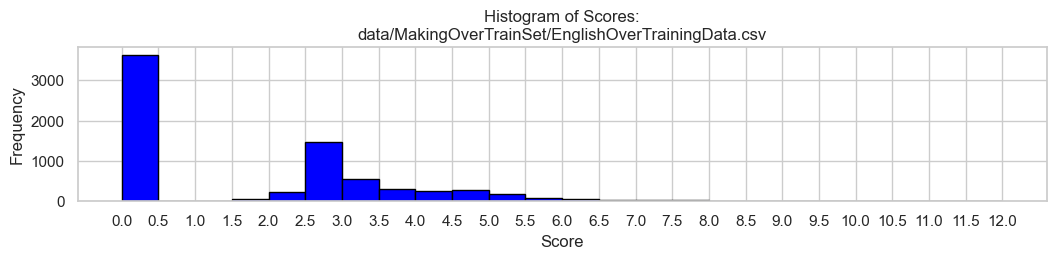

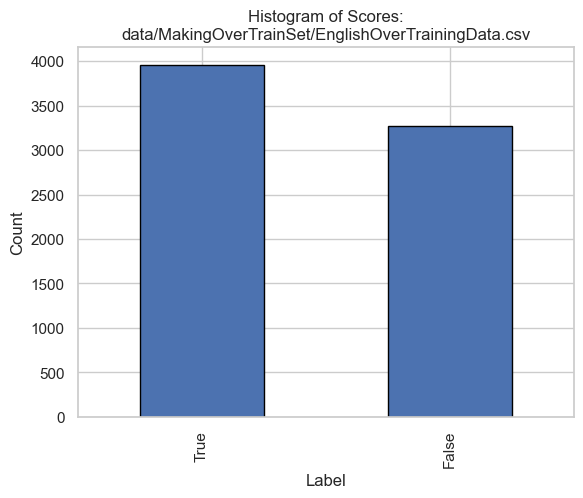

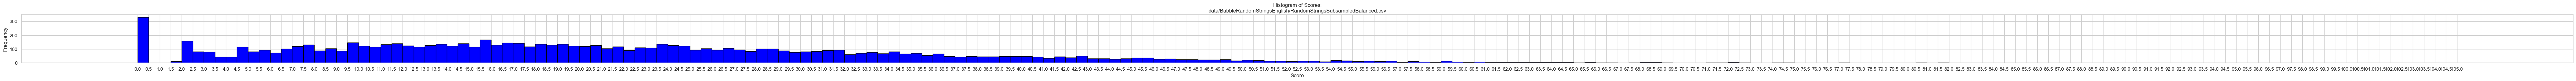

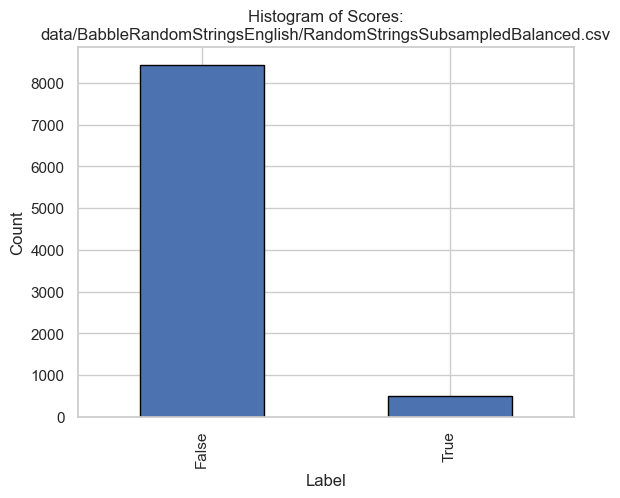

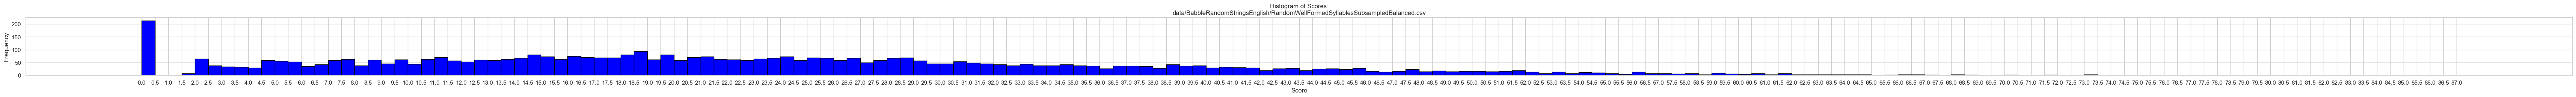

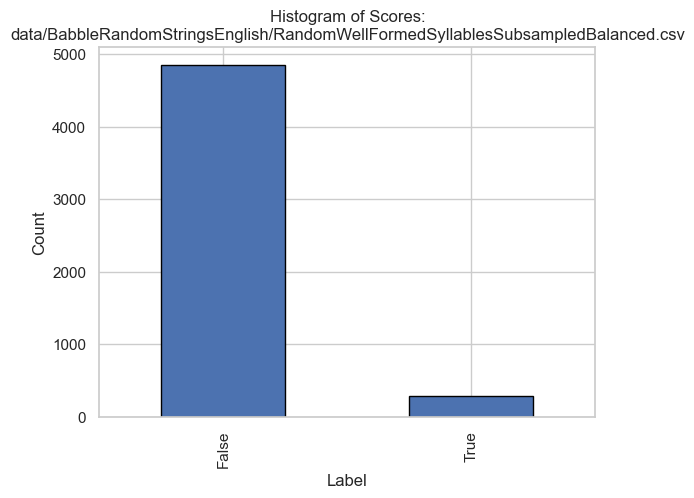

In [117]:
for (train_file, train_dataset) in zip(train_files, train_datasets):
#     train_dataset = load_train_dataset(train_file, informant, mf_scorer)
    plot_histogram_scores(train_dataset, title=f'Histogram of Scores:\n{train_file}')
    plot_histogram_labels(train_dataset, title=f'Histogram of Scores:\n{train_file}')
    

In [90]:
eval_dataset = load_eval_dataset(informant, mf_scorer)

 33%|███████████████████████▊                                                | 4106/12390 [00:01<00:03, 2677.70it/s]

KeyboardInterrupt: 

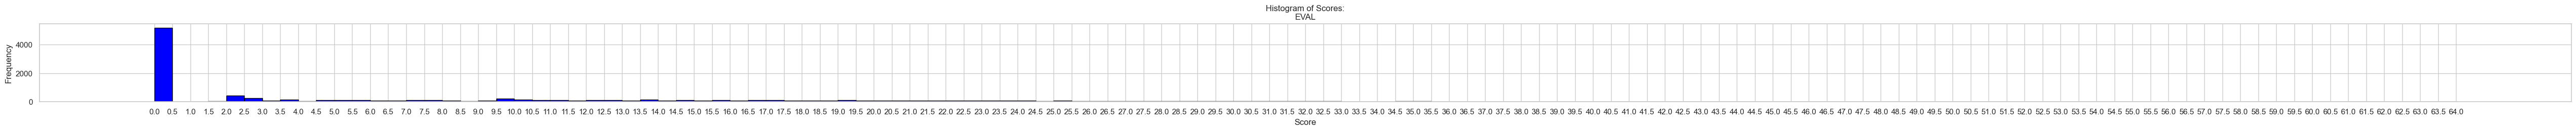

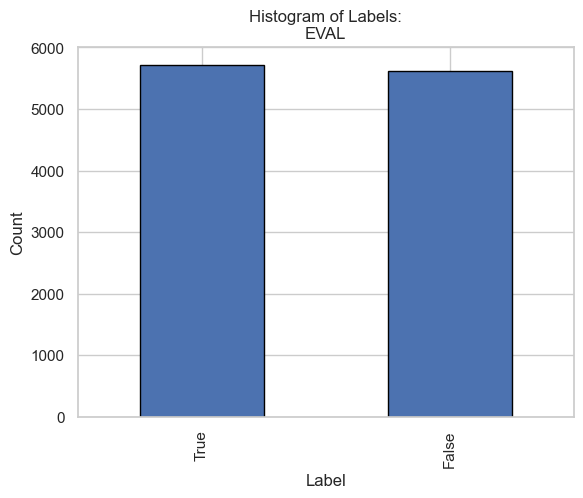

In [115]:
# eval_dataset = load_eval_dataset(informant, mf_scorer)
plot_histogram_scores(eval_dataset, title=f'Histogram of Scores:\nEVAL')
plot_histogram_labels(eval_dataset, title=f'Histogram of Labels:\nEVAL')

In [111]:
eval_dataset['label'].value_counts()

True     5719
False    5617
Name: label, dtype: int64

In [121]:
for td in train_datasets:
#     print(td['item'].value_counts().max())
    print(len(td))

7228
8945
5143
